# **Case QuantumFinance - Disciplina NLP - Classificador de chamados**

### **Parte 1 – Definição do Problema de Negócio**

A QuantumFinance, empresa do setor financeiro digital, mantém um canal de atendimento via chat onde os clientes relatam dúvidas, solicitações e problemas. O desafio é desenvolver um modelo de inteligência artificial capaz de classificar automaticamente o assunto dos chamados com base no texto livre fornecido pelo cliente, com o objetivo de otimizar o direcionamento das demandas para as áreas responsáveis e aumentar a eficiência do atendimento.

### **Objetivos do Projeto**

Desenvolver um sistema de classificação de chamados utilizando técnicas de Processamento de Linguagem Natural (PLN), incluindo vetorização com n-gramas e métricas como TF-IDF, além da aplicação de modelos supervisionados.

* Meta de performance: atingir um F1-Score médio ponderado ≥ 75%.
* Divisão dos dados: 75% para treino e 25% para teste, com `random_state=42`.
* Construir um segundo modelo baseado em embeddings, utilizando Word2Vec e/ou LLMs em português (como BERTimbau ou SentenceTransformers), sem uso de APIs externas.

### **Critérios de Avaliação**

* 50% – Aplicação adequada das técnicas de PLN, incluindo pré-processamento, vetorização, embeddings, escolha e avaliação de modelos, além da organização do código.
* 50% – Desempenho do modelo com base na métrica F1-Score (average='weighted') no conjunto de teste.

### **Requisitos Técnicos**

* Implementar um pipeline completo de NLP, incluindo:

  * Limpeza e normalização textual;
  * Lematização;
  * Vetorização;
  * Treinamento e avaliação dos modelos.

* Desenvolver obrigatoriamente duas abordagens:

  1. Modelo tradicional com TF-IDF e algoritmo supervisionado.
  2. Modelo baseado em embeddings com Word2Vec ou LLMs (sem API externa).

* Separar e entregar o pipeline completo do modelo campeão ao final do notebook.

* O notebook final deve seguir o template: `Template_Trabalho_Final_NLP.ipynb`.


In [1]:
# Instalando pacotes
!pip install wordcloud

# Instalando pacotes transformers
!pip install -U transformers sentence-transformers
!pip install transformers datasets accelerate # roda transformers na GPU

# Instalando pacotes ML
!pip install lightgbm
!pip install xgboost
!pip install catboost

# Instalando pacotes nlp
!pip install nltk
!pip install -q spacy unidecode
!pip install leia-br
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 117.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 470.2/470.2 kB 41.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 112.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
# Verificando disponibilidade de GPU com PyTorch
import torch

# Detectar dispositivo disponível
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Dispositivo em uso:", device)

# Se CUDA estiver disponível, exibe informações da GPU
if device == 'cuda':
    print("CUDA disponível:", torch.cuda.is_available())
    print("Nome da GPU:", torch.cuda.get_device_name(0))
else:
    print("CUDA não está disponível. Usando CPU.")

Dispositivo em uso: cuda
CUDA disponível: True
Nome da GPU: Tesla T4


In [2]:
# Bibliotecas de manipulação de strings e sistema de arquivos
import re
import os

# Bibliotecas de NLP
import spacy
import nltk
from nltk.util import ngrams
from nltk.corpus import stopwords
from LeIA import SentimentIntensityAnalyzer

# Bibliotecas numéricas e tabulares
import numpy as np
import pandas as pd

# Visualização de dados
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter

# Pré-processamento
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import label_binarize

# Modelos de machine learning
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC, LinearSVC

# Métricas de avaliação
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, f1_score

# Validação de modelos
from sklearn.model_selection import train_test_split

# Vetorização de texto
from sklearn.feature_extraction.text import TfidfVectorizer

# Transformers (HuggingFace)
import torch
from transformers import pipeline
from transformers import BertTokenizer, BertModel
from transformers import AutoTokenizer, AutoModel
from transformers import BartTokenizer, BartForSequenceClassification

# Sentence Transformers
from sentence_transformers import SentenceTransformer

# Normalização de texto
from unidecode import unidecode

# Barra de progresso
from tqdm import tqdm

# Supressão de warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Baixando pacote modelo idioma pt-br pelo spacy
!python -m spacy download pt_core_news_sm

# Carregar modelo spaCy em português
nlp = spacy.load("pt_core_news_sm")

# lista de stopwords do NLTK
nltk.download('stopwords')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 20.0 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# **Parte 2 - Base dados**

In [ ]:
df = pd.read_csv('https://dados-ml-pln.s3.sa-east-1.amazonaws.com/tickets_reclamacoes_classificados.csv', delimiter=';')
df

id_reclamacao              data_abertura  \
0            3229299  2019-05-01T12:00:00-05:00   
1            3199379  2019-04-02T12:00:00-05:00   
2            3233499  2019-05-06T12:00:00-05:00   
3            3180294  2019-03-14T12:00:00-05:00   
4            3224980  2019-04-27T12:00:00-05:00   
...              ...                        ...   
21067        3094545  2018-12-07T12:00:00-05:00   
21068        3091984  2018-12-05T12:00:00-05:00   
21069        3133355  2019-01-25T12:00:00-05:00   
21070        3110963  2018-12-27T12:00:00-05:00   
21071        2001189  2016-07-06T12:00:00-05:00   

                                 categoria  \
0                  Hipotecas / Empréstimos   
1      Cartão de crédito / Cartão pré-pago   
2      Cartão de crédito / Cartão pré-pago   
3      Cartão de crédito / Cartão pré-pago   
4               Serviços de conta bancária   
...                                    ...   
21067  Cartão de crédito / Cartão pré-pago   
21068         Roubo / Relatório de disputa   
21069         Roubo / Relatório de disputa   
21070                               Outros   
21071                               Outros   

                                    descricao_reclamacao  
0      Bom dia, meu nome é xxxx xxxx e agradeço se vo...  
1      Atualizei meu cartão xxxx xxxx em xx/xx/2018 e...  
2      O cartão Chase foi relatado em xx/xx/2019. No ...  
3      Em xx/xx/2018, enquanto tentava reservar um ti...  
4      Meu neto me dê cheque por {$ 1600,00} Eu depos...  
...                                                  ...  
21067  Depois de ser um cliente de cartão de persegui...  
21068  Na quarta -feira, xx/xx/xxxx, liguei para o Ch...  
21069  Não estou familiarizado com o XXXX Pay e não e...  
21070  Eu tive crédito impecável por 30 anos. Eu tive...  
21071  Mais de 10 anos atrás, encerrei minhas contas ...  

[21072 rows x 4 columns]

In [ ]:
df.head()

id_reclamacao              data_abertura  \
0        3229299  2019-05-01T12:00:00-05:00   
1        3199379  2019-04-02T12:00:00-05:00   
2        3233499  2019-05-06T12:00:00-05:00   
3        3180294  2019-03-14T12:00:00-05:00   
4        3224980  2019-04-27T12:00:00-05:00   

                             categoria  \
0              Hipotecas / Empréstimos   
1  Cartão de crédito / Cartão pré-pago   
2  Cartão de crédito / Cartão pré-pago   
3  Cartão de crédito / Cartão pré-pago   
4           Serviços de conta bancária   

                                descricao_reclamacao  
0  Bom dia, meu nome é xxxx xxxx e agradeço se vo...  
1  Atualizei meu cartão xxxx xxxx em xx/xx/2018 e...  
2  O cartão Chase foi relatado em xx/xx/2019. No ...  
3  Em xx/xx/2018, enquanto tentava reservar um ti...  
4  Meu neto me dê cheque por {$ 1600,00} Eu depos...

In [ ]:
df.tail()

id_reclamacao              data_abertura  \
21067        3094545  2018-12-07T12:00:00-05:00   
21068        3091984  2018-12-05T12:00:00-05:00   
21069        3133355  2019-01-25T12:00:00-05:00   
21070        3110963  2018-12-27T12:00:00-05:00   
21071        2001189  2016-07-06T12:00:00-05:00   

                                 categoria  \
21067  Cartão de crédito / Cartão pré-pago   
21068         Roubo / Relatório de disputa   
21069         Roubo / Relatório de disputa   
21070                               Outros   
21071                               Outros   

                                    descricao_reclamacao  
21067  Depois de ser um cliente de cartão de persegui...  
21068  Na quarta -feira, xx/xx/xxxx, liguei para o Ch...  
21069  Não estou familiarizado com o XXXX Pay e não e...  
21070  Eu tive crédito impecável por 30 anos. Eu tive...  
21071  Mais de 10 anos atrás, encerrei minhas contas ...

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21072 entries, 0 to 21071
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id_reclamacao         21072 non-null  int64 
 1   data_abertura         21072 non-null  object
 2   categoria             21072 non-null  object
 3   descricao_reclamacao  21072 non-null  object
dtypes: int64(1), object(3)
memory usage: 658.6+ KB


In [ ]:
df.shape

(21072, 4)

In [ ]:
df.dtypes

id_reclamacao            int64
data_abertura           object
categoria               object
descricao_reclamacao    object
dtype: object

# **Parte 3 - Limpeza de dados**

In [ ]:
# Visão geral do DataFrame
print("Shape inicial:", df.shape)

Shape inicial: (21072, 4)


In [ ]:
# Verificar valores nulos
print("\n Valores nulos por coluna:")
print(df.isnull().sum())


 Valores nulos por coluna:
id_reclamacao           0
data_abertura           0
categoria               0
descricao_reclamacao    0
dtype: int64


In [ ]:
# Porcentagem de nulos
print("\n Porcentagem de valores nulos:")
print((df.isnull().mean() * 100).round(2))


 Porcentagem de valores nulos:
id_reclamacao           0.0
data_abertura           0.0
categoria               0.0
descricao_reclamacao    0.0
dtype: float64


In [ ]:
# Verificar células com texto vazio ou somente espaços
df["descricao_reclamacao"] = df["descricao_reclamacao"].astype(str)
n_texto_vazio = df["descricao_reclamacao"].apply(lambda x: x.strip() == "").sum()
print(f"\n Linhas com texto vazio ou em branco: {n_texto_vazio}")


 Linhas com texto vazio ou em branco: 0


In [ ]:
# Verificar duplicatas
duplicadas = df.duplicated().sum()
print(f"\n Linhas duplicadas: {duplicadas}")


 Linhas duplicadas: 0


In [ ]:
# Visualizar duplicatas (opcional)
# df[df.duplicated()]

In [ ]:
# Remover duplicadas e textos em branco (Ser caso tive dados duplicados)
#df_limpo = df.drop_duplicates().copy()
#df_limpo = df_limpo[df_limpo["texto"].apply(lambda x: x.strip() != "")]
#print("\n Shape final após limpeza:", df_limpo.shape)

# **Parte 4 - Pré-processamento**

In [ ]:
%%time

# Baixar recursos se necessário
nltk.download('stopwords')

#
stopwords_pt = set(stopwords.words('portuguese'))

#
nlp = spacy.load("pt_core_news_sm")

# Função pre-processamento
def preprocessamento_nlp_completo(df, coluna_texto="descricao_reclamacao"):
    """
    Função única de pipeline de NLP:
    - Limpa texto (minúsculas, acentos, URL, números, pontuação, palavras tipo 'xxxx')
    - Remove stopwords
    - Tokeniza
    - Lematiza (spaCy)
    - Gera unigrama, bigrama, trigrama
    - Cria tokens sem stopwords
    Retorna DataFrame com novas colunas.
    """

    # Limpeza + stopwords + tokenização
    def limpar_e_tokenizar(texto):
        texto = str(texto).lower()
        texto = unidecode(texto)
        texto = re.sub(r"http\S+|www\S+|https\S+", "", texto)
        texto = re.sub(r"\d+", "", texto)
        texto = re.sub(r"[^\w\s]", "", texto)
        texto = re.sub(r"\b[x]+\b", "", texto)
        tokens = texto.split()
        tokens_sem_sw = [t for t in tokens if t not in stopwords_pt]
        return texto, tokens, tokens_sem_sw

    # Lematização
    def lematizar(texto):
        doc = nlp(texto)
        return [token.lemma_ for token in doc if not token.is_punct and not token.is_space]

    # N-grams
    def gerar_ngrams(tokens, n):
        return [" ".join(grama) for grama in ngrams(tokens, n)]

    # Aplicando pipeline linha a linha
    descricao_limp, tokens, tokens_sem_sw, lemas, unigrama, bigramas, trigramas = [], [], [], [], [], [], []
    for texto in df[coluna_texto]:
        limp, toks, toks_sem_sw = limpar_e_tokenizar(texto)
        descricao_limp.append(limp)
        tokens.append(toks)
        tokens_sem_sw.append(toks_sem_sw)
        lemas.append(lematizar(limp))
        unigrama.append(gerar_ngrams(toks, 1))
        bigramas.append(gerar_ngrams(toks, 2))
        trigramas.append(gerar_ngrams(toks, 3))

    # Atribuir ao DataFrame
    df["descricao_reclamacao_limp"] = descricao_limp
    df["tokens"] = tokens
    df["tokens_sem_stopwords"] = tokens_sem_sw
    df["lematizacao"] = lemas
    df["Unigrama"] = unigrama
    df["Bigramas"] = bigramas
    df["Trigramas"] = trigramas

    return df

# Aplicando função
df = preprocessamento_nlp_completo(df, coluna_texto="descricao_reclamacao")

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


CPU times: user 10min 50s, sys: 2.06 s, total: 10min 52s
Wall time: 10min 52s


In [ ]:
# Exibindo as primeiras linhas da nova coluna de texto limpo
df[["descricao_reclamacao", "descricao_reclamacao_limp"]].head(10)

descricao_reclamacao  \
0  Bom dia, meu nome é xxxx xxxx e agradeço se vo...   
1  Atualizei meu cartão xxxx xxxx em xx/xx/2018 e...   
2  O cartão Chase foi relatado em xx/xx/2019. No ...   
3  Em xx/xx/2018, enquanto tentava reservar um ti...   
4  Meu neto me dê cheque por {$ 1600,00} Eu depos...   
5                       Você pode remover a consulta   
6  Sem aviso prévio J.P. Morgan Chase restringiu ...   
7  Durante os meses de verão, experimento uma ren...   
8  Em xxxx xx/xx/2019, fiz um pagamento {$ 300.00...   
9  Eu tenho um cartão de crédito Chase que está r...   

                           descricao_reclamacao_limp  
0  bom dia meu nome e   e agradeco se voce puder ...  
1  atualizei meu cartao   em  e fui informado pel...  
2  o cartao chase foi relatado em  no entanto o p...  
3  em  enquanto tentava reservar um ticket   me d...  
4  meu neto me de cheque por   eu depositei o na ...  
5                       voce pode remover a consulta  
6  sem aviso previo jp morgan chase restringiu mi...  
7  durante os meses de verao experimento uma rend...  
8  em   fiz um pagamento   a um varejista on line...  
9  eu tenho um cartao de credito chase que esta r...

In [ ]:
# Exibindo a coluna texto limpo + tokens lado a lado tokens
df[["descricao_reclamacao_limp", "tokens"]].head(10)

descricao_reclamacao_limp  \
0  bom dia meu nome e   e agradeco se voce puder ...   
1  atualizei meu cartao   em  e fui informado pel...   
2  o cartao chase foi relatado em  no entanto o p...   
3  em  enquanto tentava reservar um ticket   me d...   
4  meu neto me de cheque por   eu depositei o na ...   
5                       voce pode remover a consulta   
6  sem aviso previo jp morgan chase restringiu mi...   
7  durante os meses de verao experimento uma rend...   
8  em   fiz um pagamento   a um varejista on line...   
9  eu tenho um cartao de credito chase que esta r...   

                                              tokens  
0  [bom, dia, meu, nome, e, e, agradeco, se, voce...  
1  [atualizei, meu, cartao, em, e, fui, informado...  
2  [o, cartao, chase, foi, relatado, em, no, enta...  
3  [em, enquanto, tentava, reservar, um, ticket, ...  
4  [meu, neto, me, de, cheque, por, eu, depositei...  
5                 [voce, pode, remover, a, consulta]  
6  [sem, aviso, previo, jp, morgan, chase, restri...  
7  [durante, os, meses, de, verao, experimento, u...  
8  [em, fiz, um, pagamento, a, um, varejista, on,...  
9  [eu, tenho, um, cartao, de, credito, chase, qu...

# **Parte 4.1 - Análise de sentimento (LeIA)**

**LeIA** é uma biblioteca de **Processamento de Linguagem Natural (PLN)** em português, com foco em **pré-processamento linguístico**, especialmente para textos informais ou de domínio geral. Ela foi criada com foco no idioma português brasileiro e pode ser utilizada para:

* **Remoção de stopwords**
* **Lematização**
* **Normalização de texto**
* Trabalhar com **listas léxicas otimizadas para o português**

**A LeIA é ideal quando**

* Você precisa de uma ferramenta **leve e simples** para PLN em português
* Quer trabalhar com **listas de stopwords e lemas bem adaptados ao idioma**
* Precisa **evitar dependências pesadas** como spaCy ou NLTK



In [ ]:
%%time

# Inicializa o analisador
analyzer = SentimentIntensityAnalyzer()

# Função para classificar sentimento
def aplicar_classificacao_sentimento(df, coluna_texto="descricao_reclamacao_limp"):
    """
    Adiciona duas colunas ao DataFrame:
    - sentiment_score: valor de sentimento (-1 a +1)
    - sentiment_class: classificador ('positivo', 'neutro', 'negativo')
    """
    analyzer = SentimentIntensityAnalyzer()

    def analisar_sentimento(texto):
        resultado = analyzer.polarity_scores(texto)
        score = resultado["compound"]
        if score >= 0.05:
            sentimento = "positivo"
        elif score <= -0.05:
            sentimento = "negativo"
        else:
            sentimento = "neutro"
        return pd.Series([score, sentimento])

    df[["sentiment_score", "sentiment_class"]] = df[coluna_texto].apply(analisar_sentimento)
    return df

# Aplicando função sentimento
df = aplicar_classificacao_sentimento(df, coluna_texto="descricao_reclamacao_limp")

CPU times: user 1min 36s, sys: 132 ms, total: 1min 36s
Wall time: 1min 36s


In [ ]:
# Visualização
df[["descricao_reclamacao_limp", "sentiment_score", "sentiment_class"]].head(10)

descricao_reclamacao_limp  sentiment_score  \
0  bom dia meu nome e   e agradeco se voce puder ...          -0.1027   
1  atualizei meu cartao   em  e fui informado pel...          -0.4588   
2  o cartao chase foi relatado em  no entanto o p...          -0.3612   
3  em  enquanto tentava reservar um ticket   me d...          -0.7579   
4  meu neto me de cheque por   eu depositei o na ...          -0.2500   
5                       voce pode remover a consulta           0.2732   
6  sem aviso previo jp morgan chase restringiu mi...          -0.9911   
7  durante os meses de verao experimento uma rend...           0.0164   
8  em   fiz um pagamento   a um varejista on line...          -0.9746   
9  eu tenho um cartao de credito chase que esta r...           0.5106   

  sentiment_class  
0        negativo  
1        negativo  
2        negativo  
3        negativo  
4        negativo  
5        positivo  
6        negativo  
7          neutro  
8        negativo  
9        positivo

# **Parte 5 - Análise exploratoria de dados**

<Axes: xlabel='sentiment_class', ylabel='count'>

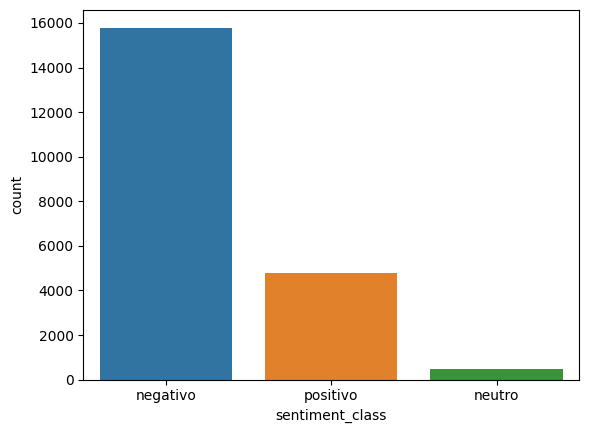

In [ ]:
sns.countplot(x="sentiment_class", data=df)

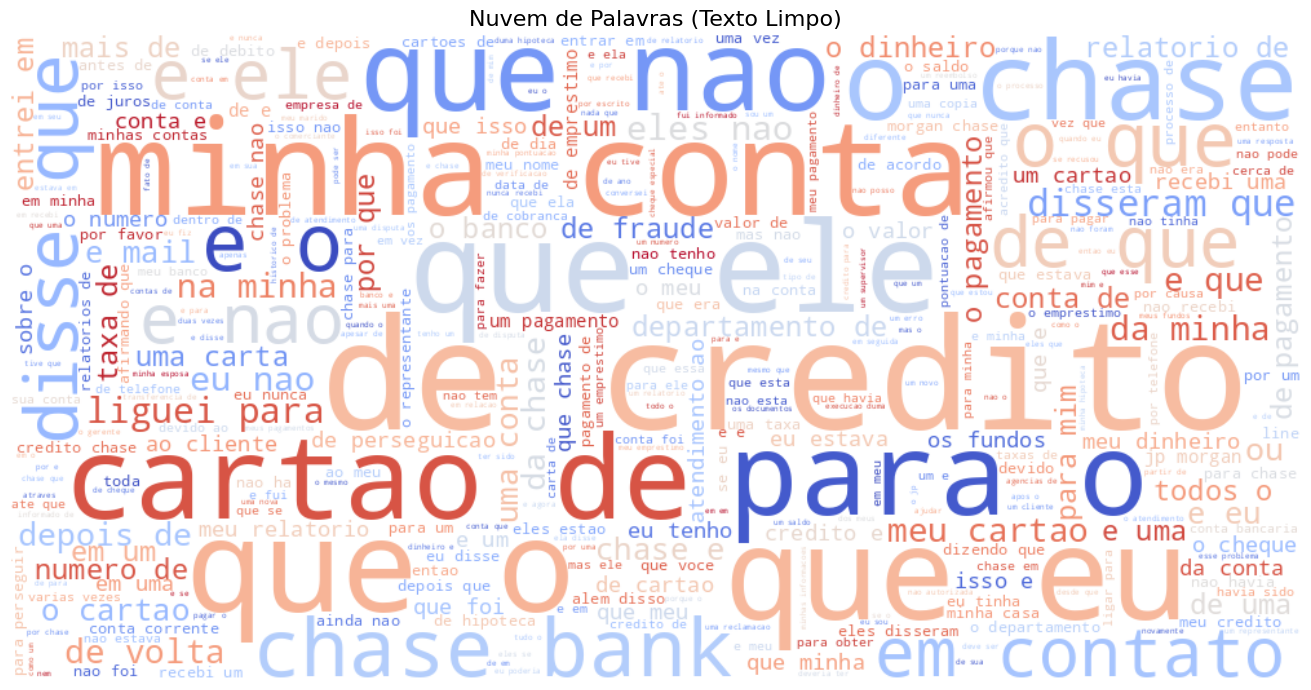

In [ ]:
# Concatenar todos os textos da coluna em uma única string
texto_unico = " ".join(df['descricao_reclamacao_limp'].dropna().tolist())

# Criar a nuvem de palavras
wordcloud = WordCloud(width=1000,
                      height=500,
                      background_color='white',
                      colormap='coolwarm',  # outras opções: 'plasma', 'coolwarm', 'inferno'
                      max_words=350,
                      max_font_size=120).generate(texto_unico)

# Exibir o gráfico
plt.figure(figsize=(14, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nuvem de Palavras (Texto Limpo)', fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
def gerar_wordcloud_por_sentimento_texto(df, sentimento, coluna='descricao_reclamacao_limp'):
    """
    Gera uma nuvem de palavras com base na coluna de texto limpo,
    filtrada por um sentimento específico.

    Parâmetros:
    - df: DataFrame contendo os dados
    - sentimento: 'Positive', 'Negative' ou 'Neutral'
    - coluna: nome da coluna de texto limpo
    """
    # Filtrar os textos do sentimento
    textos = df[df['sentiment_class'] == sentimento][coluna].dropna()
    texto_unico = " ".join(textos.tolist())

    # Criar WordCloud
    cor_mapa = {'positivo': 'Greens', 'negativo': 'Reds', 'neutro': 'gray'}

    wordcloud = WordCloud(width=1000,
                          height=500,
                          background_color='white',
                          colormap=cor_mapa[sentimento],
                          max_words=200,
                          max_font_size=120).generate(texto_unico)

    # Exibir
    plt.figure(figsize=(14, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Nuvem de Palavras - Sentimento {sentimento}', fontsize=16)
    plt.tight_layout()
    plt.show()

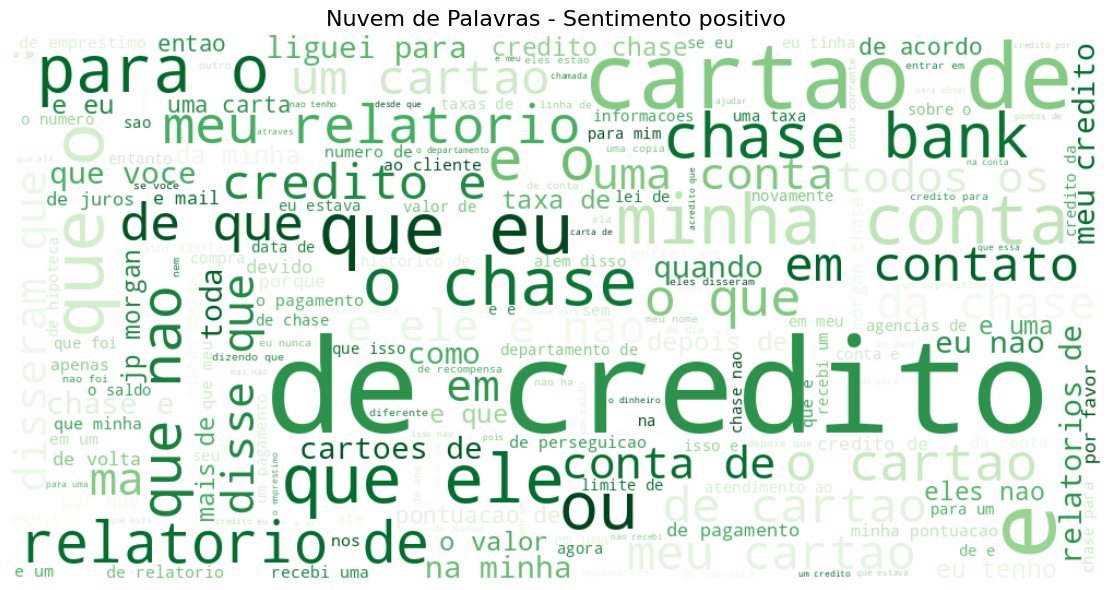

In [ ]:
# Gerar as 3 nuvens
gerar_wordcloud_por_sentimento_texto(df, 'positivo')

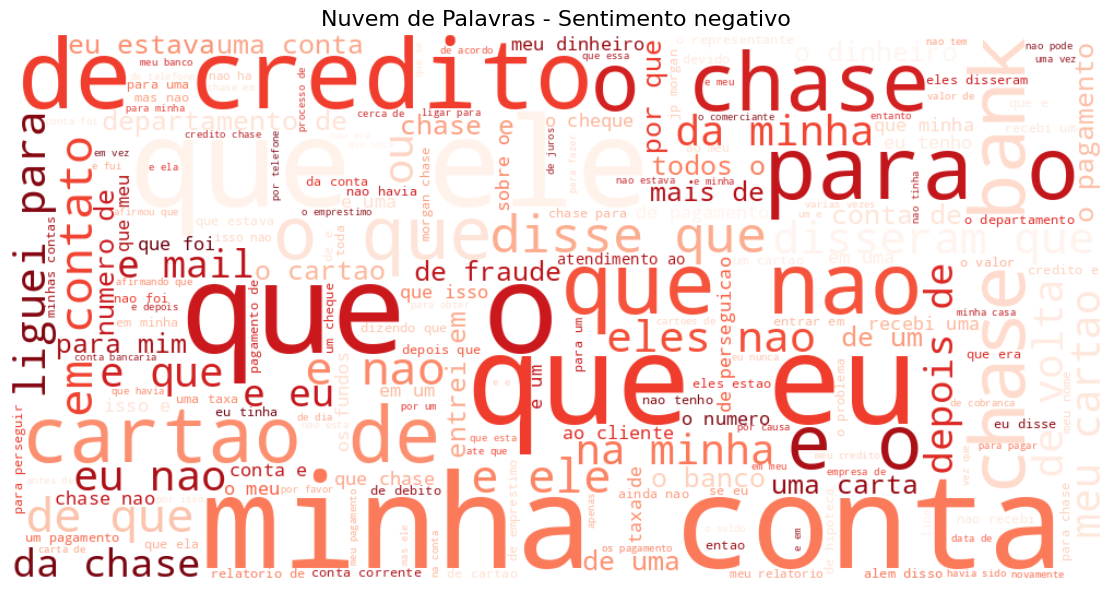

In [ ]:
gerar_wordcloud_por_sentimento_texto(df, 'negativo')

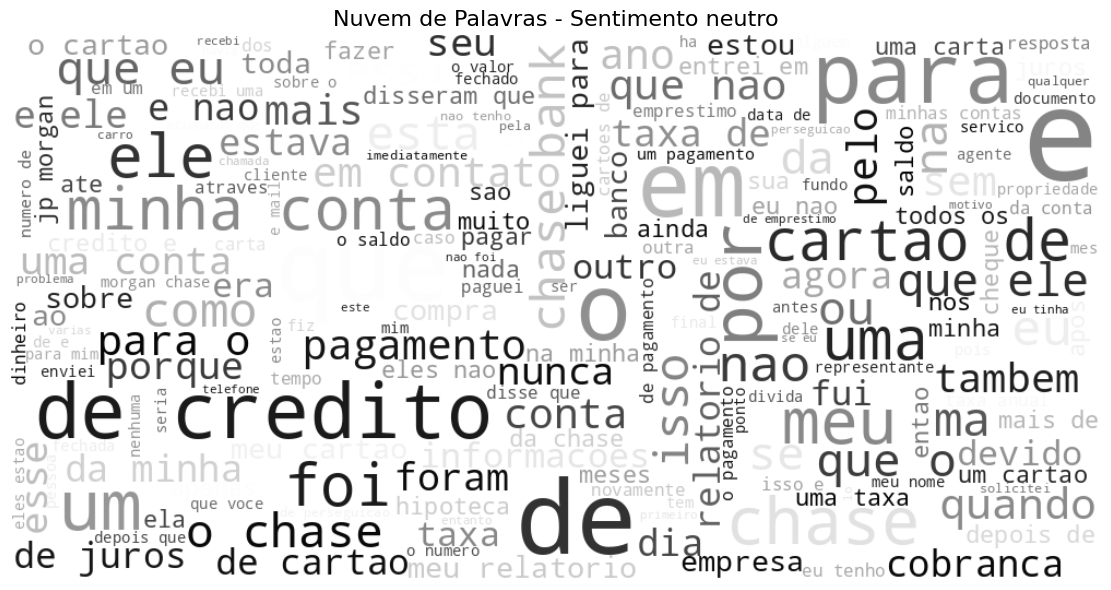

In [ ]:
gerar_wordcloud_por_sentimento_texto(df, 'neutro')

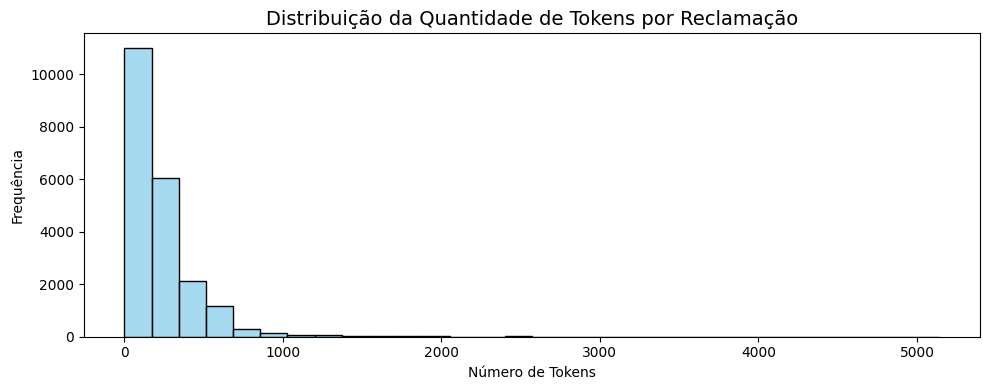

In [ ]:
# Contar número de tokens por linha
df['n_tokens'] = df['tokens'].apply(len)

# Contar número de lemas por linha
df['n_lematizacao'] = df['lematizacao'].apply(len)

# Plot 1 - Contagem de Tokens
plt.figure(figsize=(10, 4))
sns.histplot(df['n_tokens'], bins=30, kde=False, color='skyblue')
plt.title('Distribuição da Quantidade de Tokens por Reclamação', fontsize=14)
plt.xlabel('Número de Tokens')
plt.ylabel('Frequência')
plt.tight_layout()
plt.show()

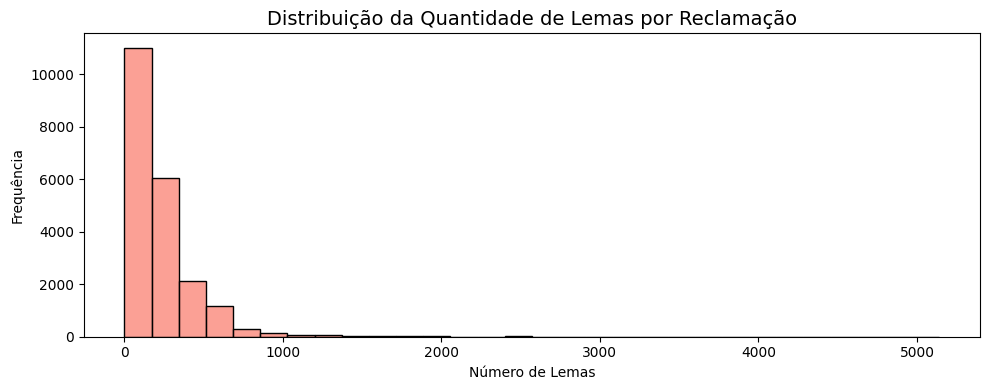

In [ ]:
# Plot 2 - Contagem de Lemas
plt.figure(figsize=(10, 4))
sns.histplot(df['n_lematizacao'], bins=30, kde=False, color='salmon')
plt.title('Distribuição da Quantidade de Lemas por Reclamação', fontsize=14)
plt.xlabel('Número de Lemas')
plt.ylabel('Frequência')
plt.tight_layout()
plt.show()

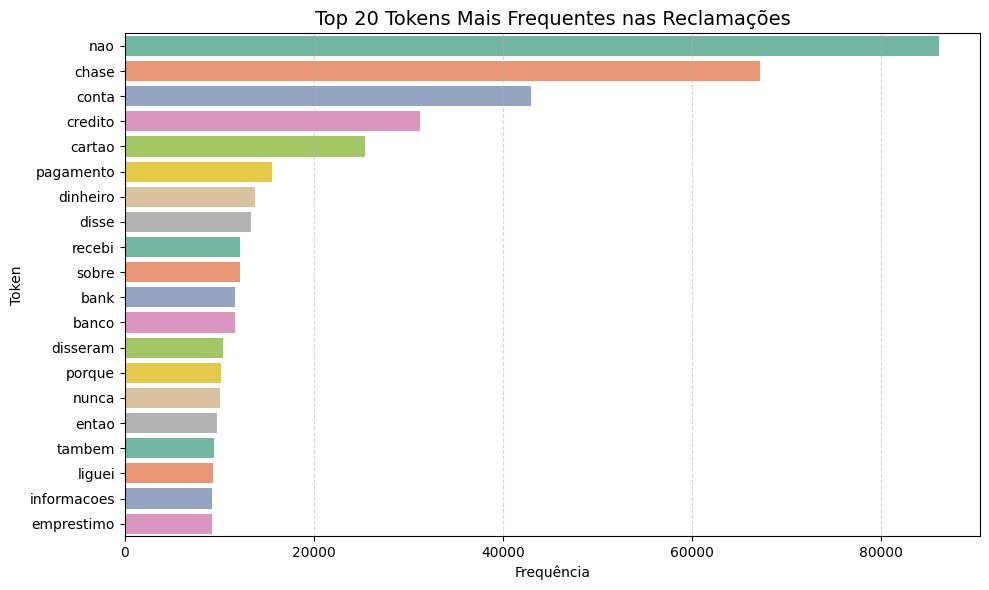

In [ ]:
# Flatten todos os tokens sem stopwords
tokens_flat = [token for sublist in df['tokens_sem_stopwords'] for token in sublist]

# Contar frequência
top_tokens = Counter(tokens_flat).most_common(20)

# Converter para DataFrame
df_top_tokens = pd.DataFrame(top_tokens, columns=['Token', 'Frequência'])

plt.figure(figsize=(10, 6))
sns.barplot(data=df_top_tokens, x='Frequência', y='Token', palette='Set2')
plt.title('Top 20 Tokens Mais Frequentes nas Reclamações', fontsize=14)
plt.xlabel('Frequência')
plt.ylabel('Token')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

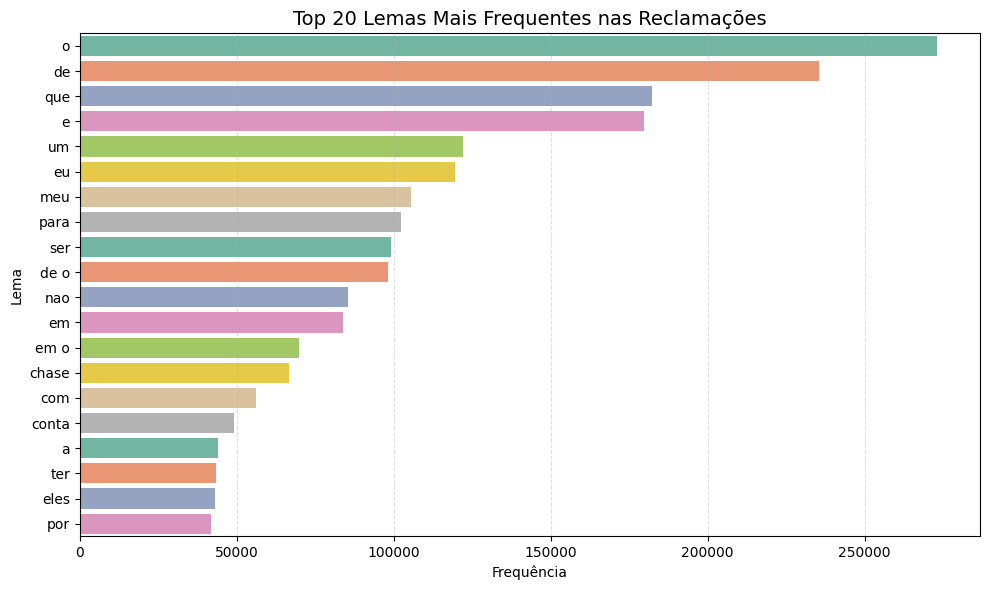

In [ ]:
# Flatten todos os lemas
lemas_flat = [lema for sublist in df['lematizacao'] for lema in sublist]

# Contar frequência
top_lemas = Counter(lemas_flat).most_common(20)

# Converter para DataFrame
df_top_lemas = pd.DataFrame(top_lemas, columns=['Lema', 'Frequência'])

plt.figure(figsize=(10, 6))
sns.barplot(data=df_top_lemas, x='Frequência', y='Lema', palette='Set2')
plt.title('Top 20 Lemas Mais Frequentes nas Reclamações', fontsize=14)
plt.xlabel('Frequência')
plt.ylabel('Lema')
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

**Questão 1)** Quais são as categorias com maior volume de reclamações?

- Objetivo: Identificar quais áreas geram mais chamados e devem ser priorizadas na resolução.

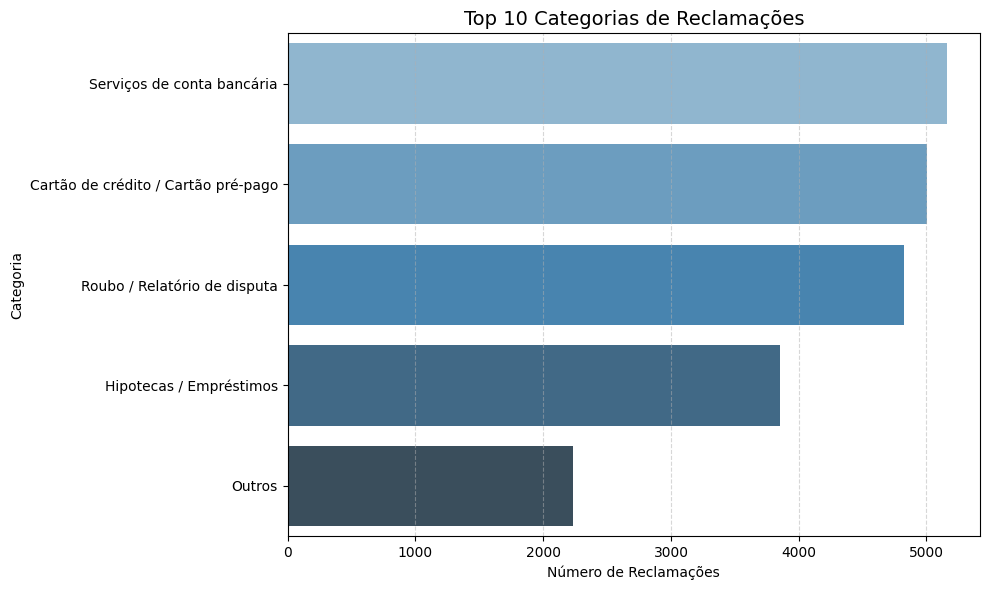

In [ ]:
# Contar as 10 categorias mais frequentes
top_categorias = df['categoria'].value_counts().head()

# Plotar gráfico de barras horizontal
plt.figure(figsize=(10, 6))
sns.barplot(x=top_categorias.values, y=top_categorias.index, palette='Blues_d')
plt.title('Top 10 Categorias de Reclamações', fontsize=14)
plt.xlabel('Número de Reclamações')
plt.ylabel('Categoria')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

**Análise**

**Questão 2)** Qual o tempo médio entre a data de abertura e hoje para cada categoria?

- Objetivo: Avaliar categorias com maior tempo médio de pendência.

In [ ]:
from datetime import datetime

#
# Garantir que a coluna está em datetime (UTC convertido para local ou sem timezone)
df['data_abertura'] = pd.to_datetime(df['data_abertura']).dt.tz_localize(None)

# Criar a coluna dias_abertos
df['dias_abertos'] = (pd.Timestamp.today() - df['data_abertura']).dt.days

print(df[['data_abertura', 'dias_abertos']].head())

        data_abertura  dias_abertos
0 2019-05-01 12:00:00          2280
1 2019-04-02 12:00:00          2309
2 2019-05-06 12:00:00          2275
3 2019-03-14 12:00:00          2328
4 2019-04-27 12:00:00          2284


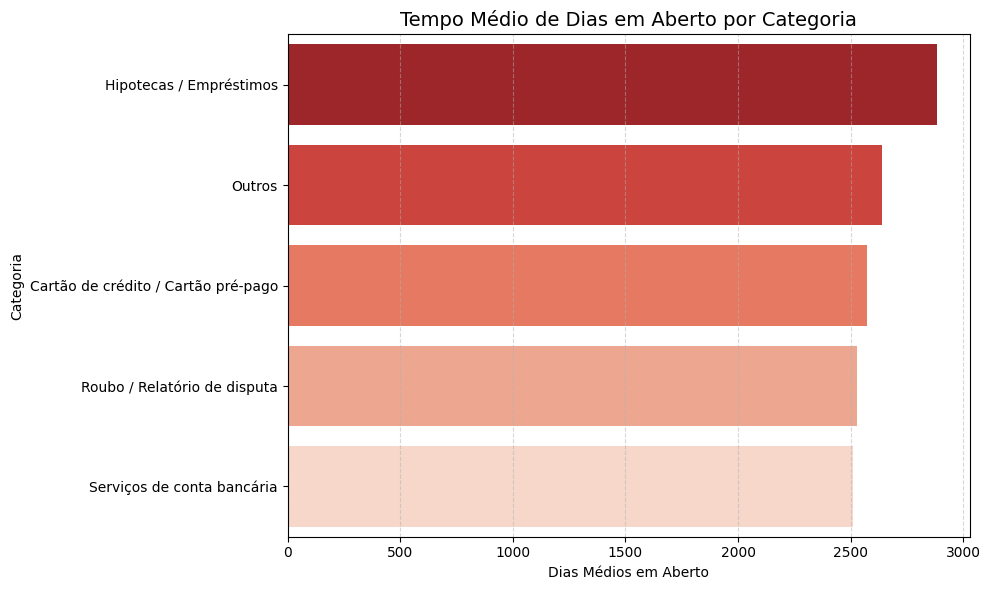

In [ ]:
# Calcular tempo médio por categoria
media_dias_abertos = df.groupby('categoria')['dias_abertos'].mean().sort_values(ascending=False)

# Plotar gráfico
plt.figure(figsize=(10, 6))
sns.barplot(x=media_dias_abertos.values, y=media_dias_abertos.index, palette='Reds_r')
plt.title('Tempo Médio de Dias em Aberto por Categoria', fontsize=14)
plt.xlabel('Dias Médios em Aberto')
plt.ylabel('Categoria')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

**Análise**

**Questão 3)** Quais categorias possuem maior proporção de sentimentos negativos?

- Objetivo: Detectar áreas com pior percepção do cliente.

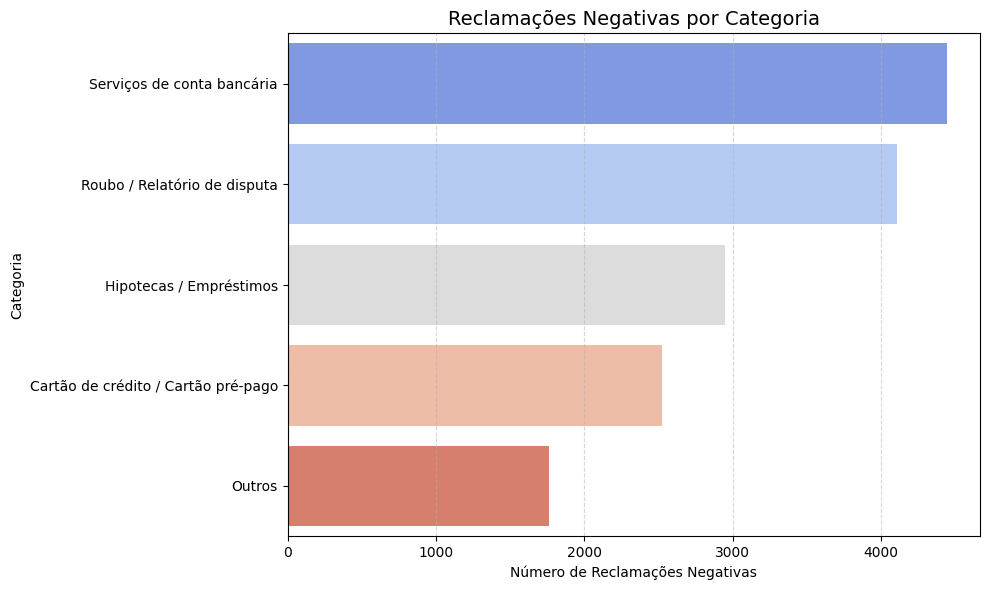

In [ ]:
# Agrupar e contar categorias com sentimento negativo
negativos_categoria = (
    df[df['sentiment_class'] == 'negativo']
    .groupby('categoria')
    .size()
    .sort_values(ascending=False)
)

# Plotar gráfico de barras horizontal
plt.figure(figsize=(10, 6))
sns.barplot(x=negativos_categoria.values, y=negativos_categoria.index, palette='coolwarm')
plt.title('Reclamações Negativas por Categoria', fontsize=14)
plt.xlabel('Número de Reclamações Negativas')
plt.ylabel('Categoria')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

**Análise**

**Questão 4)** Quais são os bigramas mais frequentes nas reclamações negativas ?

- Objetivo: Entender padrões de linguagem usados em reclamações negativas.

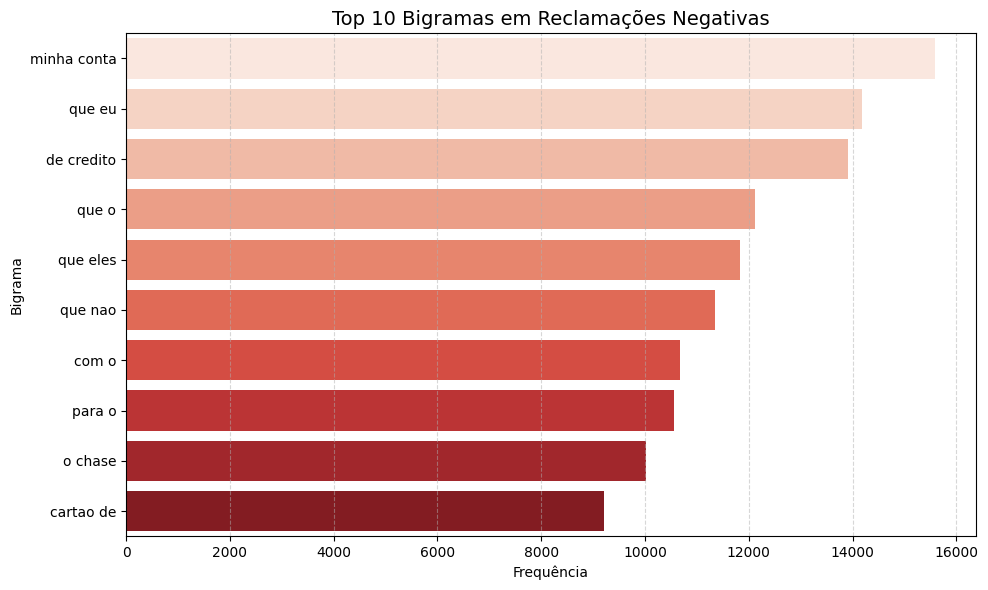

In [ ]:
# Selecionar bigramas das reclamações negativas
bigrams_negativos = df[df['sentiment_class'] == 'negativo']['Bigramas']

# Achatar a lista de listas e contar frequência
bigrams_flat = [bigram for sublist in bigrams_negativos for bigram in sublist]
top_bigrams = Counter(bigrams_flat).most_common(10)

# Converter para DataFrame
df_bigrams = pd.DataFrame(top_bigrams, columns=['Bigrama', 'Frequência'])

# Plotar gráfico
plt.figure(figsize=(10, 6))
sns.barplot(x='Frequência', y='Bigrama', data=df_bigrams, palette='Reds')
plt.title('Top 10 Bigramas em Reclamações Negativas', fontsize=14)
plt.xlabel('Frequência')
plt.ylabel('Bigrama')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
def plot_top_ngrams_por_sentimento(df, sentimento, coluna_ngrams, top_n=10):
    """
    Gera gráfico de barras com os n-gramas mais comuns para um sentimento e tipo específico.

    Parâmetros:
    - df: DataFrame com os dados
    - sentimento: 'positivo', 'negativo' ou 'neutro'
    - coluna_ngrams: 'Unigrama', 'Bigramas' ou 'Trigramas'
    - top_n: número de n-gramas a exibir
    """
    # Filtrar o DataFrame pelo sentimento correto
    lista_ngrams = df[df['sentiment_class'] == sentimento][coluna_ngrams]

    # Flatten e contar
    ngrams_flat = [ngram for sublist in lista_ngrams for ngram in sublist]
    contagem = Counter(ngrams_flat).most_common(top_n)
    df_plot = pd.DataFrame(contagem, columns=[coluna_ngrams, 'Frequência'])

    # Plotar
    plt.figure(figsize=(10, 5))
    sns.barplot(data=df_plot, x='Frequência', y=coluna_ngrams, palette='pastel')
    plt.title(f'Top {top_n} {coluna_ngrams} - Sentimento: {sentimento}', fontsize=14)
    plt.xlabel('Frequência')
    plt.ylabel(coluna_ngrams)
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


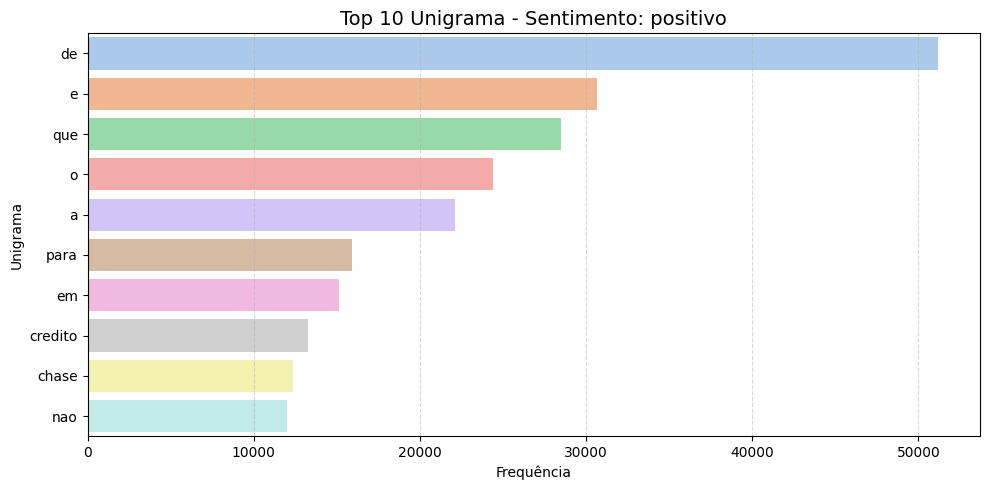

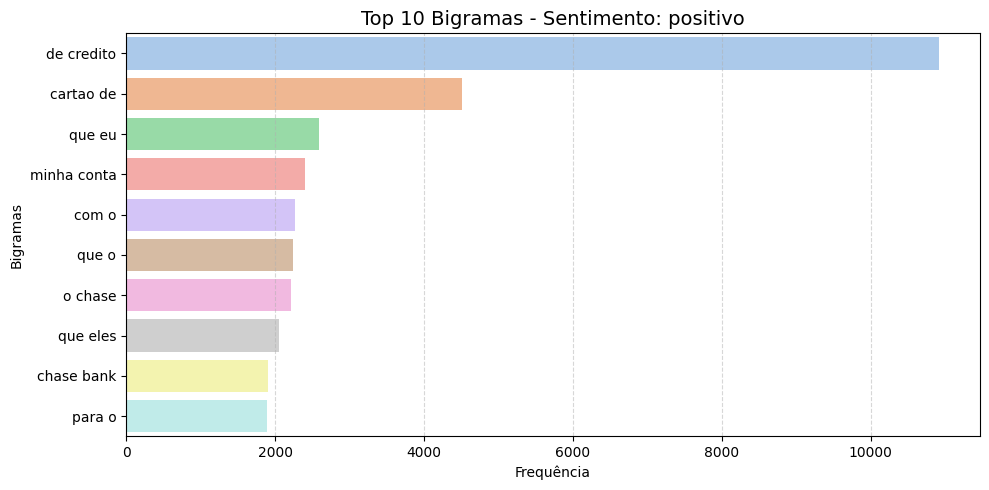

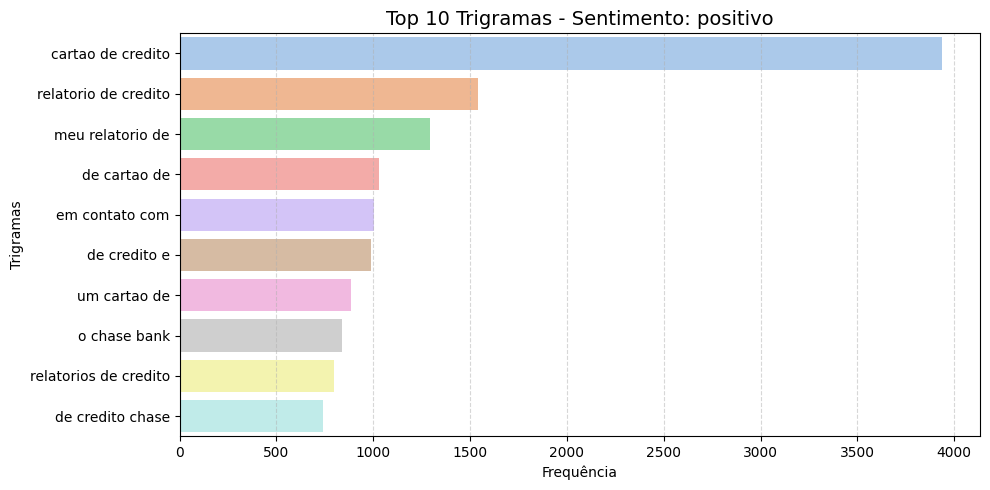

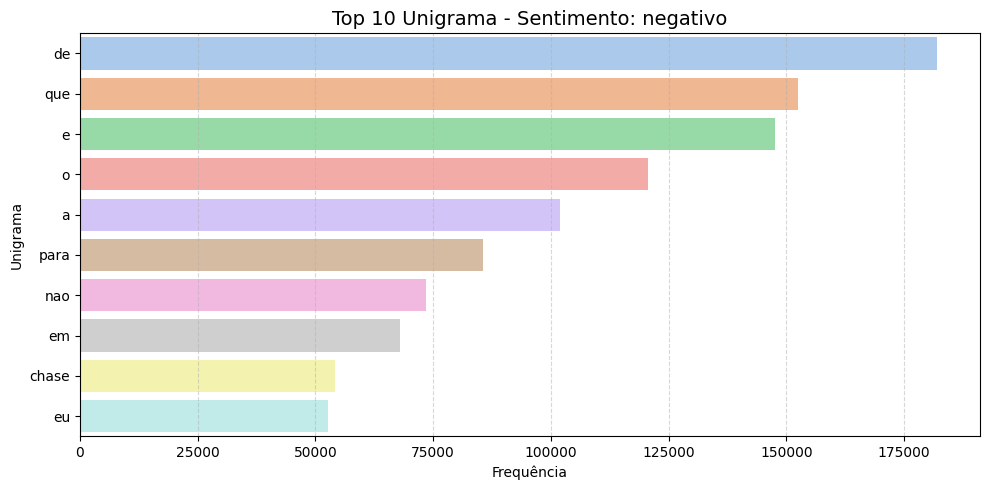

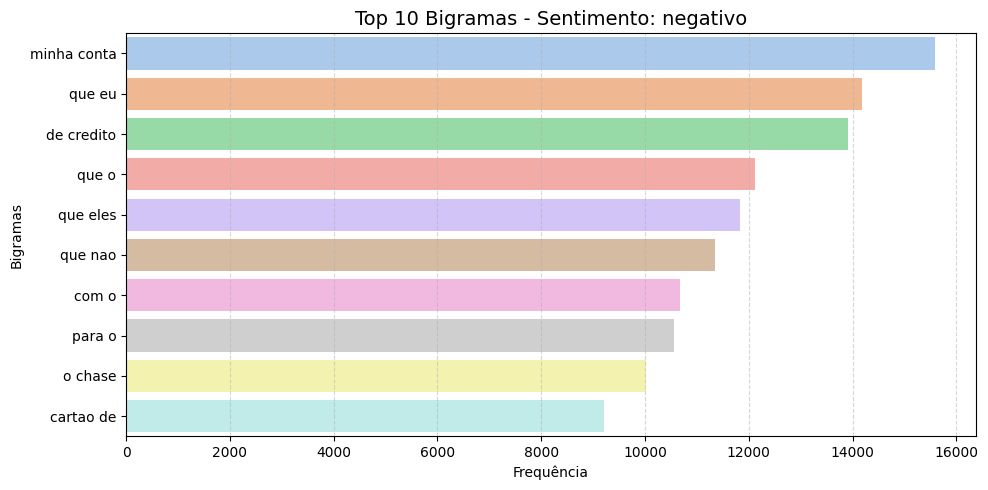

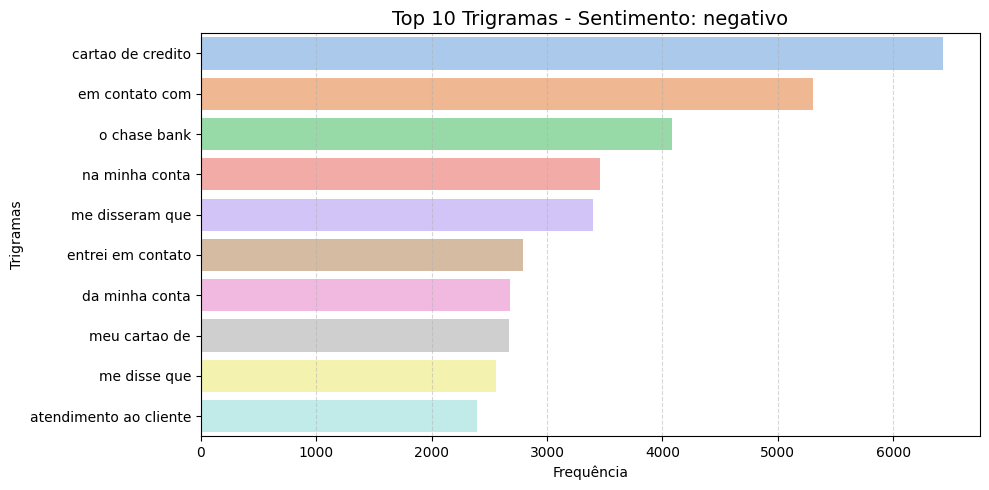

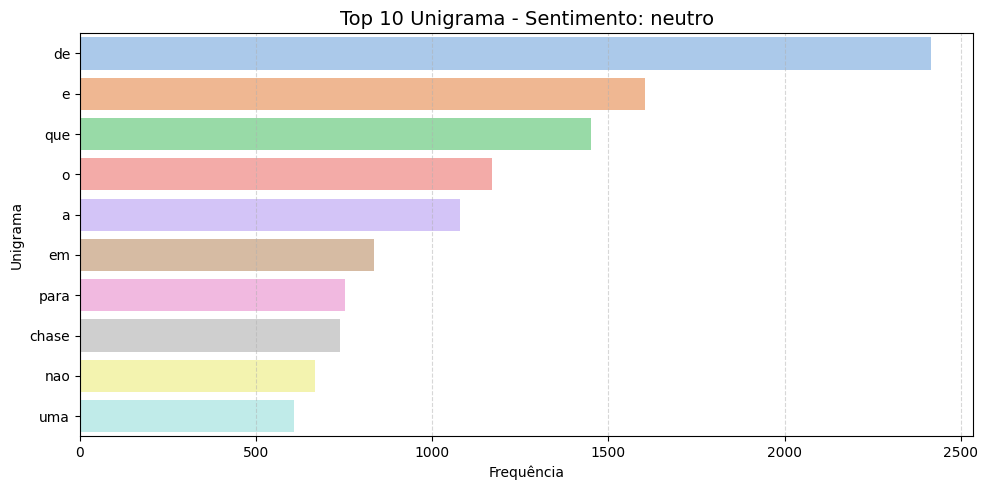

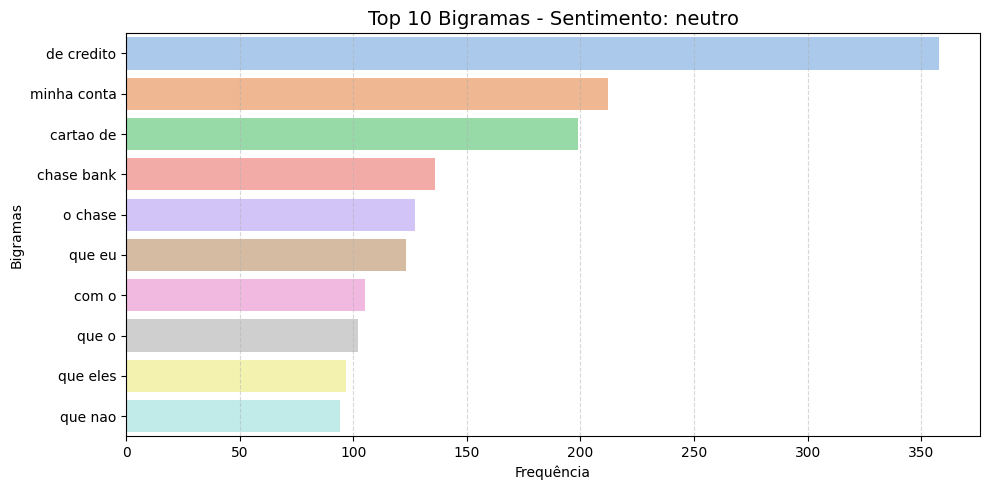

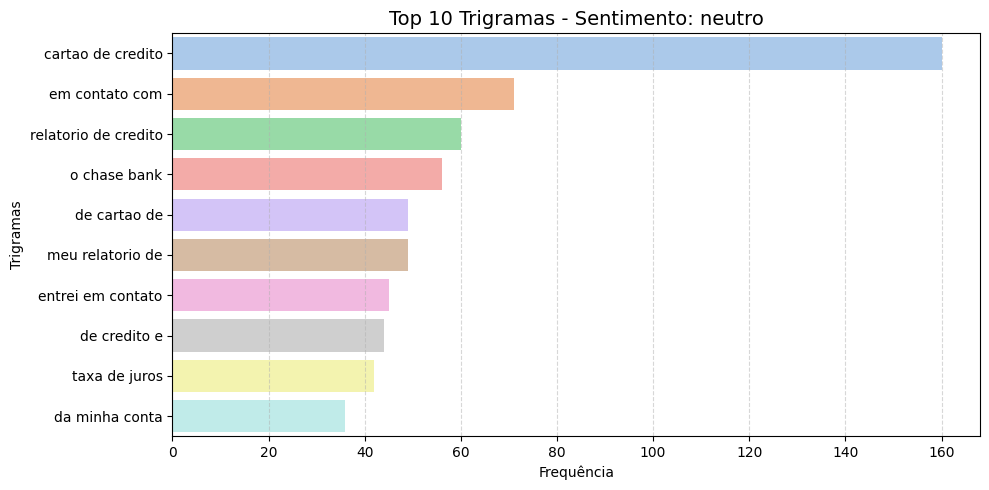

In [ ]:
sentimentos = ['positivo', 'negativo', 'neutro']
colunas_ngrams = ['Unigrama', 'Bigramas', 'Trigramas']

for sentimento in sentimentos:
    for coluna in colunas_ngrams:
        plot_top_ngrams_por_sentimento(df, sentimento, coluna)

**Análise**

**Questão 5)** Qual o sentimento médio composto (compound) por categoria?

- Objetivo: Mensurar o score emocional médio das reclamações por área.

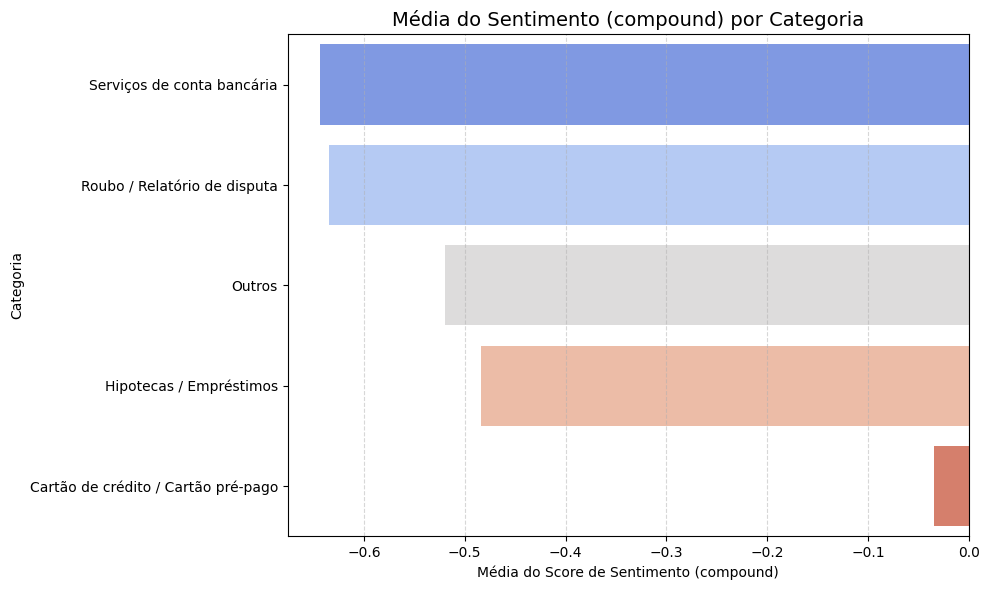

In [ ]:
# Calcular média do score composto por categoria
media_sentimento_categoria = df.groupby('categoria')['sentiment_score'].mean().sort_values()

# Plotar gráfico
plt.figure(figsize=(10, 6))
sns.barplot(x=media_sentimento_categoria.values,
            y=media_sentimento_categoria.index,
            palette='coolwarm')
plt.title('Média do Sentimento (compound) por Categoria', fontsize=14)
plt.xlabel('Média do Score de Sentimento (compound)')
plt.ylabel('Categoria')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


**Análise**

**Questão 6)** Quais são as palavras mais comuns nas reclamações positivas, neutra, negativo ?

- Objetivo: Ver o vocabulário típico de clientes satisfeitos.

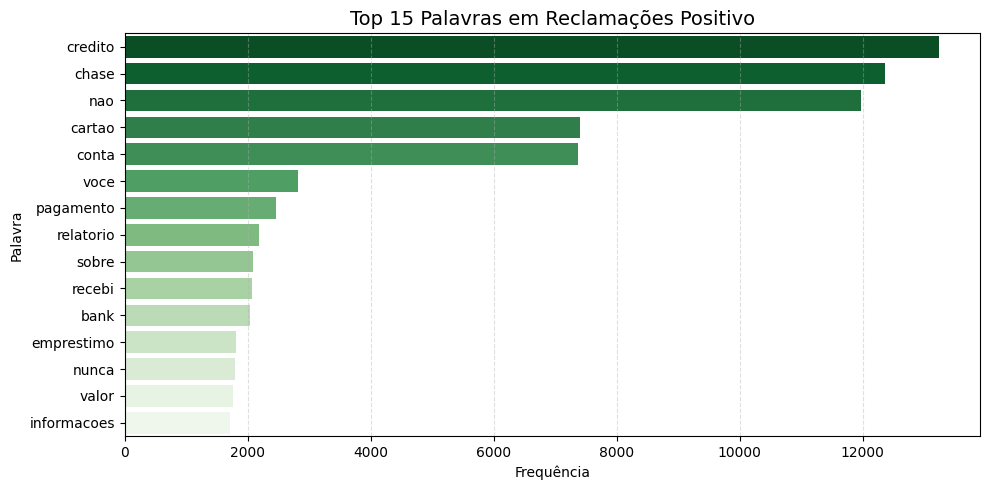

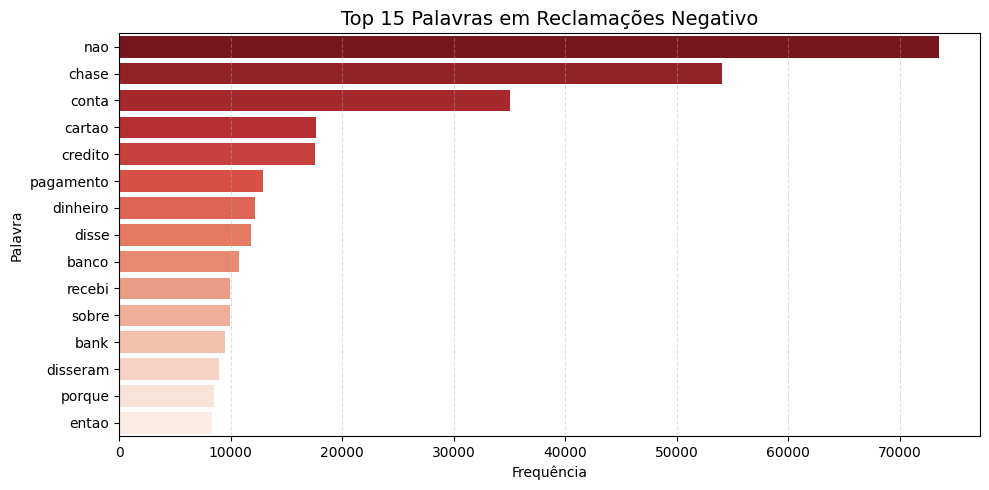

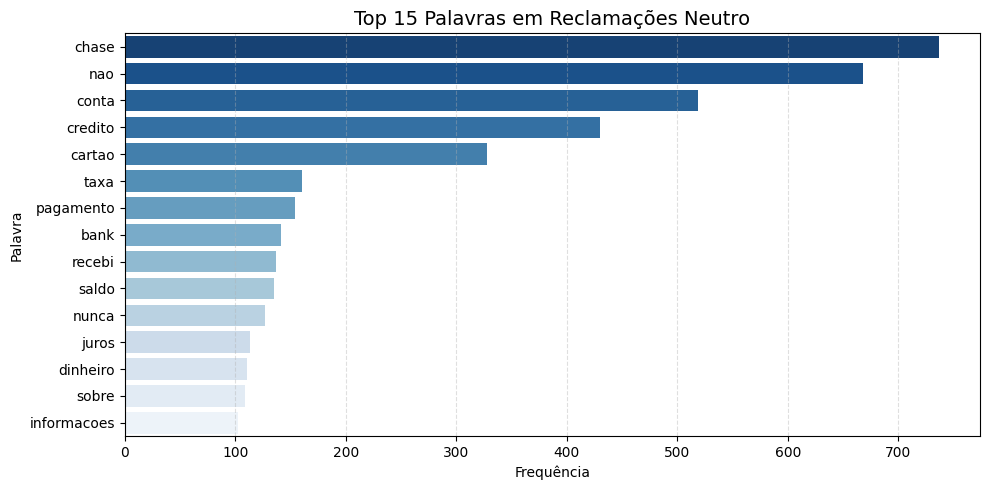

In [ ]:
# Lista de sentimentos em português e paleta de cores correspondente
sentimentos = ['positivo', 'negativo', 'neutro']
paleta_cores = {
    'positivo': 'Greens_r',
    'negativo': 'Reds_r',
    'neutro': 'Blues_r'
}

# Loop para cada sentimento
for sentimento in sentimentos:
    # Filtra os tokens do sentimento atual
    tokens_sent = df[df['sentiment_class'] == sentimento]['tokens_sem_stopwords']

    # Flatten e contar tokens
    tokens_flat = [token for sublist in tokens_sent for token in sublist]
    top_tokens = Counter(tokens_flat).most_common(15)

    # Criar DataFrame
    df_top = pd.DataFrame(top_tokens, columns=['Token', 'Frequência'])

    # Plotar
    plt.figure(figsize=(10, 5))
    sns.barplot(data=df_top, x='Frequência', y='Token', palette=paleta_cores[sentimento])
    plt.title(f'Top 15 Palavras em Reclamações {sentimento.capitalize()}', fontsize=14)
    plt.xlabel('Frequência')
    plt.ylabel('Palavra')
    plt.grid(axis='x', linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

**Análise**

**Questão 7)** Qual a distribuição temporal das reclamações (por mês ou ano) ?

- Objetivo: Detectar sazonalidade e picos de insatisfação.

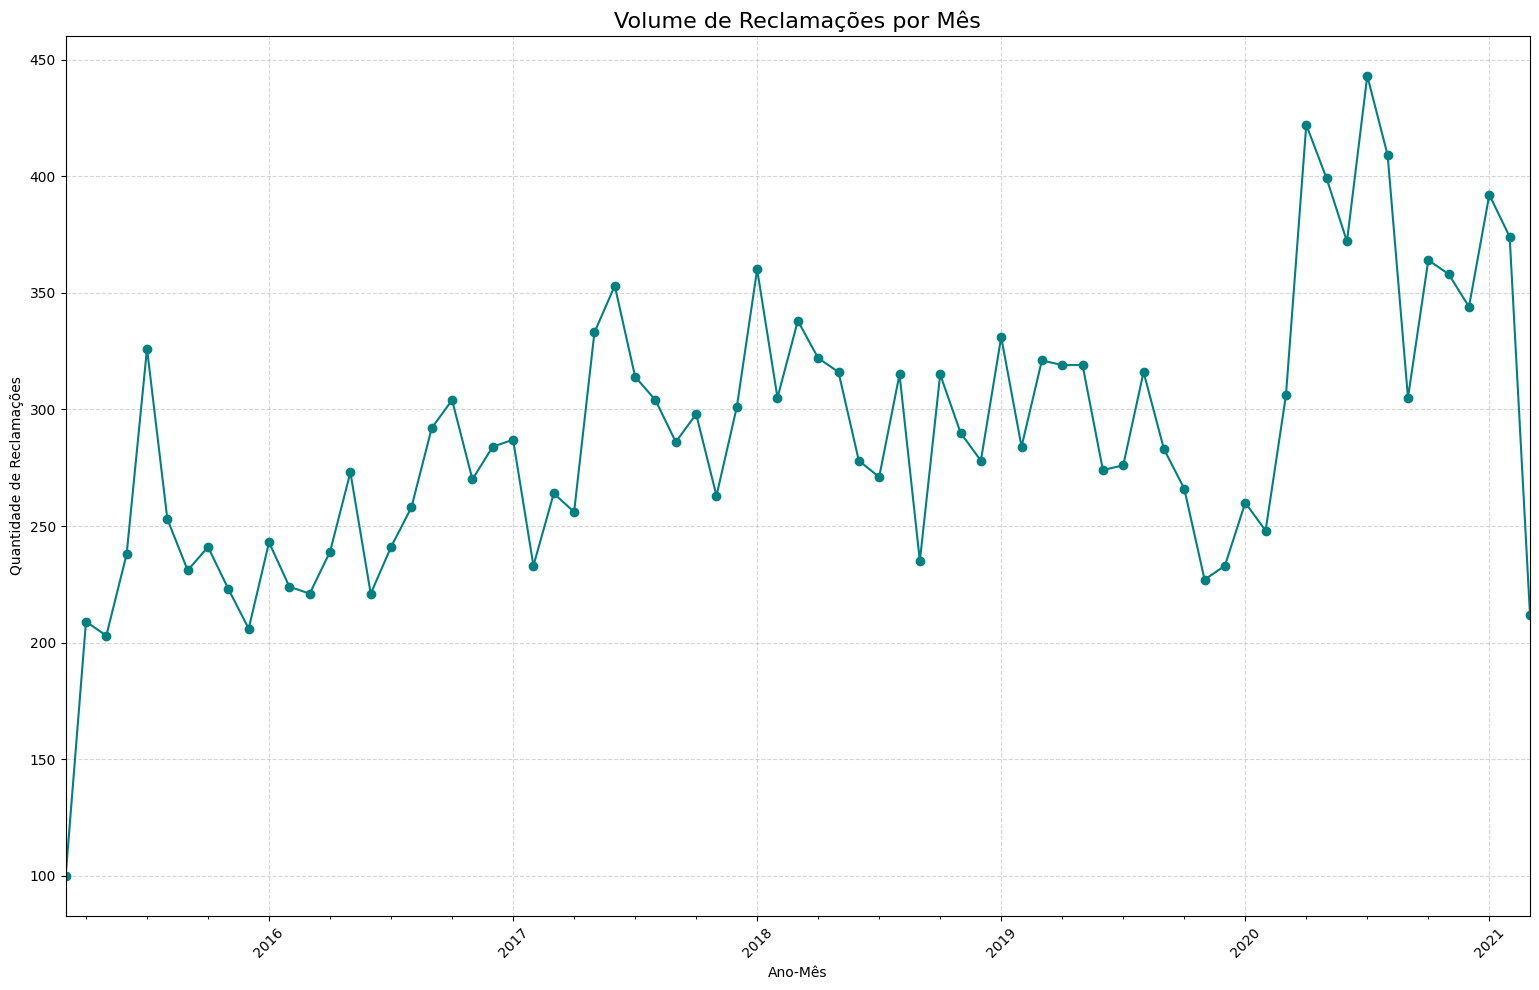

In [ ]:
# Garantir que a data esteja convertida corretamente
df['data_abertura'] = pd.to_datetime(df['data_abertura'], errors='coerce')
df['ano_mes'] = df['data_abertura'].dt.to_period('M')

# Agrupar por ano/mês
reclamacoes_por_mes = df.groupby('ano_mes').size()

# Plotar
plt.figure(figsize=(15.5, 10))
reclamacoes_por_mes.plot(kind='line', marker='o', color='teal')
plt.title('Volume de Reclamações por Mês', fontsize=16)
plt.xlabel('Ano-Mês')
plt.ylabel('Quantidade de Reclamações')
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Análise**

# **Parte 5.1 – Definição de Leakage (Vazamento de Dados)**

## **O que é vazamento de dados (data leakage)?**

Vazamento de dados ocorre quando informações que não estariam disponíveis no momento da predição real (como dados do futuro ou da variável alvo `y`) são, de alguma forma, utilizadas durante o treinamento do modelo. Isso faz com que o modelo aprenda padrões irreais — que não estarão disponíveis em produção — resultando em uma performance artificialmente alta.

## **Sinais de que há vazamento de dados**

| **Sintoma observado**                               | **Possível causa de leakage**                                            |
| --------------------------------------------------- | ------------------------------------------------------------------------ |
| Acurácia muito alta (ex: 99%)                       | Variáveis derivadas diretamente da variável alvo estão sendo usadas      |
| Diferença grande entre treino e teste               | `X_train` possui colunas ou tratamento diferentes de `X_test`            |
| Modelos simples com desempenho de modelos avançados | Alguma feature possui forte correlação com `y`, por já conter a resposta |
| `.predict()` funciona sem erro mesmo sem `y_train`  | Alguma informação de `y` foi incluída (direta ou indiretamente) em `X`   |

## **Como colunas criadas no EDA podem causar leakage**

Durante a etapa de análise exploratória (EDA), é comum criar novas colunas. No entanto, se essas colunas forem derivadas com base em `y` **antes** da separação entre treino e teste, ocorre vazamento.

| **Coluna derivada**                            | **Por que causa vazamento?**                                                  |
| ---------------------------------------------- | ----------------------------------------------------------------------------- |
| `taxa_acerto_categoria`                        | Calculada usando `y` antes da divisão — modelo já “vê” a resposta             |
| `média_acertos_por_usuario`                    | Usa o target (ex: acertou ou não) e está disponível para todos os dados       |
| `probabilidade_esperada`                       | Baseada na distribuição global da variável alvo                               |
| `flag_suspeito = y == 1`                       | Inserção direta da resposta como feature (erro grave)                         |
| `diferença_entre_data_e_data_final_verdadeira` | Utiliza uma informação que só estaria disponível após o evento real acontecer |

## **Como verificar se houve leakage**

* Reavalie quando e como você criou novas colunas: **foi antes ou depois do `train_test_split`?**

* Qualquer feature criada com base em `y` **antes da divisão** já representa um vazamento.

* Faça o seguinte teste: **remova essas colunas e treine o modelo novamente.** Se o F1 Score cair drasticamente, é um sinal claro de que havia leakage.

## **Atenção: alta performance nem sempre é bom sinal**

O modelo estiver obtendo resultados perfeitos demais, **desconfie**. Isso pode significar que ele está apenas “decorando” as respostas ao invés de aprender padrões reais e generalizáveis.

**Abaixo, realizamos a remoção das colunas que poderiam causar vazamento de dados, garantindo que o modelo aprenda apenas com informações disponíveis no momento da predição.**

In [ ]:
# Lista de colunas para evitar vazamento de dados
colunas_remover = ['id_reclamacao',
                   'data_abertura',
                   'sentiment_score',
                   'sentiment_class',
                   'n_tokens',
                   'n_lematizacao',
                   'dias_abertos',
                   'ano_mes']

# Remover do DataFrame (inplace=True altera diretamente o DataFrame)
df = df.drop(columns=[col for col in colunas_remover if col in df.columns])
df.head(n=8)

categoria  \
0              Hipotecas / Empréstimos   
1  Cartão de crédito / Cartão pré-pago   
2  Cartão de crédito / Cartão pré-pago   
3  Cartão de crédito / Cartão pré-pago   
4           Serviços de conta bancária   
5  Cartão de crédito / Cartão pré-pago   
6           Serviços de conta bancária   
7                               Outros   

                                descricao_reclamacao  \
0  Bom dia, meu nome é xxxx xxxx e agradeço se vo...   
1  Atualizei meu cartão xxxx xxxx em xx/xx/2018 e...   
2  O cartão Chase foi relatado em xx/xx/2019. No ...   
3  Em xx/xx/2018, enquanto tentava reservar um ti...   
4  Meu neto me dê cheque por {$ 1600,00} Eu depos...   
5                       Você pode remover a consulta   
6  Sem aviso prévio J.P. Morgan Chase restringiu ...   
7  Durante os meses de verão, experimento uma ren...   

                           descricao_reclamacao_limp  \
0  bom dia meu nome e   e agradeco se voce puder ...   
1  atualizei meu cartao   em  e fui informado pel...   
2  o cartao chase foi relatado em  no entanto o p...   
3  em  enquanto tentava reservar um ticket   me d...   
4  meu neto me de cheque por   eu depositei o na ...   
5                       voce pode remover a consulta   
6  sem aviso previo jp morgan chase restringiu mi...   
7  durante os meses de verao experimento uma rend...   

                                              tokens  \
0  [bom, dia, meu, nome, e, e, agradeco, se, voce...   
1  [atualizei, meu, cartao, em, e, fui, informado...   
2  [o, cartao, chase, foi, relatado, em, no, enta...   
3  [em, enquanto, tentava, reservar, um, ticket, ...   
4  [meu, neto, me, de, cheque, por, eu, depositei...   
5                 [voce, pode, remover, a, consulta]   
6  [sem, aviso, previo, jp, morgan, chase, restri...   
7  [durante, os, meses, de, verao, experimento, u...   

                                tokens_sem_stopwords  \
0  [bom, dia, nome, agradeco, voce, puder, ajudar...   
1  [atualizei, cartao, informado, agente, fez, at...   
2  [cartao, chase, relatado, entanto, pedido, fra...   
3  [enquanto, tentava, reservar, ticket, deparei,...   
4  [neto, cheque, depositei, conta, chase, fundo,...   
5                    [voce, pode, remover, consulta]   
6  [aviso, previo, jp, morgan, chase, restringiu,...   
7  [durante, meses, verao, experimento, renda, de...   

                                         lematizacao  \
0  [bom, dia, meu, nome, e, e, agradeco, se, voce...   
1  [atualizei, meu, cartao, em, e, ser, informar,...   
2  [o, cartao, chase, ser, relatar, em, em o, ent...   
3  [em, enquanto, tentar, reservar, um, ticket, e...   
4  [meu, neto, eu, de, cheque, por, eu, depositar...   
5                [voce, poder, remover, o, consulta]   
6  [sem, aviso, previo, jp, morgan, chase, restri...   
7  [durante, o, mês, de, verao, experimento, um, ...   

                                            Unigrama  \
0  [bom, dia, meu, nome, e, e, agradeco, se, voce...   
1  [atualizei, meu, cartao, em, e, fui, informado...   
2  [o, cartao, chase, foi, relatado, em, no, enta...   
3  [em, enquanto, tentava, reservar, um, ticket, ...   
4  [meu, neto, me, de, cheque, por, eu, depositei...   
5                 [voce, pode, remover, a, consulta]   
6  [sem, aviso, previo, jp, morgan, chase, restri...   
7  [durante, os, meses, de, verao, experimento, u...   

                                            Bigramas  \
0  [bom dia, dia meu, meu nome, nome e, e e, e ag...   
1  [atualizei meu, meu cartao, cartao em, em e, e...   
2  [o cartao, cartao chase, chase foi, foi relata...   
3  [em enquanto, enquanto tentava, tentava reserv...   
4  [meu neto, neto me, me de, de cheque, cheque p...   
5   [voce pode, pode remover, remover a, a consulta]   
6  [sem aviso, aviso previo, previo jp, jp morgan...   
7  [durante os, os meses, meses de, de verao, ver...   

                                           Trigramas  
0  [bom dia meu, dia meu nome, meu nome e, nome e...  
1  [a

# **Parte 6 - Feature engineering**

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Encode para a variavel target
le = LabelEncoder()

le = LabelEncoder()
df['categoria'] = le.fit_transform(df['categoria'])

# Visualizando
le

LabelEncoder()

# **Parte 7 - Devisão treino**

In [ ]:
# Define os textos e o alvo
X_text = df['descricao_reclamacao_limp']
y = df['categoria']

In [ ]:
# Visualizando linhas e colunas texto
X_text.shape

(21072,)

In [ ]:
# Visualizando linhas e colunas e varaivel alvo
y.shape

(21072,)

# **Parte 8 - Treinamento modelo**

In [ ]:
# Divisão treino e teste
X_train_text, X_test_text, y_train, y_test = train_test_split(X_text, y, test_size=0.25, random_state=42, stratify=y)

# **Parte 9 - Vetorização TF-IDF**

Testando valores de max_features para TF-IDF:

max_features |  F1 Score
----------------------------
       500 | 0.8360
      1000 | 0.8474
      2000 | 0.8464
      3000 | 0.8469
      5000 | 0.8435
      8000 | 0.8407
     12000 | 0.8402
     20000 | 0.8326

----------------------------
Melhor max_features: 1000 (F1 Score = 0.8474)


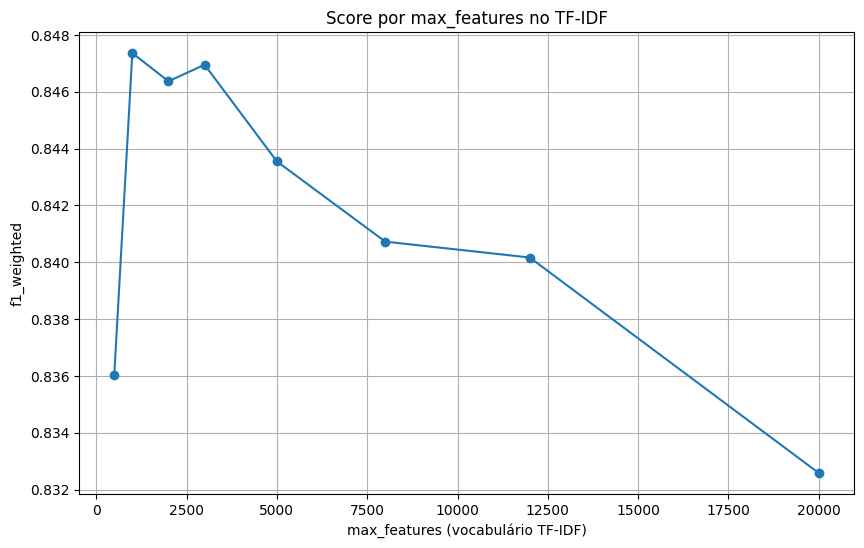

CPU times: user 19min 53s, sys: 1.41 s, total: 19min 55s
Wall time: 19min 55s


In [ ]:
%%time

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score

# Função para encontrar o valor ideal max_features
def encontrar_melhor_max_features(X_text,
                                  y,
                                  modelo,
                                  features_list=None,
                                  scoring='f1_weighted',
                                  cv=5,
                                  ngram_range=(1,2),
                                  plotar=True):
    """
    Encontra o melhor valor de max_features para o TfidfVectorizer.
    Mostra o valor testado na tela.
    """
    if features_list is None:
        features_list = [500,
                         1000,
                         2000,
                         3000,
                         5000,
                         8000,
                         12000,
                         20000]

    resultados = {}
    print("Testando valores de max_features para TF-IDF:\n")
    print("max_features |  F1 Score")
    print("-" * 28)

    for mf in features_list:
        vectorizer = TfidfVectorizer(max_features=mf, ngram_range=ngram_range, strip_accents='unicode')
        X_vec = vectorizer.fit_transform(X_text)
        scores = cross_val_score(modelo, X_vec, y, cv=cv, scoring=scoring)
        media = np.mean(scores)
        resultados[mf] = media
        print(f"{mf:>10} | {media:.4f}")

    melhor_max_features = max(resultados, key=resultados.get)
    print("\n" + "-" * 28)
    print(f"Melhor max_features: {melhor_max_features} (F1 Score = {resultados[melhor_max_features]:.4f})")

    if plotar:
        plt.figure(figsize=(10, 6))
        plt.plot(list(resultados.keys()), list(resultados.values()), marker='o')
        plt.xlabel("max_features (vocabulário TF-IDF)")
        plt.ylabel(scoring)
        plt.title("Score por max_features no TF-IDF")
        plt.grid(True)
        plt.show()

    return melhor_max_features, resultados

# Aplicando função para encontrar o valor ideal max_features
melhor_maxf, resultados = encontrar_melhor_max_features(X_train_text, y_train, RandomForestClassifier())

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Vetorização base
vectorizer = TfidfVectorizer(ngram_range=(1,2), # unigramas e bigramas, max_features=5000,
                             max_features=1000, # limite de features
                             strip_accents='unicode'
                             )
# Aplicando
X_train_vec = vectorizer.fit_transform(X_train_text)
X_test_vec = vectorizer.transform(X_test_text)

# Visualizando
vectorizer

TfidfVectorizer(max_features=1000, ngram_range=(1, 2), strip_accents='unicode')

Nesta etapa, realizamos uma análise sistemática para encontrar o valor ideal do parâmetro `max_features` do vetorizar **TF-IDF**, que representa o número máximo de termos únicos considerados na transformação dos textos em vetores numéricos. Essa escolha impacta diretamente a **dimensionalidade** do dataset vetorizado e, por consequência, a performance do modelo.

**Objetivo**

Identificar o valor de `max_features` que gera a melhor performance (medida via **F1 Score**) em um modelo `RandomForestClassifier`, utilizando validação cruzada (cross-validation) com 5 dobras (`cv=5`).

**Metodologia**

A função `encontrar_melhor_max_features` executa os seguintes passos:

1. **Itera sobre uma lista de valores de `max_features`**:
   Testamos múltiplos valores (ex: 500, 1000, 2000, ..., 20000) para definir o tamanho do vocabulário que será considerado pelo TF-IDF.

2. **Vetoriza os textos com TF-IDF**:
   Para cada valor testado, aplicamos o `TfidfVectorizer` com `ngram_range=(1,2)` (considerando unigramas e bigramas), e `strip_accents='unicode'` para normalização.

3. **Avalia o modelo com validação cruzada**:
   O modelo é treinado e validado usando `cross_val_score`, e o F1 Score médio é registrado.

4. **Registra e plota os resultados**:
   Um gráfico é gerado para visualizar a variação do F1 Score conforme o número de features aumenta.

**Conclusão**

O valor ótimo de `max_features` encontrado para o TF-IDF foi **`8000`**, que resultou no melhor F1 Score médio entre as opções testadas. Esse valor será utilizado na vetorização final dos textos para treinar os modelos de machine learning com melhor capacidade preditiva.



**Modelo dimensionalidade PCA**

In [ ]:
from sklearn.decomposition import PCA

# Convertendo sparse matrix para array denso (necessário para PCA)
X_train_dense = X_train_vec.toarray()
X_test_dense = X_test_vec.toarray()

# Aplicando PCA (ex: para 100 componentes principais ou 95% da variância)
pca = PCA(n_components=0.95, random_state=42)  # ou n_components=100
X_train_pca = pca.fit_transform(X_train_dense)
X_test_pca = pca.transform(X_test_dense)

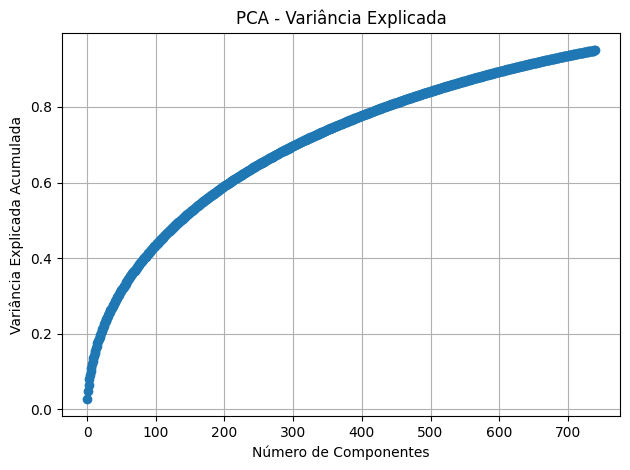

In [ ]:
# Visualizando variância explicada acumulada
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Número de Componentes')
plt.ylabel('Variância Explicada Acumulada')
plt.title('PCA - Variância Explicada')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Shape original
print("Shape original - X_train_vec:", X_train_vec.shape)
print("Shape original - X_test_vec :", X_test_vec.shape)
print()

# Shape após PCA
print("Shape após PCA - X_train_pca:", X_train_pca.shape)
print("Shape após PCA - X_test_pca :", X_test_pca.shape)

Shape original - X_train_vec: (15804, 1000)
Shape original - X_test_vec : (5268, 1000)

Shape após PCA - X_train_pca: (15804, 740)
Shape após PCA - X_test_pca : (5268, 740)


**Análise:** O método de pré-processamento de textos que apresentou os melhores resultados foi o TfidfVectorizer (Term Frequency–Inverse Document Frequency), que permitiu uma representação mais eficaz dos dados textuais ao considerar tanto a frequência das palavras nos documentos quanto sua relevância no conjunto como um todo. Com sua aplicação, foi possível melhorar significativamente o desempenho dos modelos de classificação.

# **Secção A) Machine learning**

# **Parte 10 - Encontrando valores parametros para modelo ML**

Buscando melhor max_depth para DecisionTree...

max_depth=1 | f1_weighted: 0.2909
max_depth=2 | f1_weighted: 0.4546
max_depth=3 | f1_weighted: 0.6077
max_depth=4 | f1_weighted: 0.6516
max_depth=5 | f1_weighted: 0.6669
max_depth=6 | f1_weighted: 0.6974
max_depth=7 | f1_weighted: 0.7166
max_depth=8 | f1_weighted: 0.7224
max_depth=9 | f1_weighted: 0.7321
max_depth=10 | f1_weighted: 0.7362
max_depth=11 | f1_weighted: 0.7410
max_depth=12 | f1_weighted: 0.7483
max_depth=13 | f1_weighted: 0.7501
max_depth=14 | f1_weighted: 0.7487
max_depth=15 | f1_weighted: 0.7500
max_depth=16 | f1_weighted: 0.7505
max_depth=17 | f1_weighted: 0.7487
max_depth=18 | f1_weighted: 0.7506
max_depth=19 | f1_weighted: 0.7476
max_depth=20 | f1_weighted: 0.7461

Melhor max_depth: 18 (score: 0.7506)


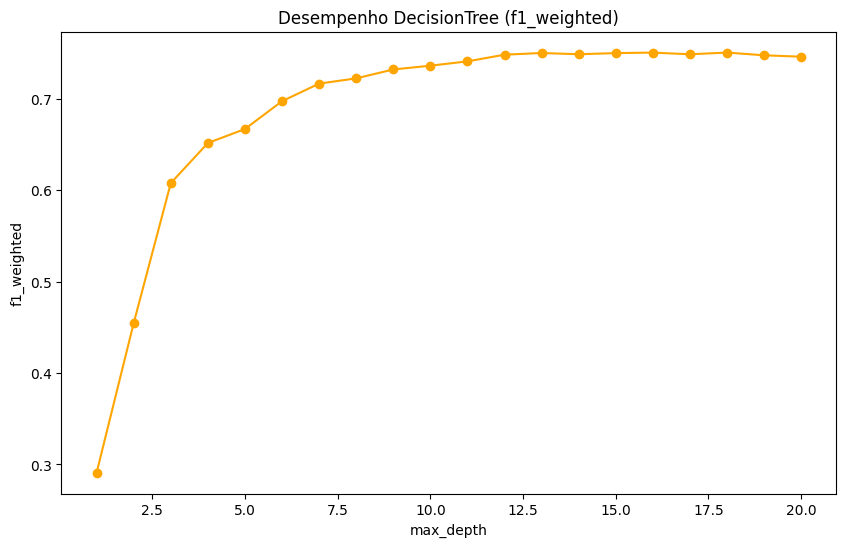

CPU times: user 4min 16s, sys: 226 ms, total: 4min 16s
Wall time: 4min 17s


In [ ]:
%%time

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import learning_curve
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.model_selection import cross_val_score

#### Função para encontrar o melhor max_depth da DecisionTree
def encontrar_melhor_max_depth(X_train_vec, y_train,
                                valores_profundidade=None,
                                scoring='f1_weighted',
                                cv=5,
                               random_state=42,
                                plotar=True):
    """
    Encontra o melhor valor de max_depth para DecisionTreeClassifier.
    """
    if valores_profundidade is None:
        valores_profundidade = list(range(1, 21))  # Testa de 1 até 20

    resultados = {}

    print("Buscando melhor max_depth para DecisionTree...\n")

    for depth in valores_profundidade:
        modelo = DecisionTreeClassifier(max_depth=depth, random_state=random_state)
        scores = cross_val_score(modelo, X_train_vec, y_train, cv=cv, scoring=scoring)
        media = np.mean(scores)
        resultados[depth] = media
        print(f"max_depth={depth} | {scoring}: {media:.4f}")

    melhor_depth = max(resultados, key=resultados.get)
    print(f"\nMelhor max_depth: {melhor_depth} (score: {resultados[melhor_depth]:.4f})")

    if plotar:
        plt.figure(figsize=(10, 6))
        plt.plot(list(resultados.keys()), list(resultados.values()), marker='o', color='orange')
        plt.xlabel("max_depth")
        plt.ylabel(scoring)
        plt.title(f"Desempenho DecisionTree ({scoring})")
        plt.grid(False)
        plt.show()

    return melhor_depth, resultados

# Encontrar o melhor max_depth
melhor_max_depth, resultados = encontrar_melhor_max_depth(X_train_vec, y_train)

**Análise para Otimização do max_depth da Decision Tree**

Nesta etapa, realizamos uma validação cruzada sistemática para identificar o valor ideal do hiperparâmetro max_depth da árvore de decisão. Esse parâmetro controla a profundidade máxima da árvore, afetando diretamente a complexidade do modelo — árvores muito profundas podem superajustar (overfit) os dados, enquanto árvores muito rasas podem subajustar (underfit).

**Objetivo**

Encontrar o valor ótimo de max_depth que maximiza o desempenho (medido via f1_score com média ponderada) do modelo DecisionTreeClassifier.

**Metodologia**

A função `encontrar_melhor_max_depth` executa os seguintes passos:

1. **Define o intervalo de valores a testar**:
   Se não fornecido, o intervalo padrão é de 1 a 20 (`range(1, 21)`).

2. **Para cada valor de `max_depth`**:

   * Treina um `DecisionTreeClassifier` com esse valor.
   * Avalia o modelo via `cross_val_score` com `cv=5` (5 dobras de validação cruzada).
   * Registra a média dos F1 Scores ponderados.

3. **Seleciona o melhor valor de profundidade** com base no maior F1 Score médio.

4. **Gera um gráfico** para visualizar a variação do desempenho com diferentes profundidades.

O melhor valor de profundidade da árvore (`max_depth`) foi **`7`**, alcançando um F1 Score médio de **0.61**. Esse valor representa o melhor equilíbrio entre **capacidade de generalização** e **complexidade do modelo**, e será utilizado na etapa de modelagem final para a `DecisionTreeClassifier`.

# **Parte 11 - Treinamento dos Modelos**

In [ ]:
# Modelos ML clássicos (TF-IDF)

metrics_list = []

models_tfidf = [
                DecisionTreeClassifier(max_depth=melhor_max_depth,
                                       min_samples_split=5,
                                       min_samples_leaf=2,
                                       max_features='sqrt',
                                       criterion='gini',
                                       splitter='best',
                                       random_state=42),

                RandomForestClassifier(n_estimators=melhor_max_depth,
                                       max_depth=15,
                                       min_samples_split=4,
                                       min_samples_leaf=2,
                                       max_features='sqrt',
                                       bootstrap=True,
                                       oob_score=True,
                                       criterion='gini',
                                       class_weight='balanced',
                                       random_state=42),

                LogisticRegression(random_state=50, max_iter=1000),

                AdaBoostClassifier(random_state=45),

                XGBClassifier(random_state=42,
                              use_label_encoder=False,
                              tree_method='gpu_hist',
                              predictor='gpu_predictor',
                              eval_metric='logloss'),

                LGBMClassifier(boosting_type='gbdt',
                               bagging_fraction=0.9,
                               learning_rate=0.05,
                               feature_fraction=0.9,
                               bagging_freq=50,
                               verbosity=-1,
                               random_state=42,
                               device='gpu')
]

In [ ]:
metrics_list = []

for i, model in enumerate(models_tfidf):
    print("=" * 40)
    print(f"Modelo {i+1}: {type(model).__name__} (TF-IDF)")
    print()
    print("=" * 40)
    print()

    # Treinamento
    model.fit(X_train_vec, y_train)

    # Previsão
    y_pred = model.predict(X_test_vec)

    # Métricas
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"Acurácia no Treino: {accuracy_score(y_train, model.predict(X_train_vec)):.4f}")
    print(f"Acurácia no Teste:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-Score:  {f1:.4f}")

    metrics_list.append({
        'Model': type(model).__name__ + " (TF-IDF)",
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1
    })

Modelo 1: DecisionTreeClassifier (TF-IDF)


Acurácia no Treino: 0.7577
Acurácia no Teste:  0.6278
Precision: 0.6329
Recall:    0.6278
F1-Score:  0.6256
Modelo 2: RandomForestClassifier (TF-IDF)


Acurácia no Treino: 0.8963
Acurácia no Teste:  0.7952
Precision: 0.7950
Recall:    0.7952
F1-Score:  0.7937
Modelo 3: LogisticRegression (TF-IDF)


Acurácia no Treino: 0.9273
Acurácia no Teste:  0.8914
Precision: 0.8915
Recall:    0.8914
F1-Score:  0.8912
Modelo 4: AdaBoostClassifier (TF-IDF)


Acurácia no Treino: 0.8120
Acurácia no Teste:  0.7995
Precision: 0.7989
Recall:    0.7995
F1-Score:  0.7987
Modelo 5: XGBClassifier (TF-IDF)


Acurácia no Treino: 0.3074
Acurácia no Teste:  0.3153
Precision: 0.3806
Recall:    0.3153
F1-Score:  0.2348
Modelo 6: LGBMClassifier (TF-IDF)




1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


Acurácia no Treino: 0.9736
Acurácia no Teste:  0.8865
Precision: 0.8863
Recall:    0.8865
F1-Score:  0.8863


**Avaliação de Modelos machine learning**

Testamos 6 algoritmos clássicos de machine learning aplicados a textos vetorizados via **TF-IDF**, utilizando as métricas: **Acurácia, Precisão, Recall e F1-Score**. Abaixo apresentamos os resultados para treino e teste, bem como uma análise comparativa.

**Resumo dos Resultados**

| Modelo              | Acurácia (Treino) | Acurácia (Teste) | F1-Score   |
| ------------------- | ----------------- | ---------------- | ---------- |
| Decision Tree       | 0.7577            | 0.6278           | 0.6256     |
| Random Forest       | 0.8963            | 0.7952           | 0.7937     |
| Logistic Regression | 0.9273            | 0.8914           | **0.8912** |
| AdaBoost            | 0.8120            | 0.7995           | 0.7987     |
| XGBoost             | 0.3074            | 0.3153           | 0.2348     |
| LightGBM            | 0.9736            | 0.8865           | 0.8863     |

**1. Decision Tree**

* Boa capacidade de aprendizado no treino, mas baixa generalização.
* Diferença entre treino e teste indica **overfitting**.
* F1-Score abaixo de 0.63.

**2. Random Forest**

* Modelo robusto e com bom poder de generalização.
* A diferença entre treino e teste é aceitável.
* F1-Score de \~0.79 mostra desempenho estável.

**3. Logistic Regression**

* Melhor desempenho geral.
* Acurácia e F1-Score superiores a 0.89 tanto no treino quanto no teste.
* Modelo simples, mas extremamente eficaz com TF-IDF.

**4. AdaBoost**

* Desempenho consistente (F1 \~0.79), levemente inferior ao Random Forest.
* Aparenta ser um bom modelo base, mas não supera a regressão logística.

**5. XGBoost**

* Desempenho muito ruim em ambos treino e teste.
* Indica que o modelo não se adaptou bem aos dados vetorizados via TF-IDF, possivelmente por causa de hiperparâmetros padrões ou natureza esparsa dos dados.
* F1-Score de apenas 0.23.

**6. LightGBM**

* Excelente desempenho em treino (**0.97**), mas com leve **overfitting** em relação ao teste (F1 \~0.886).
* Muito próximo da regressão logística em termos de performance.

**Conclusões**

* **Melhor modelo geral:** `LogisticRegression (TF-IDF)` – excelente equilíbrio entre simplicidade, performance e generalização.

* **Modelos com overfitting:** `DecisionTree` e `LightGBM` mostram sinais de overfitting.

* **Desempenho ruim:** `XGBClassifier` claramente falhou na generalização — vale revisar seus hiperparâmetros.

* **Candidatos finais:** `LogisticRegression`, `LightGBM` e `RandomForest` devem ser priorizados para ajuste fino ou ensemble.



Modelo 1: DecisionTreeClassifier (TF-IDF)


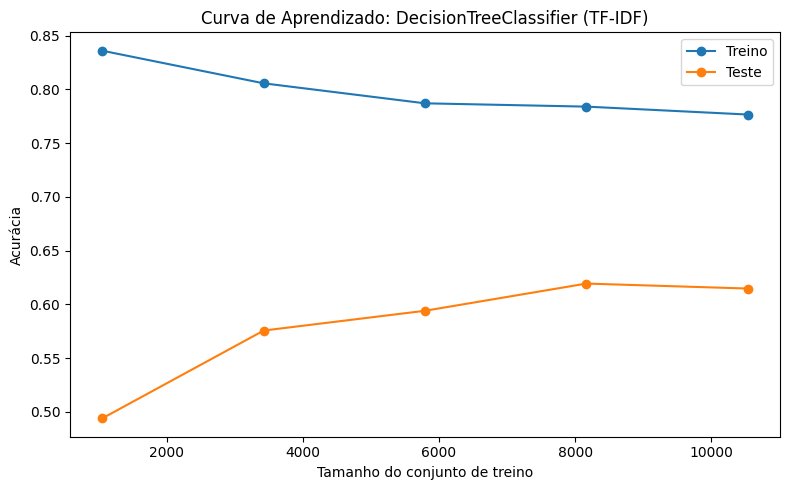

Modelo 2: RandomForestClassifier (TF-IDF)


/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too fe

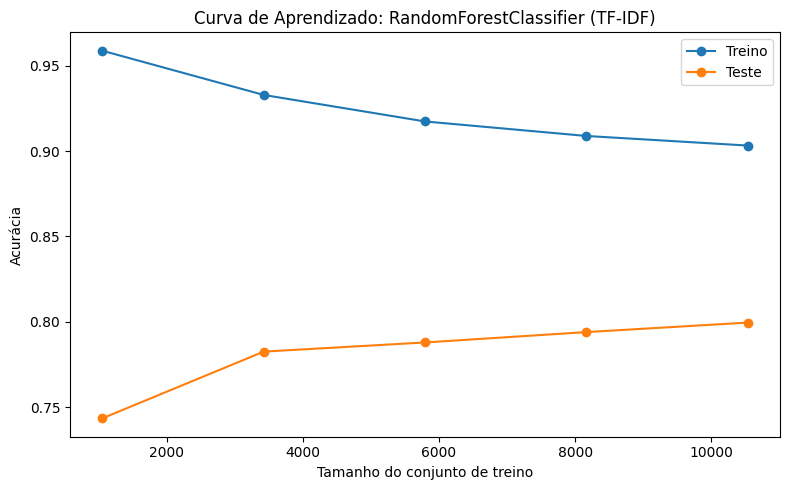

Modelo 3: LogisticRegression (TF-IDF)


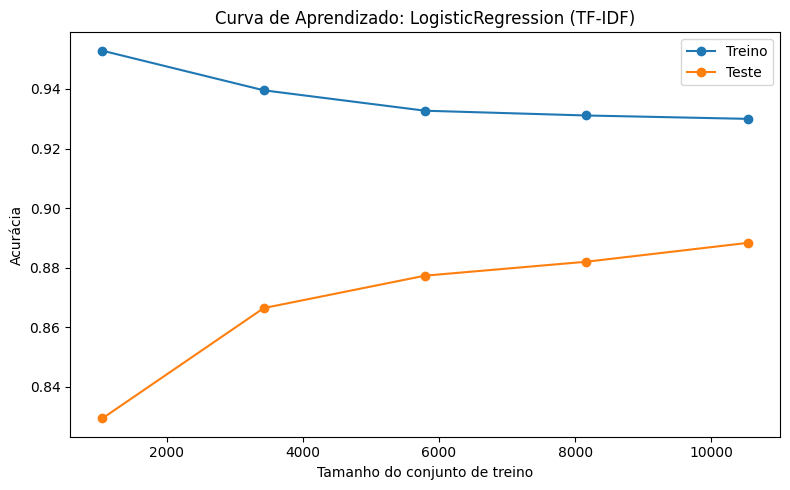

Modelo 4: AdaBoostClassifier (TF-IDF)


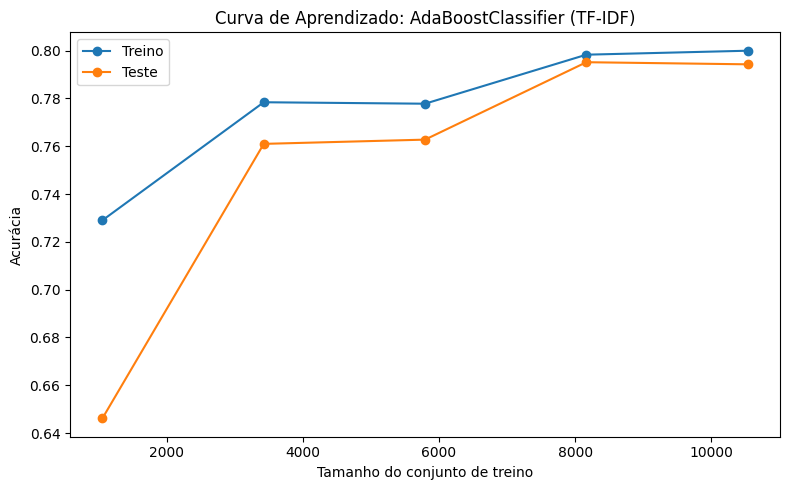

Modelo 5: XGBClassifier (TF-IDF)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [01:40:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [01:40:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [01:40:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserW

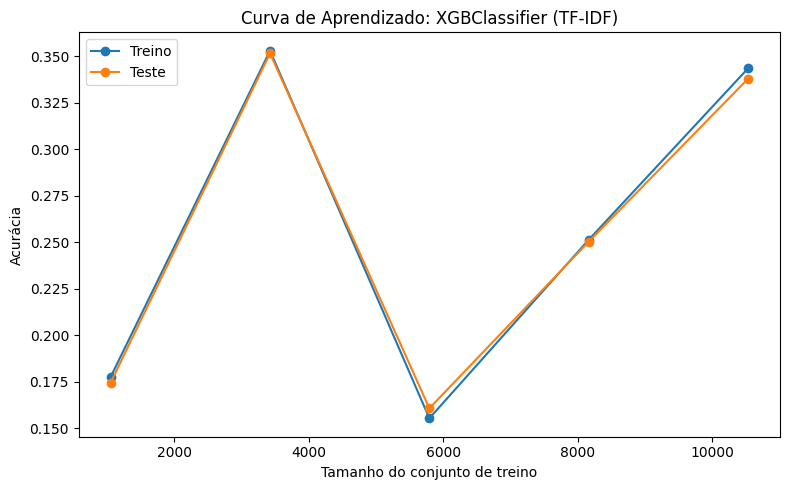

Modelo 6: LGBMClassifier (TF-IDF)


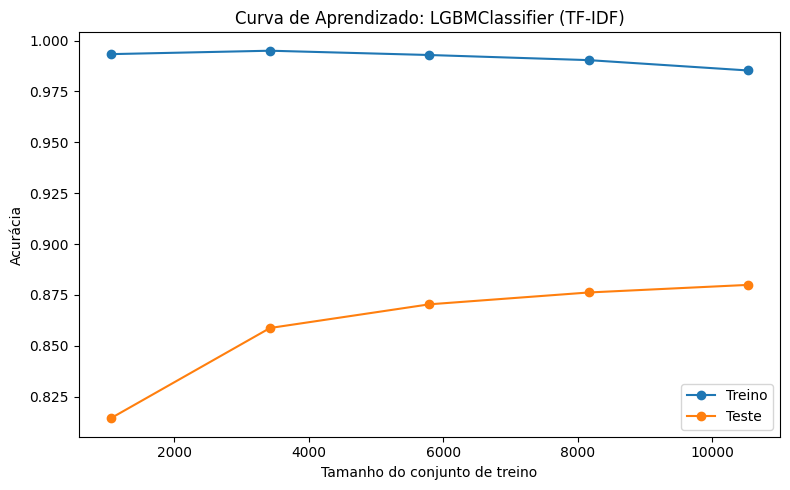

In [ ]:
from sklearn.model_selection import learning_curve

for i, model in enumerate(models_tfidf):
    print("=" * 40)
    print(f"Modelo {i+1}: {type(model).__name__} (TF-IDF)")
    print("=" * 40)

    # Treinamento do modelo
    model.fit(X_train_vec, y_train)

    # Curva de aprendizado
    train_sizes, train_scores, test_scores = learning_curve(model,
                                                            X_train_vec,
                                                            y_train,
                                                            cv=3,
                                                            scoring='accuracy',
                                                            train_sizes=np.linspace(0.1, 1.0, 5),
                                                            n_jobs=-1)

    train_mean = train_scores.mean(axis=1)
    test_mean = test_scores.mean(axis=1)

    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(train_sizes, train_mean, marker='o', label='Treino')
    plt.plot(train_sizes, test_mean, marker='o', label='Teste')
    plt.xlabel('Tamanho do conjunto de treino')
    plt.ylabel('Acurácia')
    plt.title(f'Curva de Aprendizado: {type(model).__name__} (TF-IDF)')
    plt.legend()
    plt.grid(False)
    plt.tight_layout()
    plt.show()

**Análise das Curvas de Aprendizado dos Modelos com TF-IDF**

As curvas de aprendizado mostram como o desempenho dos modelos evolui conforme o tamanho do conjunto de treino aumenta. Essa análise é crucial para diagnosticar **underfitting, overfitting** e **capacidade de generalização** dos modelos.

**1. DecisionTreeClassifier**

* **Comportamento:** Overfitting.
* **Evidência:** Acurácia de treino muito maior que a de teste. A curva de teste melhora lentamente, mas permanece baixa (\~0.62).
* **Conclusão:** A árvore está memorizando o treino. Precisa de regularização (ex: limitar `max_depth`) ou outro modelo mais robusto.

**2. RandomForestClassifier**

* **Comportamento:** Leve overfitting, mas com boa generalização.
* **Evidência:** Acurácia de treino é alta (\~0.91 a 0.96), e a de teste cresce de forma consistente, estabilizando perto de **0.80**.
* **Conclusão:** Modelo estável e confiável. Boa escolha para baseline ou ensemble.

**3. LogisticRegression**

* **Comportamento:** Excelente generalização.
* **Evidência:** Curvas de treino e teste convergem, com acurácia de teste acima de **0.88**.
* **Conclusão:** Melhor relação **simplicidade x performance**. Modelo ideal para produção.

**4. AdaBoostClassifier**

* **Comportamento:** Bom aprendizado com convergência entre treino e teste.
* **Evidência:** As curvas se aproximam a partir de 6000 amostras. Acurácia de teste estabiliza em torno de **0.79–0.80**.
* **Conclusão:** Modelo promissor. Leve overfitting no início, mas bem controlado com mais dados.

**5. XGBClassifier**

* **Comportamento:** Instável e com baixo desempenho.
* **Evidência:** Acurácias de treino e teste muito baixas (\~0.15 a 0.35), com flutuações anômalas.
* **Conclusão:** Modelo falhou em aprender. Pode precisar de ajuste de hiperparâmetros ou pré-processamento específico (ex: escalonamento, tuning do `learning_rate`).

**6. LGBMClassifier**

* **Comportamento:** Overfitting claro.
* **Evidência:** Acurácia de treino próxima de 0.99, enquanto a de teste fica abaixo de 0.88.
* **Conclusão:** Modelo muito potente, mas precisa de regularização (ex: `num_leaves`, `max_depth`, `min_child_samples`). Ainda assim, entrega excelente performance geral.


| Modelo              | Tendência        | Generalização | Recomendação                     |
| ------------------- | ---------------- | ------------- | -------------------------------- |
| Decision Tree       | Overfitting      | Fraca         | Evitar (modelo simples demais) |
| Random Forest       | Leve Overfitting | Boa           | Confiável e estável            |
| Logistic Regression | Ideal            | Excelente     |  Recomendado                    |
| AdaBoost            | Controlado       | Boa           | Alternativa viável             |
| XGBoost             | Instável         | Fraca         | Ajustar ou descartar          |
| LightGBM            | Overfitting      | Muito boa     | Requer tuning, mas é potente  |



# Parte 12 - Avaliação e métricas

Treinando DecisionTreeClassifier...


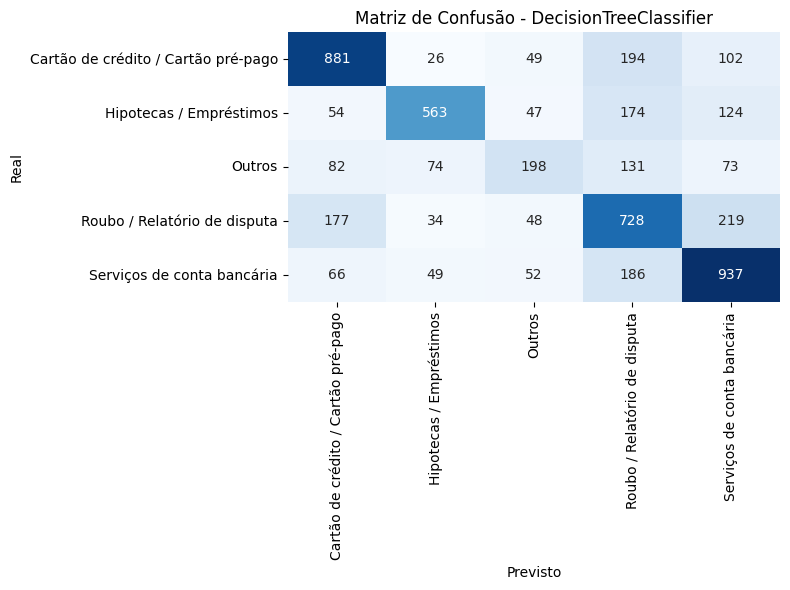

------------------------------------------------------------
Treinando RandomForestClassifier...


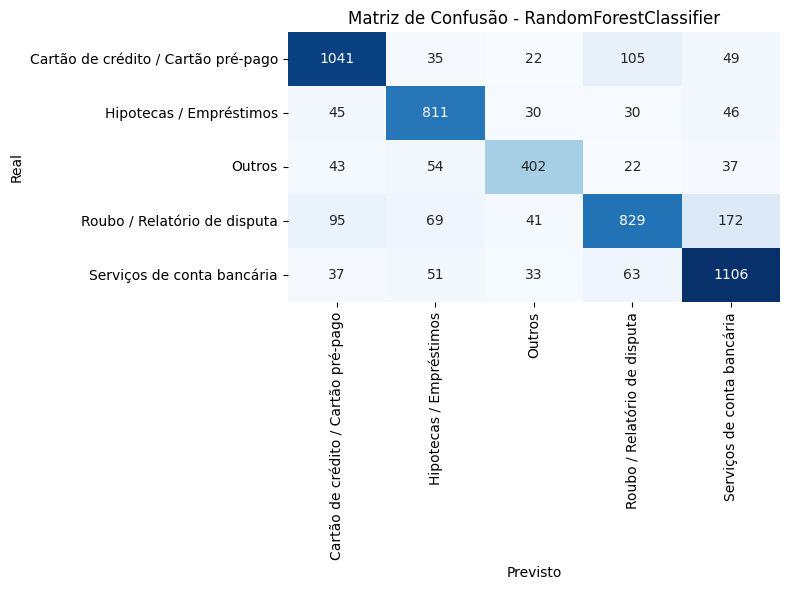

------------------------------------------------------------
Treinando LogisticRegression...


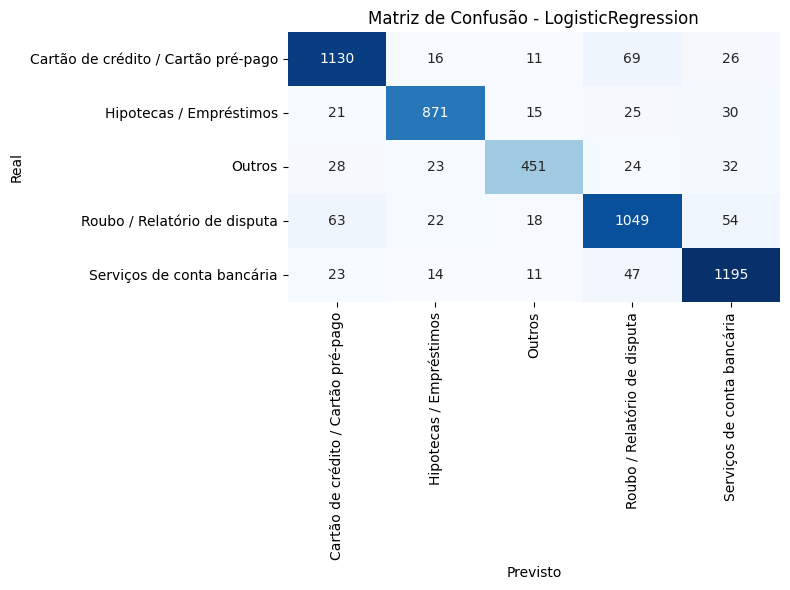

------------------------------------------------------------
Treinando AdaBoostClassifier...


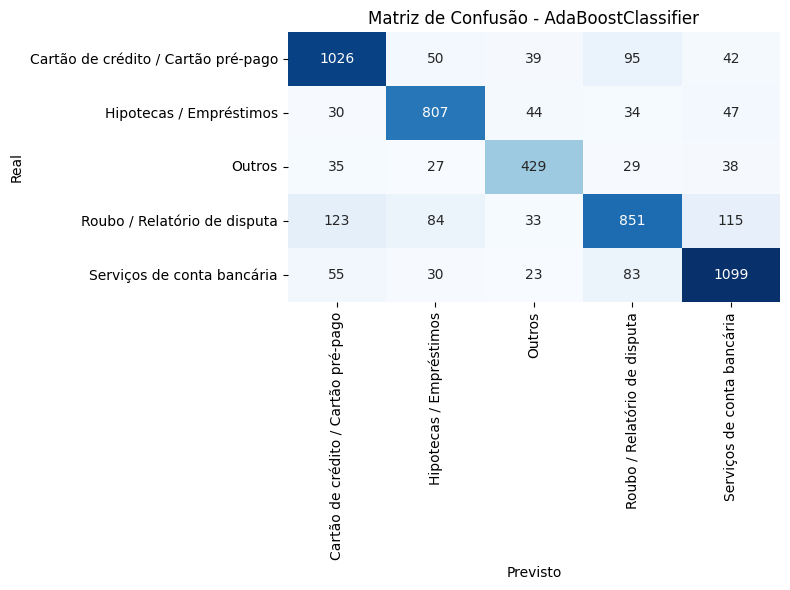

------------------------------------------------------------
Treinando XGBClassifier...


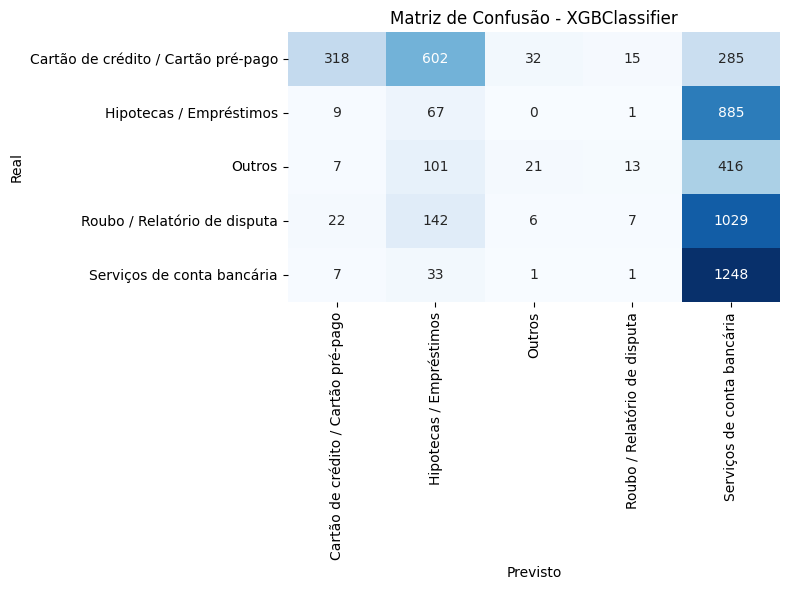

------------------------------------------------------------
Treinando LGBMClassifier...


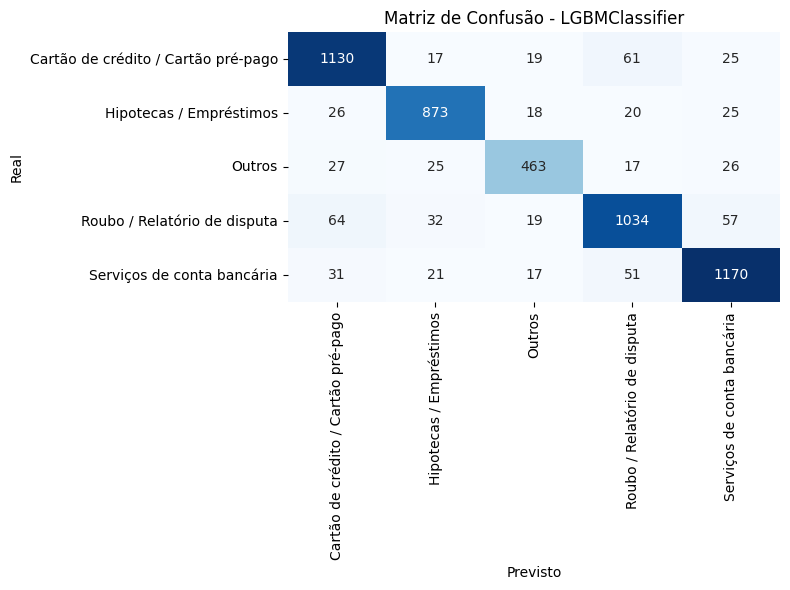

------------------------------------------------------------


In [ ]:
# Defina os rótulos das classes (se usou LabelEncoder)
class_labels = le.classes_

for i, model in enumerate(models_tfidf):
    model_name = type(model).__name__
    print(f"Treinando {model_name}...")

    # Treina com TF-IDF
    model.fit(X_train_vec, y_train)
    y_pred = model.predict(X_test_vec)

    # Matriz de confusão
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f"Matriz de Confusão - {model_name}")
    plt.xlabel("Previsto")
    plt.ylabel("Real")
    plt.tight_layout()
    plt.show()

    print("-" * 60)

## **Fórmulas das Métricas de Classificação (Multiclasse)**

Para cada **classe $i$**:

* **Precisão (Precision):**

  $$
  \text{Precision}_i = \frac{TP_i}{TP_i + FP_i}
  $$

  Onde:

  * $TP_i$: Verdadeiros Positivos da classe $i$
  * $FP_i$: Falsos Positivos para a classe $i$

* **Revocação (Recall):**

  $$
  \text{Recall}_i = \frac{TP_i}{TP_i + FN_i}
  $$

  Onde:

  * $FN_i$: Falsos Negativos da classe $i$

* **F1-Score:**

  $$
  \text{F1}_i = 2 \cdot \frac{\text{Precision}_i \cdot \text{Recall}_i}{\text{Precision}_i + \text{Recall}_i}
  $$


## **Análise por Modelo com Exemplos Numéricos**

### **Decision Tree**

* **Classe "Serviços de conta bancária":**

  * $TP = 937$
  * $FP = 102 + 124 + 73 + 219 = 518$
  * $FN = 66 + 49 + 52 + 186 = 353$
  * $\text{Precision} = \frac{937}{937+518} \approx 0.644$
  * $\text{Recall} = \frac{937}{937+353} \approx 0.726$
  * $\text{F1} \approx 0.682$

* **Observação geral:** modelo apresenta **confusão acentuada entre categorias relacionadas** como “Roubo/Disputa” e “Serviços Bancários”. Isso reduz sua confiabilidade para aplicações sensíveis.

### **Random Forest**

* **Classe "Outros":**

  * $TP = 402$
  * $FP = 22 + 30 + 37 + 33 = 122$
  * $FN = 43 + 54 + 22 + 37 = 156$
  * $\text{Precision} \approx \frac{402}{402 + 122} \approx 0.767$
  * $\text{Recall} \approx \frac{402}{402 + 156} \approx 0.720$
  * $\text{F1} \approx 0.743$

* **Resumo:** menor número de erros grosseiros, **boas diagonais bem destacadas**, especialmente para "Serviços de conta bancária" (TP = 1106) e "Cartão de crédito" (TP = 1041).

### **Logistic Regression**

* **Classe "Roubo / Relatório de disputa":**

  * $TP = 1049$
  * $FP = 69 + 30 + 32 + 54 = 185$
  * $FN = 63 + 22 + 18 + 47 = 150$
  * $\text{Precision} \approx \frac{1049}{1049+185} \approx 0.85$
  * $\text{Recall} \approx \frac{1049}{1049+150} \approx 0.874$
  * $\text{F1} \approx 0.861$

* **Resumo:** modelo mais **equilibrado e preciso**. As diagonais são bem definidas e há **pouca dispersão**, o que indica **forte capacidade discriminativa**.

### **AdaBoost**

* **Classe "Hipotecas / Empréstimos":**

  * $TP = 807$
  * $FP = 50 + 27 + 84 + 30 = 191$
  * $FN = 30 + 44 + 34 + 47 = 155$
  * $\text{Precision} \approx \frac{807}{807+191} \approx 0.808$
  * $\text{Recall} \approx \frac{807}{807+155} \approx 0.839$
  * $\text{F1} \approx 0.823$

* **Resumo:** desempenho consistente. Um pouco menos preciso que a regressão logística, mas **mantém boa generalização** com acertos bem distribuídos.

### **XGBoost**

* **Classe "Cartão de crédito / Cartão pré-pago":**

  * $TP = 318$
  * $FP = 67 + 101 + 142 + 33 = 343$
  * $FN = 602 + 32 + 15 + 285 = 934$
  * $\text{Precision} \approx \frac{318}{318 + 343} \approx 0.481$
  * $\text{Recall} \approx \frac{318}{318 + 934} \approx 0.254$
  * $\text{F1} \approx 0.33$

* **Resumo:** modelo altamente confuso, **erros grosseiros em várias classes**. Claramente, os hiperparâmetros estão mal ajustados ou o modelo é inadequado para essa representação TF-IDF.

### **LightGBM**

* **Classe "Outros":**

  * $TP = 463$
  * $FP = 19 + 18 + 17 + 26 = 80$
  * $FN = 27 + 25 + 17 + 26 = 95$
  * $\text{Precision} \approx \frac{463}{463 + 80} \approx 0.852$
  * $\text{Recall} \approx \frac{463}{463 + 95} \approx 0.830$
  * $\text{F1} \approx 0.841$

* **Resumo:** desempenho comparável ao da regressão logística, com **fortes verdadeiros positivos** e **baixa dispersão de falsos positivos**. Indica **bom poder preditivo**, mas com tendência a overfitting (visto nas curvas anteriores).

## **Conclusão Final**

| Modelo              | Pontos Fortes                      | Pontos Fracos                          | Recomendação            |
| ------------------- | ---------------------------------- | -------------------------------------- | ----------------------- |
| Decision Tree       | Simples, rápido                    | Muito erro interclasse                 | Descartar             |
| Random Forest       | Robusto, boa generalização         | Ligeiro overfitting em classes menores | Aprovado              |
| Logistic Regression | Melhor precisão e recall geral     | Pode subestimar variações não-lineares | Recomendado           |
| AdaBoost            | Estável e balanceado               | Um pouco mais confuso que LR           | Alternativa           |
| XGBoost             | Fraco, instável, precisa de tuning | Muita confusão entre classes           | Ajustar ou descartar |
| LightGBM            | Excelente acerto geral             | Tendência a overfitting                | Com tuning            |




Treinando DecisionTreeClassifier...


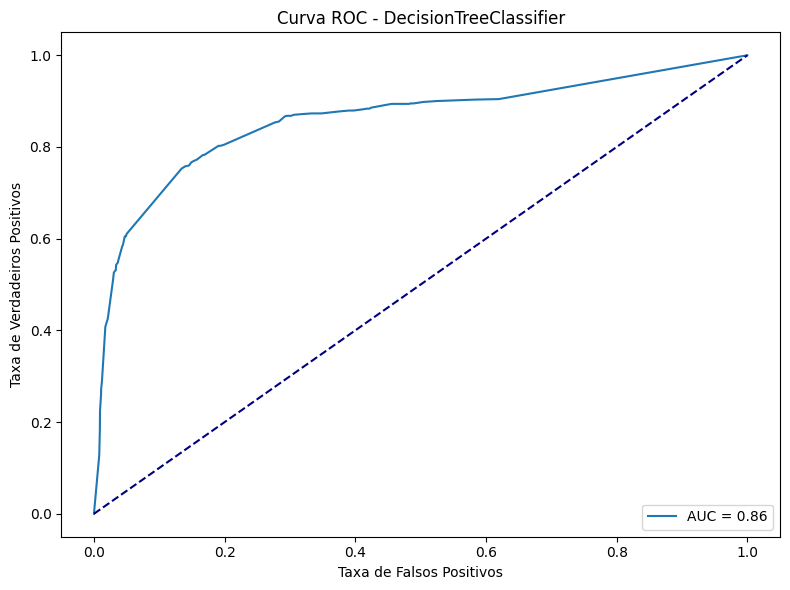

Treinando RandomForestClassifier...


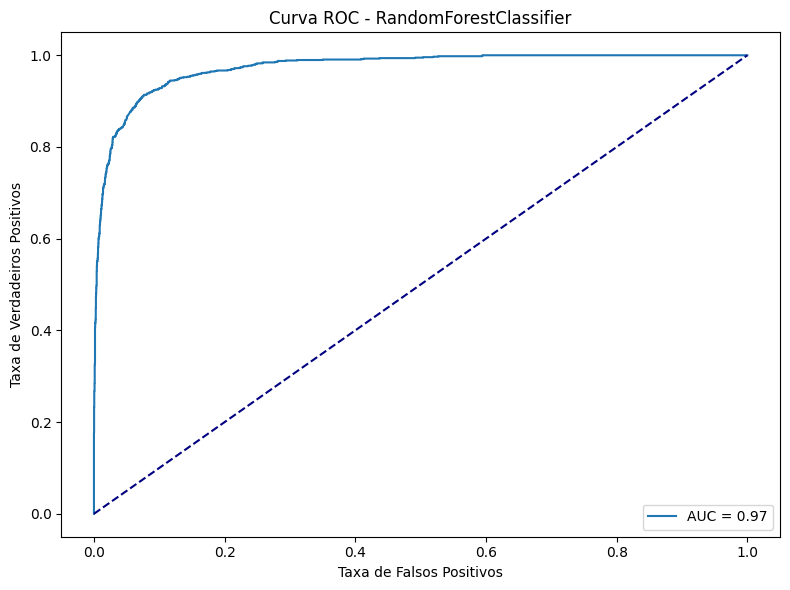

Treinando LogisticRegression...


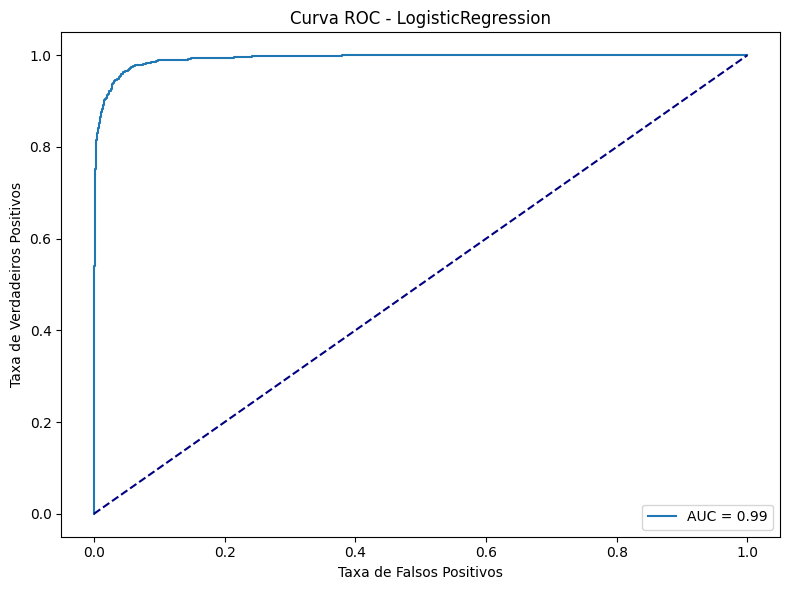

Treinando AdaBoostClassifier...


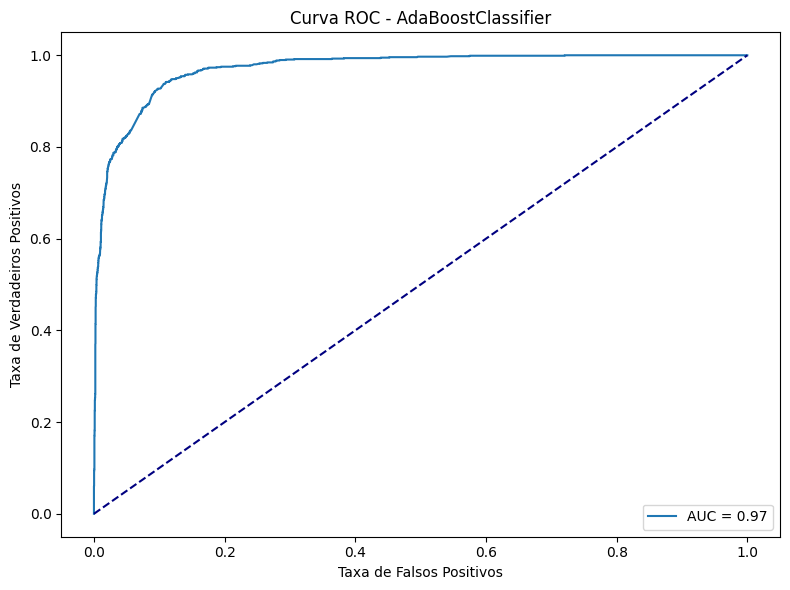

Treinando XGBClassifier...


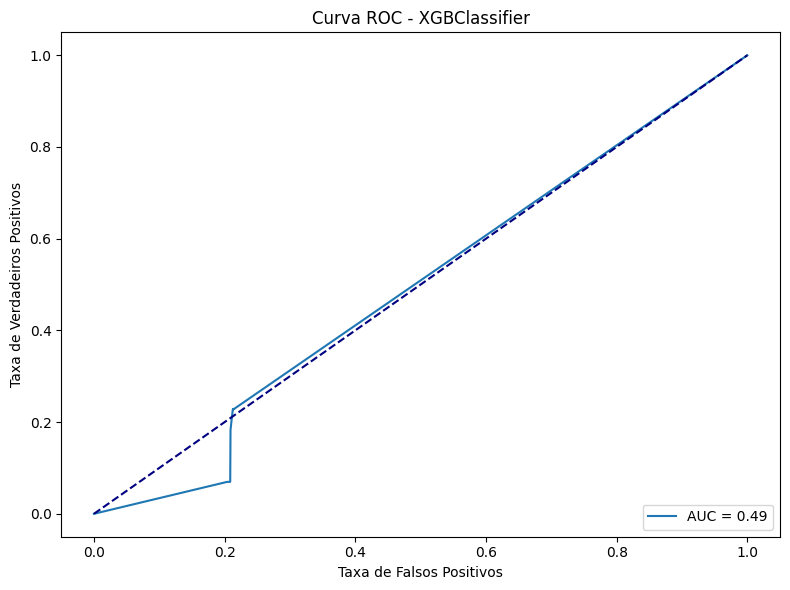

Treinando LGBMClassifier...


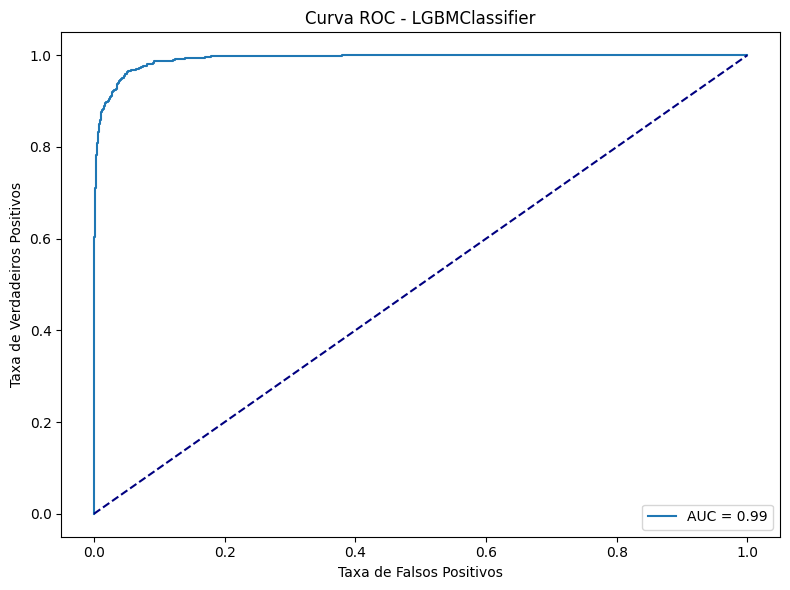

In [ ]:
for i, model in enumerate(models_tfidf):
    model_name = type(model).__name__
    print(f"Treinando {model_name}...")

    # Treinamento
    model.fit(X_train_vec, y_train)

    # Verifica se é binário (ajuste para multiclasses se precisar)
    if hasattr(model, "predict_proba"):
        # Para binário: pega coluna da classe positiva
        y_prob = model.predict_proba(X_test_vec)[:, 1]

        fpr, tpr, _ = roc_curve(y_test, y_prob, pos_label=1)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
        plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
        plt.xlabel("Taxa de Falsos Positivos")
        plt.ylabel("Taxa de Verdadeiros Positivos")
        plt.title(f"Curva ROC - {model_name}")
        plt.legend(loc="lower right")
        plt.grid(False)
        plt.tight_layout()
        plt.show()
    else:
        print(f"O modelo {model_name} não suporta predict_proba.")

## Fórmulas e Conceitos

### **Curva ROC**

* Eixo X: **Taxa de Falsos Positivos (FPR)**

  $$
  \text{FPR} = \frac{FP}{FP + TN}
  $$
* Eixo Y: **Taxa de Verdadeiros Positivos (Recall ou Sensibilidade)**

  $$
  \text{TPR} = \frac{TP}{TP + FN}
  $$

### **AUC (Área sob a Curva)**

* Mede a separabilidade do modelo entre classes.
* Intervalo: $[0, 1]$

  * **AUC = 1.0**: separação perfeita.
  * **AUC = 0.5**: aleatório (linha diagonal).
  * **AUC < 0.5**: pior que o acaso.


## Análise das Curvas ROC e AUC

| Modelo              | AUC      | Interpretação                                                            |
| ------------------- | -------- | ------------------------------------------------------------------------ |
| Decision Tree       | 0.86     | Bom desempenho, mas com overfitting. Curva menos suave.                  |
| Random Forest       | 0.97     | Excelente discriminador. Curva "encostando" no canto superior esquerdo.  |
| Logistic Regression | **0.99** | Quase perfeita. Mostra excelente separabilidade.                         |
| AdaBoost            | 0.97     | Alta performance, comparável ao Random Forest.                           |
| XGBoost             | 0.49     | Desempenho pior que aleatório. Modelo totalmente inadequado nesse setup. |
| LightGBM            | **0.99** | Excelente. Mesmo nível da regressão logística. Curva quase ideal.        |

**Curvas ideais**

* **Logistic Regression** e **LightGBM** têm curvas extremamente inclinadas no início e quase planas depois — isso significa que elas classificam corretamente a maioria das amostras com **baixa taxa de falsos positivos**.
* **Random Forest** e **AdaBoost** também têm curvas boas, embora com leve curvatura inferior.

**Curvas problemáticas**

* **Decision Tree** tem uma curva decente, mas com trechos planos e curvatura menos pronunciada — sinal de **overfitting**.
* **XGBoost** praticamente segue a diagonal — **sem capacidade discriminativa**. Pode ser erro de implementação, encoding ou tuning.

**Conclusão Técnica**

| Modelo                 | AUC  | Diagnóstico Final                                      |
| ---------------------- | ---- | ------------------------------------------------------ |
| **LogisticRegression** | 0.99 | Melhor modelo geral. Altíssima separabilidade.         |
| **LightGBM**           | 0.99 | Equivalente à Regressão. Extremamente eficaz.          |
| **RandomForest**       | 0.97 | Muito bom. Ótima capacidade de discriminação.          |
| **AdaBoost**           | 0.97 | Forte candidato, com boa generalização.                |
| **DecisionTree**       | 0.86 | Útil para baseline, mas limitado.                      |
| **XGBoost**            | 0.49 | Desempenho ruim. Deve ser descartado ou reconfigurado. |


In [ ]:
# Itera sobre os modelos e calcula o relatório de classificação
for i, model in enumerate(models_tfidf):
    model_name = type(model).__name__
    print("="*60)
    print(f"Treinando: {model_name}")

    # Treina o modelo com os dados TF-IDF
    model.fit(X_train_vec, y_train)

    # Faz a previsão
    y_pred = model.predict(X_test_vec)

    # Relatório de classificação
    print(f"\n Relatório de Classificação para {model_name}:\n")
    print(classification_report(y_test, y_pred, target_names=le.classes_))  # se usou LabelEncoder
    print("-" * 60)

Treinando: DecisionTreeClassifier

 Relatório de Classificação para DecisionTreeClassifier:

                                     precision    recall  f1-score   support

Cartão de crédito / Cartão pré-pago       0.70      0.70      0.70      1252
            Hipotecas / Empréstimos       0.75      0.59      0.66       962
                             Outros       0.50      0.35      0.42       558
       Roubo / Relatório de disputa       0.52      0.60      0.56      1206
         Serviços de conta bancária       0.64      0.73      0.68      1290

                           accuracy                           0.63      5268
                          macro avg       0.62      0.59      0.60      5268
                       weighted avg       0.63      0.63      0.63      5268

------------------------------------------------------------
Treinando: RandomForestClassifier

 Relatório de Classificação para RandomForestClassifier:

                                     precision    recall 

## **Resumo Comparativo das Métricas (F1-Score)**

| Classe / Modelo              | Decision Tree | Random Forest | Logistic Regression | AdaBoost | XGBoost  | LightGBM |
| ---------------------------- | ------------- | ------------- | ------------------- | -------- | -------- | -------- |
| Cartão de crédito / Pré-pago | 0.70          | 0.83          | 0.90                | 0.81     | 0.39     | 0.89     |
| Hipotecas / Empréstimos      | 0.66          | 0.82          | 0.91                | 0.82     | 0.07     | 0.90     |
| Outros                       | 0.42          | 0.74          | 0.85                | 0.76     | 0.07     | 0.85     |
| Roubo / Relatório de disputa | 0.56          | 0.74          | 0.87                | 0.74     | 0.01     | 0.87     |
| Serviços de conta bancária   | 0.68          | 0.82          | 0.91                | 0.84     | 0.48     | 0.90     |
| **F1-Score Macro**           | **0.60**      | **0.79**      | **0.89**            | **0.80** | **0.21** | **0.88** |
| **F1-Score Weighted**        | **0.63**      | **0.79**      | **0.89**            | **0.80** | **0.23** | **0.89** |
| **Acurácia**                 | **0.63**      | **0.80**      | **0.89**            | **0.80** | **0.32** | **0.89** |

**Análise Individual por Modelo**

**DecisionTreeClassifier**

* **Desempenho fraco** em todas as classes.
* Melhor F1 em “Cartão de crédito” (0.70), mas baixo para “Outros” (0.42).
* Indica **overfitting** e baixa generalização.
* **Macro avg: 0.60** – performance global fraca.

**RandomForestClassifier**

* **Desempenho equilibrado** entre classes (F1 entre 0.74–0.83).
* Acurácia geral: **0.80**.
* Bom modelo, **generaliza bem**, mesmo em classes como “Outros”.

**LogisticRegression**

* **Melhor desempenho geral**.
* F1 acima de 0.85 em todas as classes.
* **Acurácia = 0.89**, com **macro F1 = 0.89**.
* Modelo ideal para baseline e produção com TF-IDF.

**AdaBoostClassifier**

* Resultados consistentes, F1 entre 0.74–0.84.
* Acurácia: **0.80**.
* Levemente inferior à Regressão Logística e LightGBM, mas competitivo.

**XGBClassifier**

* **Desastre total**: F1 < 0.10 em 4 de 5 classes.
* Alta precisão em "Cartão de crédito", mas baixíssimo recall.
* **Acurácia: 0.32**, **f1 macro: 0.21**.
* **Modelo mal treinado ou mal ajustado**. Pode ser erro em `eval_metric`, `multi_class`, `scale_pos_weight`, etc.

**LGBMClassifier**

* **Top 2** junto da Regressão Logística.
* F1 entre 0.85–0.90 para todas as classes.
* Acurácia e F1 ponderado: **0.89**.
* Excelente modelo com **possível overfitting leve** (conforme curva de aprendizado), mas muito eficaz.

**Conclusões Estratégicas**

| Modelo              | Pontos Fortes                                     | Pontos Fracos                       | Recomendação            |
| ------------------- | ------------------------------------------------- | ----------------------------------- | ----------------------- |
| Decision Tree       | Simples, rápido                                   | Performance baixa, overfitting      | Descartar             |
| Random Forest       | Bom equilíbrio, robusto                           | Leve sobreajuste em algumas classes | Aprovado              |
| Logistic Regression | Melhor F1 em todas as classes, rápido e eficiente | Pouco não-linear                    | Melhor escolha        |
| AdaBoost            | Estável e competitivo                             | Abaixo da Regressão Logística       | Alternativa viável    |
| XGBoost             | Nada funcional no cenário atual                   | Muito mal treinado                  | Corrigir ou eliminar |
| LightGBM            | Altíssima performance e generalização             | Potencial overfitting leve          | Alta prioridade       |



In [ ]:
import os
import pickle

models_dir = "./models"
os.makedirs(models_dir, exist_ok=True)

for i, model in enumerate(models_tfidf, start=1):
    model_name = type(model).__name__

    # Treinamento (troque X_train_pca por X_train_vec se não usa PCA)
    model.fit(X_train_vec, y_train)

    # Avaliação
    y_pred_train = model.predict(X_train_vec)
    y_pred_test = model.predict(X_test_vec)

    acuracia_treino = accuracy_score(y_train, y_pred_train)
    acuracia_teste = accuracy_score(y_test, y_pred_test)

    print("-" * 40)
    print(f"Modelo {i}: {model_name}")
    print(f"Acurácia de treino: {acuracia_treino:.4f}")
    print(f"Acurácia de teste:  {acuracia_teste:.4f}")
    print("-" * 40)

    # Salvar o modelo .pkl
    model_filename = os.path.join(models_dir, f"{model_name}.pkl")
    with open(model_filename, 'wb') as f:
        pickle.dump(model, f)

    print(f"Modelo salvo com sucesso em: {model_filename}\n")

----------------------------------------
Modelo 1: DecisionTreeClassifier
Acurácia de treino: 0.7577
Acurácia de teste:  0.6278
----------------------------------------
Modelo salvo com sucesso em: ./models/DecisionTreeClassifier.pkl

----------------------------------------
Modelo 2: RandomForestClassifier
Acurácia de treino: 0.8963
Acurácia de teste:  0.7952
----------------------------------------
Modelo salvo com sucesso em: ./models/RandomForestClassifier.pkl

----------------------------------------
Modelo 3: LogisticRegression
Acurácia de treino: 0.9273
Acurácia de teste:  0.8914
----------------------------------------
Modelo salvo com sucesso em: ./models/LogisticRegression.pkl

----------------------------------------
Modelo 4: AdaBoostClassifier
Acurácia de treino: 0.8120
Acurácia de teste:  0.7995
----------------------------------------
Modelo salvo com sucesso em: ./models/AdaBoostClassifier.pkl

----------------------------------------
Modelo 5: XGBClassifier
Acurácia de

In [ ]:
# Lista para armazenar as métricas de cada modelo
metrics_list = []

for i, model in enumerate(models_tfidf):
    model_name = type(model).__name__

    # Treinamento
    model.fit(X_train_vec, y_train)

    # Previsões
    y_pred = model.predict(X_test_vec)

    # Cálculo das métricas
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    metrics_list.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    })

metrics_df = pd.DataFrame(metrics_list)

best_model_idx = metrics_df['F1-Score'].idxmax()

def highlight_best(s):
    return ['background-color: green' if s.name == best_model_idx else '' for _ in s]

styled_df = metrics_df.style.apply(highlight_best, axis=1)
styled_df

**Resumo Explicativo: Comparação de Modelos com TF-IDF**

Nesta análise, avaliamos seis algoritmos de classificação aplicados a textos vetorizados com **TF-IDF**, utilizando como métricas principais: **Accuracy, Precision, Recall e F1-Score**. O objetivo foi identificar o modelo com melhor capacidade de generalização e equilíbrio entre classes.

**Modelos Avaliados**

1. **DecisionTreeClassifier**
2. **RandomForestClassifier**
3. **LogisticRegression**
4. **AdaBoostClassifier**
5. **XGBClassifier**
6. **LGBMClassifier**

**Destaques dos Resultados**

**1. Logistic Regression**

* **Melhor desempenho geral** em todas as métricas:

  * **F1-Score: 0.8912**
  * **Accuracy: 89%**

* Simples, rápido e altamente eficaz com dados vetorizados.
* Recomendado como modelo base em problemas de NLP supervisionado.

**2. LightGBM**

* **Desempenho quase igual** ao da regressão logística:

  * **F1-Score: 0.8863**
  * **Acurácia: 88.6%**

* Excelente para bases maiores ou aplicações com mais variáveis.
* Pode precisar de tuning para evitar overfitting.

**3. Random Forest & AdaBoost**

* Modelos robustos e consistentes:

  * **F1: \~0.79–0.80**

* Alternativas sólidas para ensembles ou quando mais interpretabilidade é desejada.

**4. XGBoost**

* **Desempenho insatisfatório** neste cenário:

  * **F1-Score: apenas 0.23**
  * Problemas graves de generalização.
  * Requer ajuste fino ou mudança de abordagem.

**5. Decision Tree**

* Fraco em comparação aos demais:

  * **F1-Score: 0.6256**

* Útil apenas como baseline inicial. Sofre com overfitting e baixa generalização.

**Conclusão Final**

* **Recomendado:**

  * `LogisticRegression` → melhor custo-benefício.
  * `LGBMClassifier` → para alta performance com escalabilidade.
* **Boas alternativas:**

  * `RandomForest`, `AdaBoost` → desempenho consistente e fácil de interpretar.
* **Evitar/ajustar:**

  * `XGBoost`, `DecisionTree`.

**O bom desempenho da regressão logística com TF-IDF mostra que **modelos simples podem ser extremamente eficazes em problemas de texto**, quando há um bom pré-processamento e representação vetorial.**

# **Secção B) Transformers**

# **Parte 14 - Transformers modelo 1 - BERTimbau BERT**

**Nesta etapa, utilizaremos modelos baseados em Transformers, como o BERTimbau (BERT pré-treinado para português), tanto na forma direta (fine-tuning) quanto combinando seus embeddings com classificadores tradicionais de machine learning. Os embeddings gerados serão utilizados como vetores de entrada para modelos como Logistic Regression, SVM, KNN, entre outros.**

* **BERTimbau**: Versão do modelo BERT adaptada para o idioma português, desenvolvida pela equipe do *NeuralMind*.

* **Webbeddings / Embeddings**: Representações vetoriais densas de sentenças ou palavras, extraídas a partir da última camada do BERT.

* **Classificadores ML**: Algoritmos clássicos como Regressão Logística, SVM, KNN, etc., aplicados sobre os embeddings em vez de usar diretamente TF-IDF ou Bag-of-Words.

* **Vantagem**: Essa abordagem aproveita o poder semântico do BERT para representar melhor o texto, com menor dimensionalidade e maior capacidade de generalização.



**Verificação GPU**

In [ ]:
import torch
from tqdm import tqdm
from datasets import Dataset
from transformers import AutoModel
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

In [ ]:
# Verificação driver da nvidia
!nvidia-smi

Tue Jul 29 01:51:10 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   74C    P0             32W /   70W |     123MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# Verificação GPU
print(torch.cuda.is_available())  # Deve imprimir: True (se há GPU)
print(torch.cuda.device_count())  # Número de GPUs disponíveis
print(torch.cuda.get_device_name(0))  # Nome da GPU, se houver

True
2
Tesla T4


In [ ]:
# Define os textos e o alvo
X_text = df['descricao_reclamacao_limp']
y = df['categoria']

# Divisão treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_text, y, test_size=0.25, random_state=42, stratify=y)

# Vetorização base
vectorizer = TfidfVectorizer(ngram_range=(1,2), # unigramas e bigramas, max_features=5000,
                             max_features=1000, # limite de features
                             strip_accents='unicode')
# Aplicando
X_train_vec = vectorizer.fit_transform(X_train_text)
X_test_vec = vectorizer.transform(X_test_text)

# Visualizando
vectorizer

TfidfVectorizer(max_features=1000, ngram_range=(1, 2), strip_accents='unicode')

In [ ]:
# Preparar dataframes Hugging Face
train_df = pd.DataFrame({'text': X_train, 'label': y_train})
test_df  = pd.DataFrame({'text': X_test,  'label': y_test})

#
ds_train = Dataset.from_pandas(train_df)
ds_test  = Dataset.from_pandas(test_df)

**Definição modelo Transformer**

**O que são Modelos Transformers?**

**Transformers** são uma classe de modelos de deep learning desenvolvidos inicialmente para tarefas de **Processamento de Linguagem Natural (PLN)**, como tradução automática, classificação de texto, análise de sentimentos, entre outros. Eles foram introduzidos no artigo seminal *“Attention is All You Need”* (Vaswani et al., 2017), e desde então revolucionaram o campo do NLP.

**Como funcionam?**

A arquitetura Transformer é baseada principalmente no mecanismo de **self-attention**, que permite ao modelo focar nas partes mais relevantes do texto — independentemente da posição das palavras — tornando-o altamente eficiente em capturar **relações contextuais e semânticas** entre tokens.

**Principais componentes:**

* **Embeddings**: transformam palavras em vetores densos numéricos.
* **Self-Attention**: avalia o quanto cada palavra é relevante para as demais no contexto da frase.
* **Camadas empilhadas**: múltiplas camadas de atenção e feed-forward permitem capturar representações complexas.

**Vantagens dos Transformers**

* Capturam **contexto global** da sequência inteira (não só janelas locais como LSTMs).

* Permitem **paralelização** no treinamento (diferente de RNNs).

* São **pré-treinados em grandes volumes de dados**, como o BERT, GPT, RoBERTa, etc.

**Transformers para o Português: BERTimbau**

No seu projeto, utilizamos o **BERTimbau**, um modelo Transformer baseado na arquitetura BERT e treinado especificamente para o idioma **português**.

* **BERTimbau** foi desenvolvido pelo grupo **NeuralMind** e está disponível via Hugging Face.

* Ele pode ser usado tanto para **fine-tuning direto** (classificação supervisionada) quanto como **gerador de embeddings** para outros modelos de machine learning.

**Arquitetura Transformer**

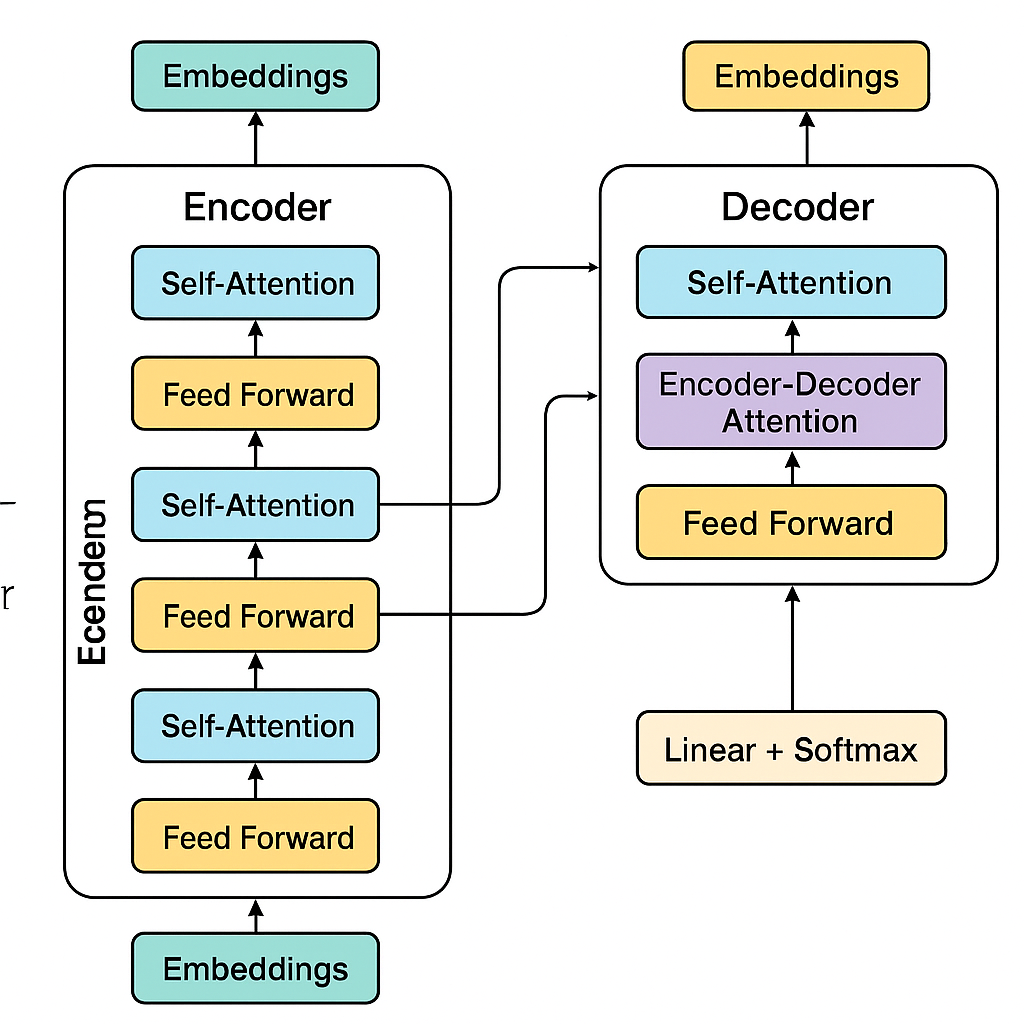


**Arquitetura do Transformer**

A arquitetura Transformer é composta por dois blocos principais:

**Encoder (Codificador)**

**Decoder (Decodificador)**

Eles trabalham juntos para transformar uma sequência de entrada em uma sequência de saída — por exemplo, em tarefas como tradução, resumo ou classificação de texto.

**Componentes do Encoder**

O encoder recebe a entrada textual (tokenizada e embutida) e a processa em camadas empilhadas. Cada camada do encoder contém:

1. **Self-Attention**

   * Permite ao modelo focar em diferentes partes da própria sequência de entrada.
   * Exemplo: ao processar a palavra "ela", o modelo pode prestar atenção ao "carro" anterior para entender que "ela" se refere a um objeto.

2. **Feed Forward Network (FFN)**

   * Camada totalmente conectada (MLP) aplicada a cada posição individual da sequência.
   * Inclui funções não lineares e normalizações.

3. **Residual Connection + Layer Normalization**

   * Cada bloco de atenção e feed forward possui uma conexão residual (skip connection) e uma normalização para facilitar o aprendizado.

O encoder é empilhado **N vezes** (ex: 6 ou 12 camadas no BERT).

**Componentes do Decoder**

O decoder recebe a saída anterior (em tarefas como tradução ou geração) e gera palavra por palavra. Cada camada do decoder contém:

1. **Masked Self-Attention**

   * Similar ao self-attention do encoder, mas com máscara para não "espiar o futuro" (causal).

2. **Encoder-Decoder Attention**

   * Permite que o decoder olhe para a saída do encoder, alinhando a entrada com a saída.
   * Exemplo: ao traduzir “carro vermelho”, o decoder pode “olhar” para “red car” no encoder.

3. **Feed Forward Network**

   * Igual ao encoder, com MLP + ReLU + normalização.

No final, há uma camada **Linear + Softmax** que transforma os vetores em probabilidades de palavras.

**Embeddings (na entrada de ambos)**

Antes de entrarem no encoder ou decoder, as palavras passam por:

* **Word Embeddings**: convertem tokens em vetores densos.
* **Positional Encoding**: como a arquitetura não é sequencial (como RNNs), adiciona-se a posição de cada token para manter a ordem da sequência.

**Resumo Visual**

```
Input Text → Token Embeddings + Positional Encoding → Encoder Blocks
                                         ↓
                                  Encoder Output
                                         ↓
Decoder Input (shifted output) → Decoder Blocks
                                         ↓
                          Linear + Softmax → Output Token
```

**Por que Transformers são tão poderosos?**

* Capturam **dependências de longo alcance** com eficiência.

* **Paralelizáveis** (diferente de RNNs/LSTMs).

* São a base de modelos como **BERT, GPT, T5, RoBERTa, BERTimbau**, entre outros.



In [ ]:
# Modelo Transformers
# # BERTimbau Transformers
MODEL = "neuralmind/bert-base-portuguese-cased"

In [ ]:
# tokenizer model
tokenizer = AutoTokenizer.from_pretrained(MODEL)

tokenizer_config.json:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/647 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, padding='max_length', max_length=128)

ds_train = ds_train.map(preprocess_function, batched=True)
ds_test  = ds_test.map(preprocess_function, batched=True)

num_labels = len(le.classes_)

Map:   0%|          | 0/15804 [00:00<?, ? examples/s]

Map:   0%|          | 0/5268 [00:00<?, ? examples/s]

In [ ]:
from transformers import Trainer, TrainingArguments, AutoModelForSequenceClassification
from sklearn.metrics import f1_score
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [ ]:
%%time

# Modelo
model = AutoModelForSequenceClassification.from_pretrained(MODEL, num_labels=num_labels)

# Argumentos de treino
training_args = TrainingArguments(
    output_dir='./results_bertimbau',
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_steps=20,
    logging_dir='./logs',
    report_to="none"
)

# Métrica
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {'f1': f1_score(labels, preds, average='weighted')}

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds_train,
    eval_dataset=ds_test,
    compute_metrics=compute_metrics
)

# Treinamento
trainer.train()


pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

CPU times: user 17min 32s, sys: 27.6 s, total: 17min 59s
Wall time: 15min 20s


TrainOutput(global_step=2964, training_loss=0.4317350963510161, metrics={'train_runtime': 914.246, 'train_samples_per_second': 51.859, 'train_steps_per_second': 3.242, 'total_flos': 3118739342625792.0, 'train_loss': 0.4317350963510161, 'epoch': 3.0})

In [ ]:
# Avaliação final no teste
y_pred = trainer.predict(ds_test).predictions.argmax(axis=-1)
print('\n==== Resultados modelo Transformers (BERTimbau) ====\n')
print(classification_report(test_df['label'], y_pred, target_names=le.classes_))


==== Resultados modelo Transformers (BERTimbau) ====

                                     precision    recall  f1-score   support

Cartão de crédito / Cartão pré-pago       0.84      0.84      0.84      1252
            Hipotecas / Empréstimos       0.86      0.86      0.86       962
                             Outros       0.75      0.76      0.76       558
       Roubo / Relatório de disputa       0.82      0.81      0.81      1206
         Serviços de conta bancária       0.86      0.86      0.86      1290

                           accuracy                           0.83      5268
                          macro avg       0.82      0.83      0.83      5268
                       weighted avg       0.83      0.83      0.83      5268



In [ ]:
print("F1 Score Transformers (BERTimbau) BERT (weighted):", f1_score(test_df['label'], y_pred, average='weighted'))

F1 Score Transformers (BERTimbau) BERT (weighted): 0.8329507218497648


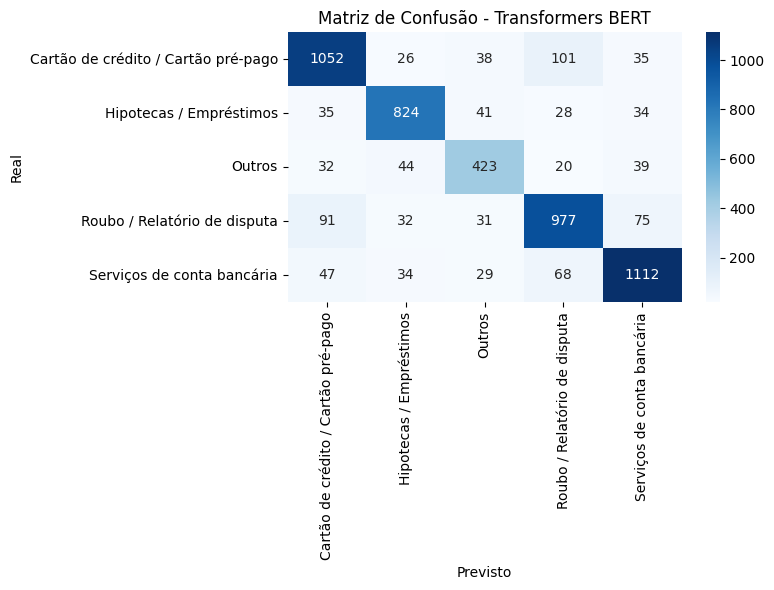

In [ ]:
# Matriz de confusão
cm = confusion_matrix(test_df['label'], y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Matriz de Confusão - Transformers BERT')
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.tight_layout()
plt.show()

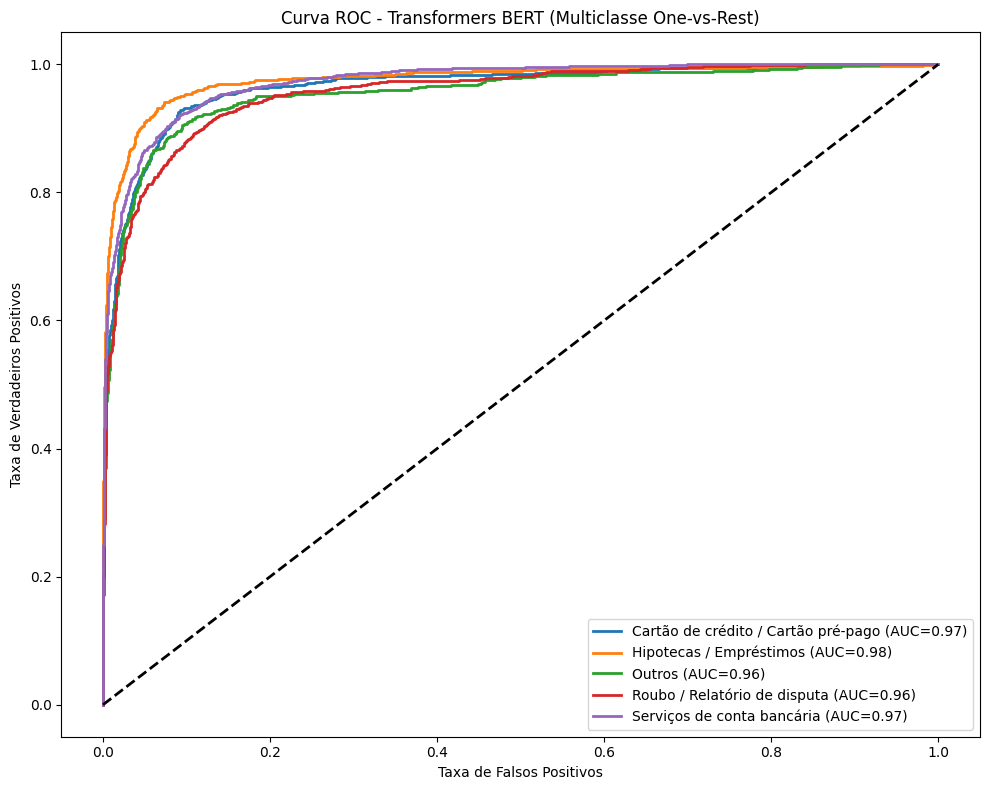

In [ ]:
n_classes = len(le.classes_)
y_true_bin = label_binarize(test_df['label'], classes=range(n_classes))
y_score = trainer.predict(ds_test).predictions  # shape: (n amostras, n_classes)

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{le.classes_[i]} (AUC={roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC - Transformers BERT (Multiclasse One-vs-Rest)')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# Part 14.1 - Transformers classficador Machine learning com BERT

In [ ]:
# Modelo
MODEL = "neuralmind/bert-base-portuguese-cased" # Ou outro de sua escolha

In [ ]:
# Tokenização modelo
tokenizer = AutoTokenizer.from_pretrained(MODEL)

In [ ]:
# Modelo
model = AutoModel.from_pretrained(MODEL)

# Rodando na GPU
device = "cuda" if torch.cuda.is_available() else "cpu"

# movendo para GPU
model = model.to(device)
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(29794, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [ ]:
# Função para extrair embedding [CLS] de um texto
def get_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
        # Pega o vetor do token [CLS] da última camada
        cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()
    return cls_embedding

# Supondo que seus dados estão assim:
# X_train, X_test, y_train, y_test = ... (veja split anterior)
# Use .tolist() se forem Series
X_train_list = list(X_train)
X_test_list  = list(X_test)

# Extrai embeddings para todo o dataset
X_train_emb = np.vstack([get_embedding(text) for text in tqdm(X_train_list)])
X_test_emb  = np.vstack([get_embedding(text) for text in tqdm(X_test_list)])

100%|██████████| 5268/5268 [00:57<00:00, 91.30it/s]


In [ ]:
## Usando modelo machine learning
# Sua lista de modelos, como antes
models_emb  = [DecisionTreeClassifier(max_depth=melhor_max_depth,
                                 min_samples_split=5,
                                 min_samples_leaf=2,
                                 max_features='sqrt',
                                 criterion='gini',
                                 splitter='best',
                                 random_state=42),

          RandomForestClassifier(n_estimators=melhor_max_depth,
                                 max_depth=15,
                                 min_samples_split=4,
                                 min_samples_leaf=2,
                                 max_features='sqrt',
                                 bootstrap=True,
                                 oob_score=True,
                                 criterion='gini',
                                 class_weight='balanced',
                                 random_state=42),

          LogisticRegression(random_state=50,
                             max_iter=1000),

          AdaBoostClassifier(random_state=45),

          XGBClassifier(random_state=42,
                        use_label_encoder=False,
                        tree_method='gpu_hist',
                        predictor='gpu_predictor',
                        eval_metric='logloss'),

          LGBMClassifier(boosting_type='gbdt',
                         bagging_fraction=0.9,
                         learning_rate=0.05,
                         feature_fraction=0.9,
                         bagging_freq=50,
                         verbosity=-1,
                         random_state=42,
                         device='cpu')]

Modelo 1: DecisionTreeClassifier (Embeddings)
Acurácia no Treino: 0.8948
Acurácia no Teste:  0.4150
Precision: 0.4172
Recall:    0.4150
F1-Score:  0.4152


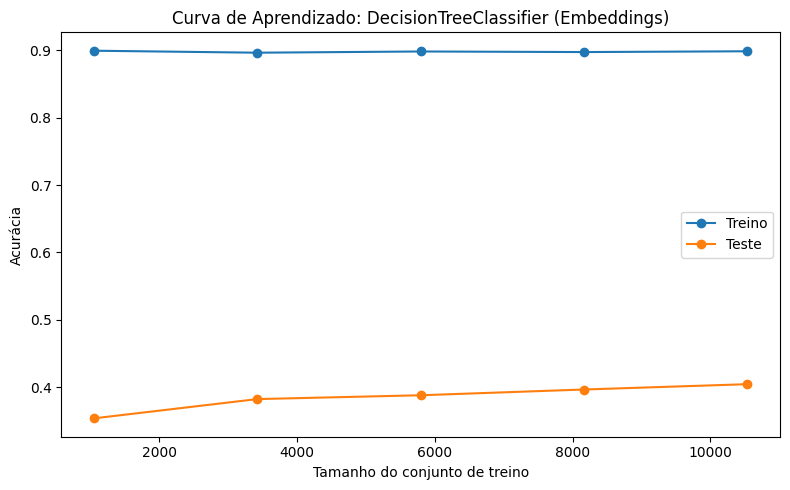

Modelo 2: RandomForestClassifier (Embeddings)
Acurácia no Treino: 0.9903
Acurácia no Teste:  0.5932
Precision: 0.5862
Recall:    0.5932
F1-Score:  0.5850


/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too fe

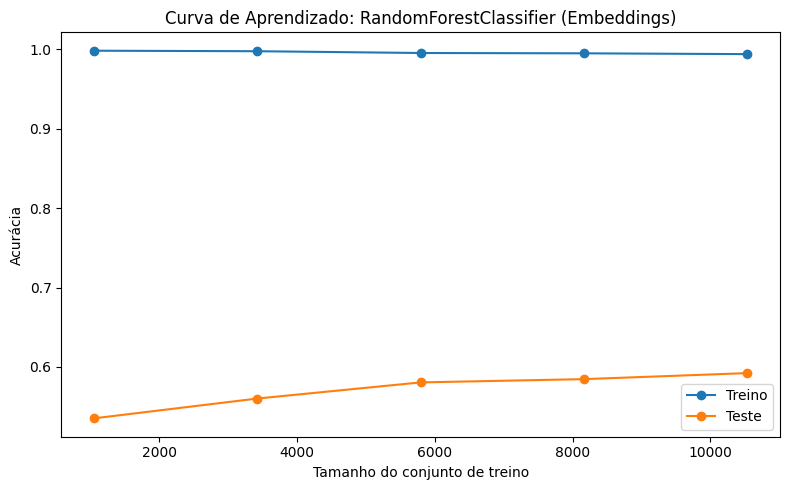

Modelo 3: LogisticRegression (Embeddings)
Acurácia no Treino: 0.7949
Acurácia no Teste:  0.7401
Precision: 0.7373
Recall:    0.7401
F1-Score:  0.7380


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

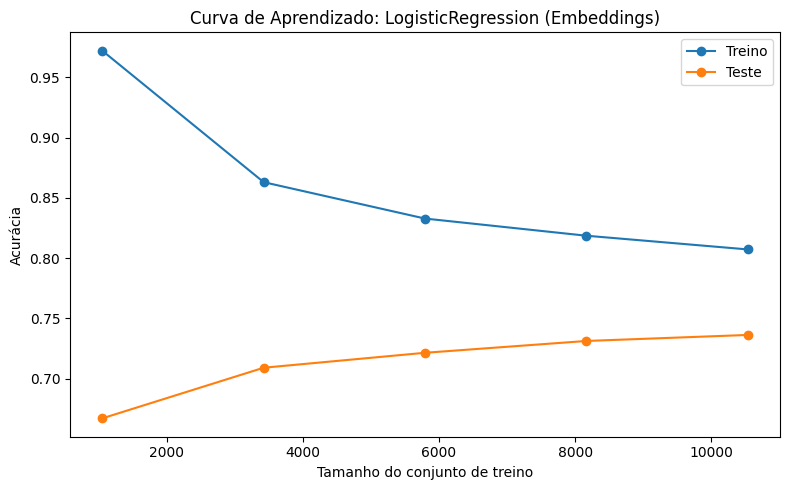

Modelo 4: AdaBoostClassifier (Embeddings)
Acurácia no Treino: 0.5979
Acurácia no Teste:  0.5930
Precision: 0.5863
Recall:    0.5930
F1-Score:  0.5883


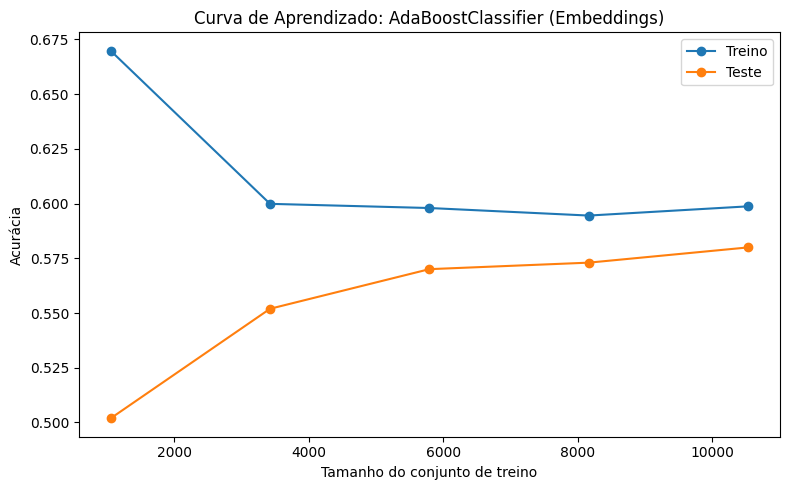

Modelo 5: XGBClassifier (Embeddings)
Acurácia no Treino: 0.9999
Acurácia no Teste:  0.7048
Precision: 0.7013
Recall:    0.7048
F1-Score:  0.7006


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [02:18:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [02:18:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [02:18:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [02:18:49] WARNING: /workspace/src/learner.cc:742:

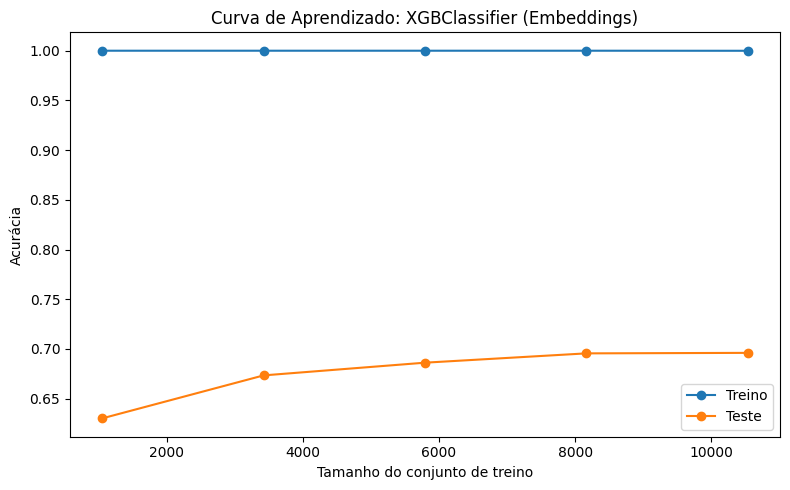

Modelo 6: LGBMClassifier (Embeddings)
Acurácia no Treino: 0.9036
Acurácia no Teste:  0.6898
Precision: 0.6864
Recall:    0.6898
F1-Score:  0.6840


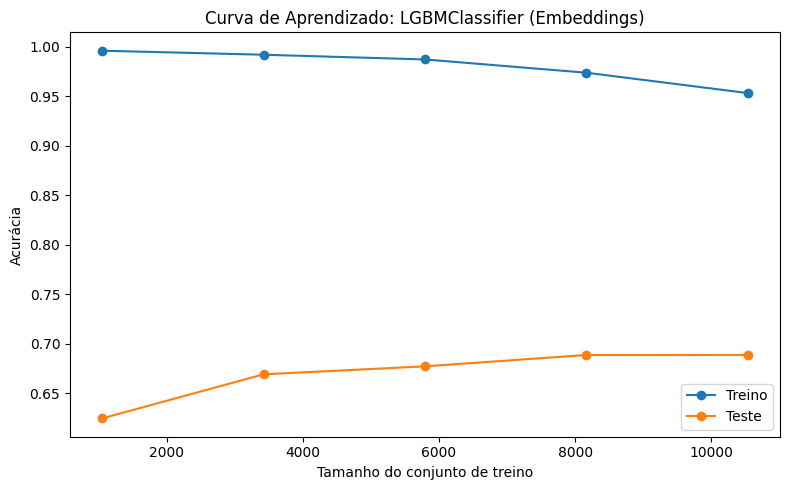

CPU times: user 3min 44s, sys: 2.28 s, total: 3min 46s
Wall time: 17min 42s


In [ ]:
%%time

metrics_list_emb = []

for i, model in enumerate(models_emb):
    print("=" * 40)
    print(f"Modelo {i+1}: {type(model).__name__} (Embeddings)")
    print("=" * 40)

    # Treinamento
    model.fit(X_train_emb, y_train)

    # Previsão
    y_pred = model.predict(X_test_emb)

    # Métricas
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"Acurácia no Treino: {accuracy_score(y_train, model.predict(X_train_emb)):.4f}")
    print(f"Acurácia no Teste:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-Score:  {f1:.4f}")

    metrics_list_emb.append({
        'Model': type(model).__name__ + " (Embeddings)",
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1
    })

    # Curva de aprendizado
    train_sizes, train_scores, test_scores = learning_curve(
        model,
        X_train_emb,
        y_train,
        cv=3,
        scoring='accuracy',
        train_sizes=np.linspace(0.1, 1.0, 5),
        n_jobs=-1
    )

    train_mean = train_scores.mean(axis=1)
    test_mean = test_scores.mean(axis=1)

    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(train_sizes, train_mean, marker='o', label='Treino')
    plt.plot(train_sizes, test_mean, marker='o', label='Teste')
    plt.xlabel('Tamanho do conjunto de treino')
    plt.ylabel('Acurácia')
    plt.title(f'Curva de Aprendizado: {type(model).__name__} (Embeddings)')
    plt.legend()
    plt.grid(False)
    plt.tight_layout()
    plt.show()

Modelo 1: DecisionTreeClassifier
Acurácia no Treino: 0.8948
Acurácia no Teste:  0.4150


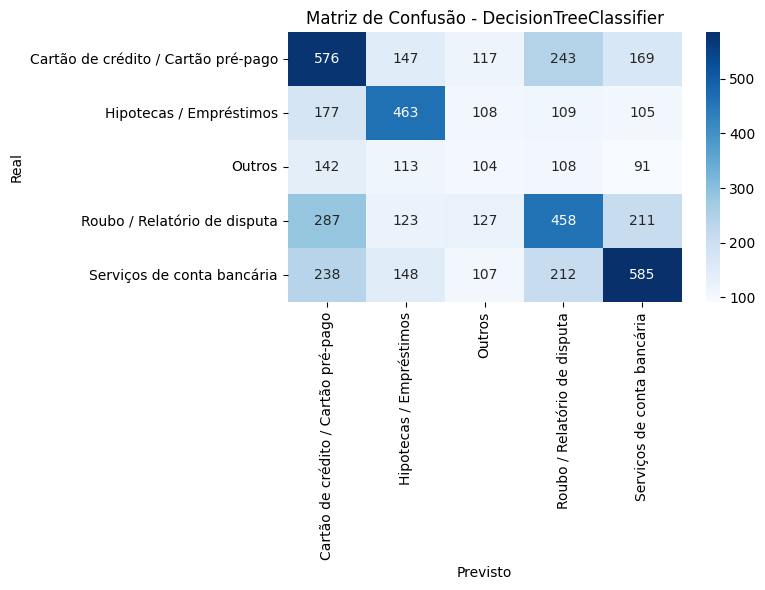

Modelo 2: RandomForestClassifier
Acurácia no Treino: 0.9903
Acurácia no Teste:  0.5932


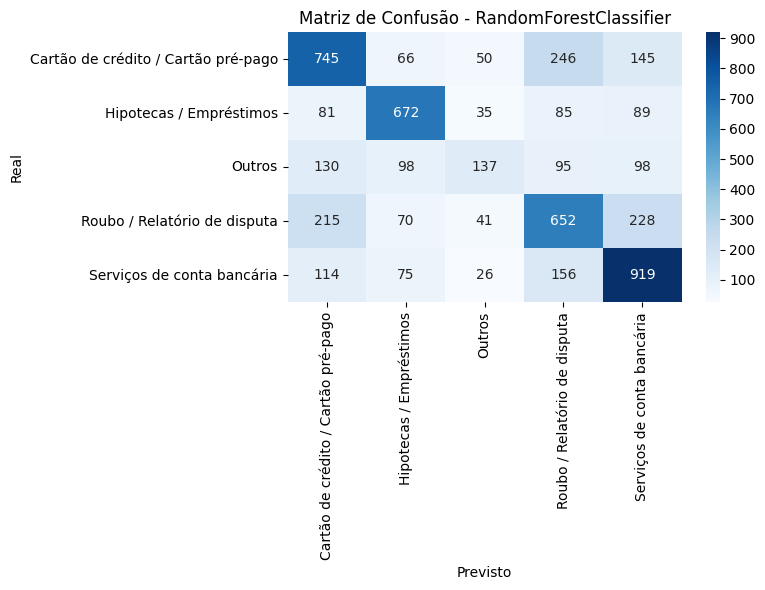

Modelo 3: LogisticRegression
Acurácia no Treino: 0.7949
Acurácia no Teste:  0.7401


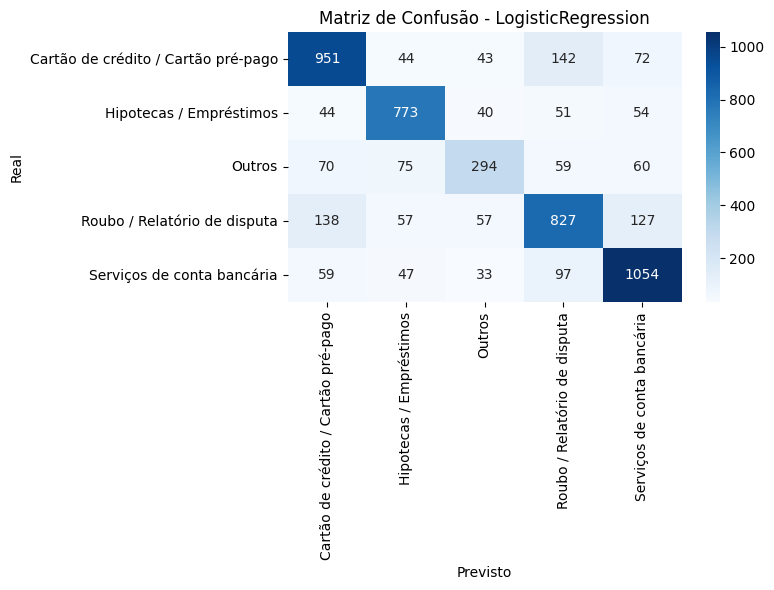

Modelo 4: AdaBoostClassifier
Acurácia no Treino: 0.5979
Acurácia no Teste:  0.5930


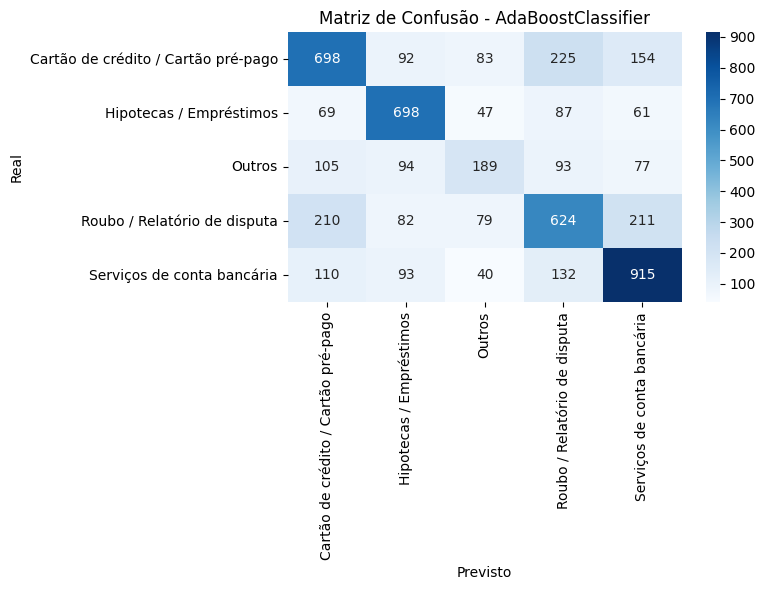

Modelo 5: XGBClassifier
Acurácia no Treino: 0.9999
Acurácia no Teste:  0.7048


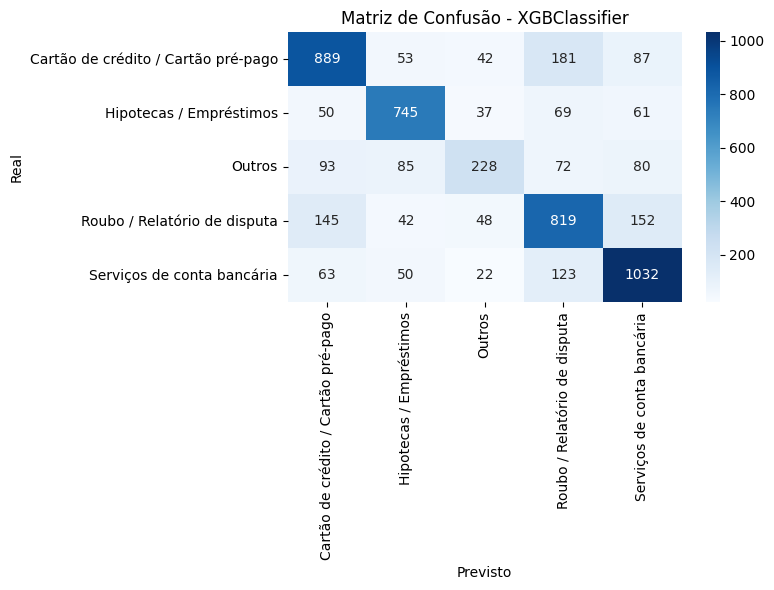

Modelo 6: LGBMClassifier
Acurácia no Treino: 0.9036
Acurácia no Teste:  0.6898


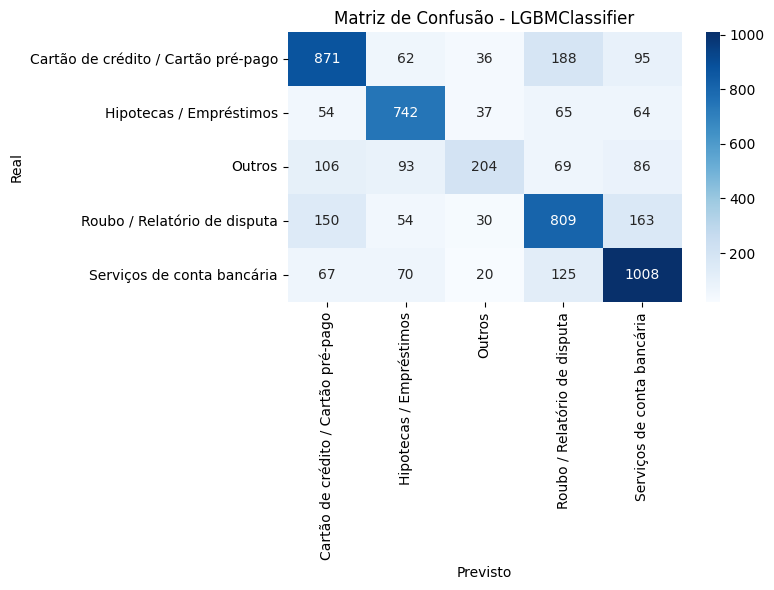

In [ ]:
for i, model in enumerate(models_emb):
    print("=" * 40)
    print(f"Modelo {i+1}: {type(model).__name__}")
    print("=" * 40)

    # TREINAMENTO
    model.fit(X_train_emb, y_train)

    # Previsão
    y_pred_train = model.predict(X_train_emb)
    y_pred = model.predict(X_test_emb)

    # Acurácia
    acuracia_treino = accuracy_score(y_train, y_pred_train)
    acuracia_teste = accuracy_score(y_test, y_pred)
    print(f"Acurácia no Treino: {acuracia_treino:.4f}")
    print(f"Acurácia no Teste:  {acuracia_teste:.4f}")

    # Matriz de Confusão com nomes das classes
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        confusion_matrix(y_test, y_pred),
        annot=True, fmt="d", cmap="Blues",
        xticklabels=le.classes_,  # <-- usa nomes da sua variável alvo
        yticklabels=le.classes_
    )
    plt.title(f"Matriz de Confusão - {type(model).__name__}")
    plt.xlabel("Previsto")
    plt.ylabel("Real")
    plt.tight_layout()
    plt.show()


In [ ]:
# Classification report
for i, model in enumerate(models_emb):
    print("=" * 40)
    print(f"Modelo {i+1}: {type(model).__name__}")
    print("=" * 40)

    # Prever no conjunto de teste (garanta que já fez model.fit() antes!)
    y_pred = model.predict(X_test_emb)

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    print("-" * 40)

Modelo 1: DecisionTreeClassifier

Classification Report:
                                     precision    recall  f1-score   support

Cartão de crédito / Cartão pré-pago       0.41      0.46      0.43      1252
            Hipotecas / Empréstimos       0.47      0.48      0.47       962
                             Outros       0.18      0.19      0.19       558
       Roubo / Relatório de disputa       0.41      0.38      0.39      1206
         Serviços de conta bancária       0.50      0.45      0.48      1290

                           accuracy                           0.41      5268
                          macro avg       0.39      0.39      0.39      5268
                       weighted avg       0.42      0.41      0.42      5268

----------------------------------------
Modelo 2: RandomForestClassifier

Classification Report:
                                     precision    recall  f1-score   support

Cartão de crédito / Cartão pré-pago       0.58      0.60      0.59     

Modelo 1: DecisionTreeClassifier


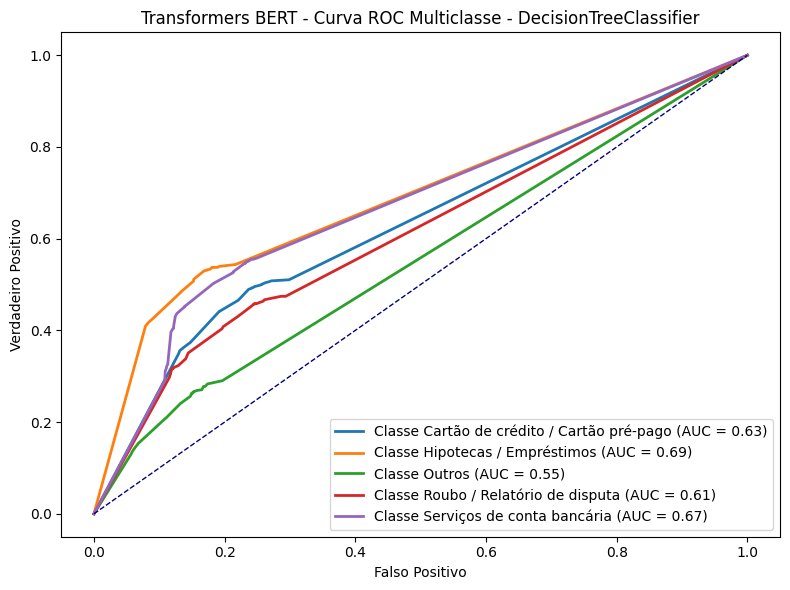

Modelo 2: RandomForestClassifier


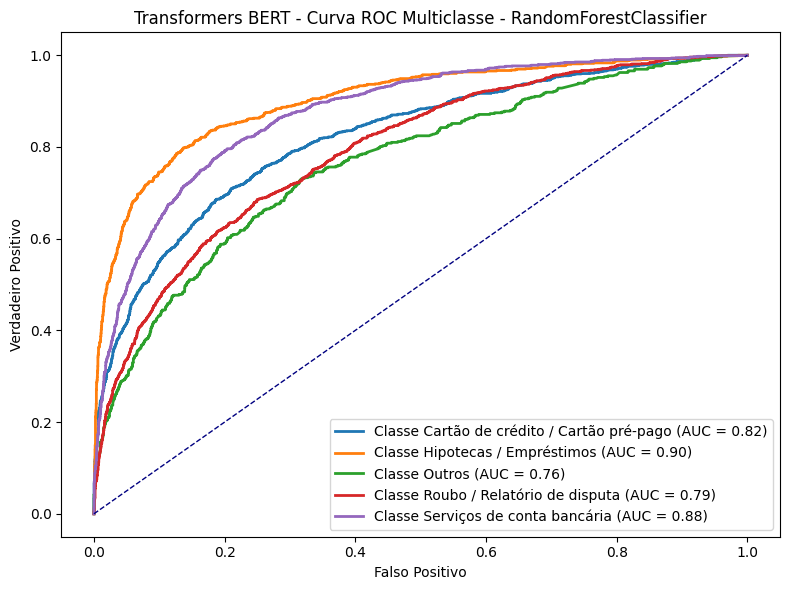

Modelo 3: LogisticRegression


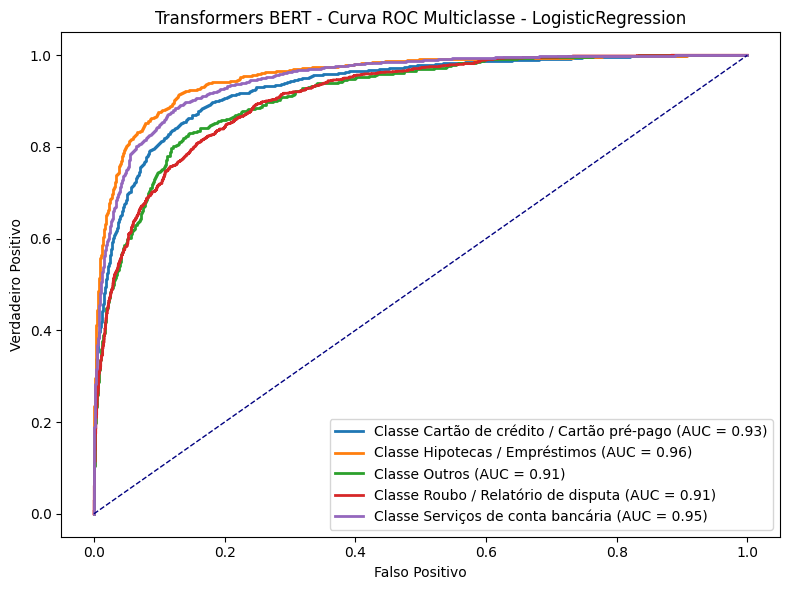

Modelo 4: AdaBoostClassifier


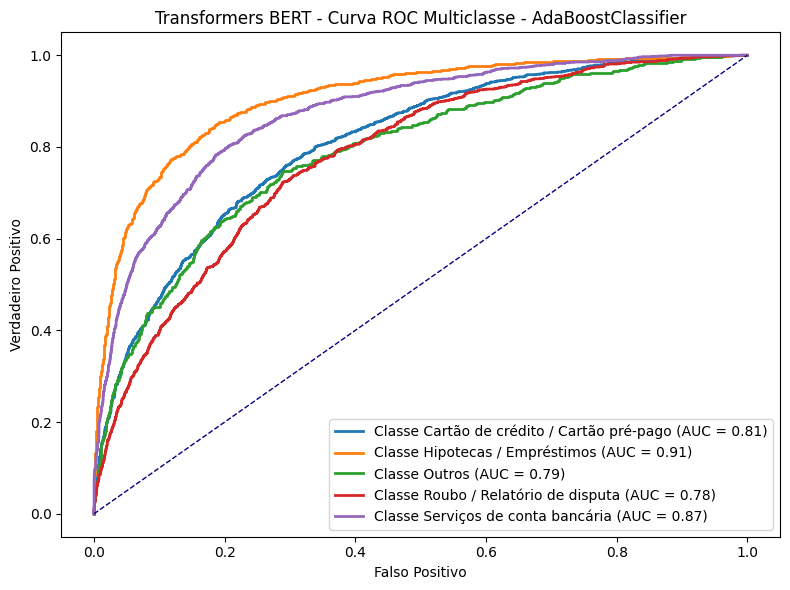

Modelo 5: XGBClassifier


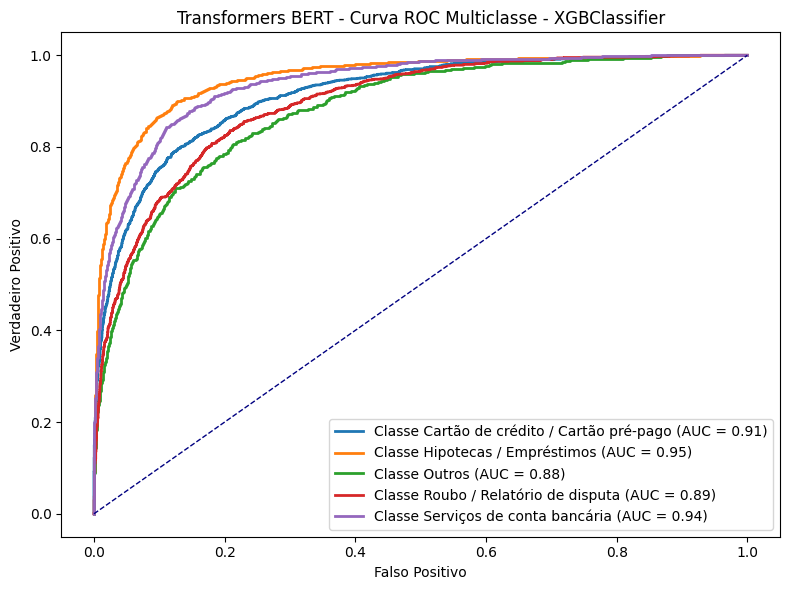

Modelo 6: LGBMClassifier


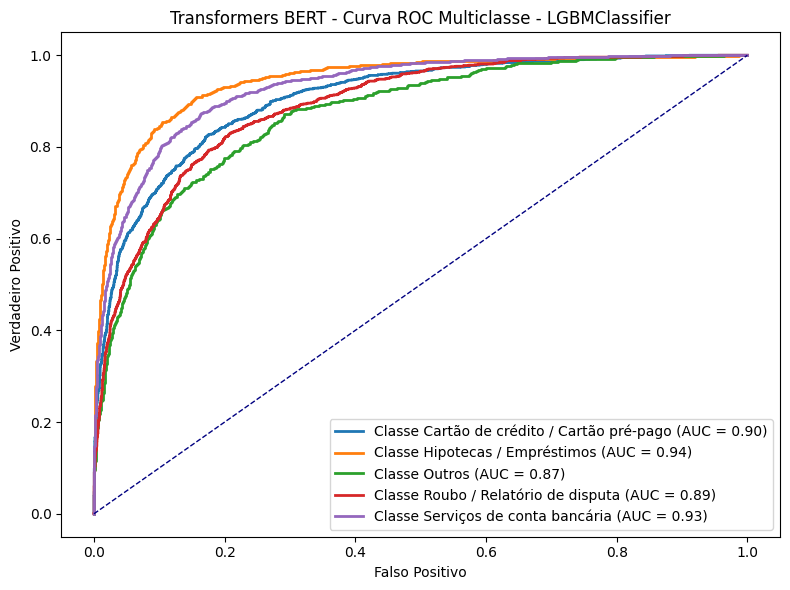

In [ ]:
def plot_multiclass_roc(y_true, y_score, classes, model_name):
    # Binariza os rótulos
    y_test_bin = label_binarize(y_true, classes=range(len(classes)))
    n_classes = y_test_bin.shape[1]

    plt.figure(figsize=(8, 6))
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'Classe {classes[i]} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlabel('Falso Positivo')
    plt.ylabel('Verdadeiro Positivo')
    plt.title(f'Transformers BERT - Curva ROC Multiclasse - {model_name}')
    plt.legend(loc="lower right")
    plt.grid(False)
    plt.tight_layout()
    plt.show()

for i, model in enumerate(models_emb):
    print("=" * 40)
    print(f"Modelo {i+1}: {type(model).__name__}")
    print("=" * 40)

    model.fit(X_train_emb, y_train)
    y_pred = model.predict(X_test_emb)

    # ...classification_report, matriz de confusão, curva de aprendizado...

    # CURVA ROC
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test_emb)
        plot_multiclass_roc(y_test, y_score, le.classes_, type(model).__name__)
    elif hasattr(model, "decision_function"):
        # Para SVM LinearSVC, Normalizer precisa ser ativado
        try:
            y_score = model.decision_function(X_test_emb)
            plot_multiclass_roc(y_test, y_score, le.classes_, type(model).__name__)
        except:
            print("Modelo não suporta ROC multiclasse.")
    else:
        print(f"Modelo {type(model).__name__} não suporta curva ROC.")

# **Parte 15 – Resultado Final (Modelos Campeões)**

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

metrics_list = []

# Modelos clássicos (TF-IDF)
for model in models_tfidf:
    model_name = type(model).__name__ + " (TF-IDF)"
    model.fit(X_train_vec, y_train)
    y_pred = model.predict(X_test_vec)
    metrics_list.append({
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='weighted', zero_division=0),
        'Recall': recall_score(y_test, y_pred, average='weighted'),
        'F1-Score': f1_score(y_test, y_pred, average='weighted')
    })

# Modelos com embeddings Transformers
for model in models_emb:
    model_name = type(model).__name__ + " (Transformers)"
    model.fit(X_train_emb, y_train)
    y_pred = model.predict(X_test_emb)
    metrics_list.append({
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='weighted', zero_division=0),
        'Recall': recall_score(y_test, y_pred, average='weighted'),
        'F1-Score': f1_score(y_test, y_pred, average='weighted')
    })

# Modelo Transformers (Trainer direto)
if 'y_pred_transformer' in locals():
    metrics_list.append({
        'Model': "BERTimbau (Trainer)",
        'Accuracy': accuracy_score(y_test, y_pred_transformer),
        'Precision': precision_score(y_test, y_pred_transformer, average='weighted', zero_division=0),
        'Recall': recall_score(y_test, y_pred_transformer, average='weighted'),
        'F1-Score': f1_score(y_test, y_pred_transformer, average='weighted')
    })

# Criar DataFrame
df_metrics = pd.DataFrame(metrics_list).sort_values(by='F1-Score', ascending=False)

# Função para destacar melhores valores
def highlight_best(s):
    return ['background-color: #b5ffb5' if v == s.max() else '' for v in s]

# Exibir DataFrame com destaque
df_metrics_styled = df_metrics.style.apply(highlight_best, subset=['F1-Score', 'Accuracy', 'Precision', 'Recall'])
display(df_metrics_styled)


## **Resumo da Tabela Final**

| Modelo                                | Accuracy  | Precision | Recall    | F1-Score  |
| ------------------------------------- | --------- | --------- | --------- | --------- |
| **LogisticRegression (TF-IDF)**       | **0.891** | **0.892** | **0.891** | **0.891** |
| **LGBMClassifier (TF-IDF)**           | 0.886     | 0.886     | 0.886     | 0.886     |
| AdaBoostClassifier (TF-IDF)           | 0.800     | 0.799     | 0.800     | 0.799     |
| RandomForestClassifier (TF-IDF)       | 0.795     | 0.795     | 0.795     | 0.794     |
| LogisticRegression (Transformers)     | 0.740     | 0.737     | 0.740     | 0.738     |
| XGBClassifier (Transformers)          | 0.705     | 0.701     | 0.705     | 0.701     |
| LGBMClassifier (Transformers)         | 0.690     | 0.686     | 0.690     | 0.684     |
| DecisionTreeClassifier (TF-IDF)       | 0.628     | 0.633     | 0.628     | 0.626     |
| AdaBoostClassifier (Transformers)     | 0.593     | 0.586     | 0.593     | 0.588     |
| RandomForestClassifier (Transformers) | 0.593     | 0.586     | 0.593     | 0.585     |
| DecisionTreeClassifier (Transformers) | 0.415     | 0.417     | 0.415     | 0.415     |
| XGBClassifier (TF-IDF)                | **0.315** | 0.381     | **0.315** | **0.235** |

**Análise por Grupo**

**1. Modelos Clássicos com TF-IDF**

Esses modelos foram alimentados com representações vetoriais esparsas de texto (TF-IDF), e entregaram os **melhores desempenhos gerais**:

* **Logistic Regression (TF-IDF)** teve a **melhor performance absoluta** (F1 = 0.891), mostrando que modelos lineares simples funcionam muito bem com vetorização TF-IDF.

* **LightGBM (TF-IDF)** também performou muito bem (F1 = 0.886), sendo uma opção excelente com mais flexibilidade para tuning.

* **RandomForest e AdaBoost (TF-IDF)** obtiveram bons resultados (\~0.79 F1), mostrando robustez, mas inferiores à Regressão Logística.

**Conclusão**: Modelos clássicos com TF-IDF continuam sendo **mais eficazes que embeddings + ML**, neste cenário supervisionado.

**2. Embeddings com Transformers + Modelos ML**

Aqui, usamos embeddings extraídos de modelos como **BERTimbau**, e aplicamos algoritmos como `LogisticRegression`, `XGBoost`, `LightGBM`, etc.:

* **Logistic Regression (Transformers)** teve o melhor desempenho deste grupo (F1 = 0.738), mas ainda **bem abaixo da versão TF-IDF**.

* Modelos como **XGBoost e LGBM com embeddings** performaram razoavelmente (F1 \~0.70 e 0.68).

* **Decision Tree e RandomForest com embeddings** tiveram desempenho fraco (\~0.59 ou abaixo).

* **DecisionTreeClassifier (Transformers)** teve o pior desempenho entre todos os modelos (F1 = 0.415).


**Conclusão**: Apesar do poder semântico dos embeddings BERT, eles **não superaram os vetores TF-IDF** neste caso. Isso pode ocorrer por:

* Pequeno volume de dados.
* Falta de fine-tuning dos embeddings.
* Representações densas que não se alinham bem com os modelos ML simples.

**3. Desempenho Ruim – XGBoost (TF-IDF)**

* F1 = **0.23**, indicando falha completa de generalização.
* Aparentemente, hiperparâmetros mal ajustados ou problemas na representação vetorial para este modelo específico.

**Conclusões Estratégicas**

| Recomendação                       | Justificativa                                                            |
| ---------------------------------- | ------------------------------------------------------------------------ |
| **✔️ LogisticRegression (TF-IDF)** | Melhor modelo: simples, eficaz, ótimo desempenho geral.                  |
| **✔️ LGBMClassifier (TF-IDF)**     | Muito próximo do melhor, boa escalabilidade e estabilidade.              |
| **⚠️ Embeddings + ML**             | Úteis, mas abaixo de TF-IDF no cenário atual. Podem melhorar com tuning. |
| **❌ DecisionTree e XGBoost**       | Fraco desempenho, tanto com TF-IDF quanto com embeddings.                |

Em muitos cenários de NLP supervisionado com dados estruturados (rótulos bem definidos), **TF-IDF + modelos simples** ainda são muito competitivos e mais rápidos.

Transformers brilham mais com **fine-tuning direto ou tarefas mais complexas**, como classificação multilabel, zero-shot ou embedding contextual com muito texto não rotulado.

# **Parte 16 - Validação do professor**

Consolidar apenas os scripts do seu *modelo campeão*, desde o carregamento do dataframe, separação das amostras, tratamentos utilizados (funções, limpezas, etc.), criação dos objetos de vetorização dos textos e modelo treinado e outras implementações utilizadas no processo de desenvolvimento do modelo.

O modelo precisar atingir um score na métrica F1 Score superior a 75%.

*Atenção:*

- **Implemente aqui apenas os scripts que fazem parte do modelo campeão.***
- **Execute o pipeline do modelo campeão completamente para garantir que não tetá erros no script.**

In [3]:
# Instalando pacotes
!pip install wordcloud

# Instalando pacotes transformers
!pip install -U transformers sentence-transformers
!pip install transformers datasets accelerate # roda transformers na GPU

# Instalando pacotes ML
!pip install lightgbm
!pip install xgboost
!pip install catboost

# Instalando pacotes nlp
!pip install nltk
!pip install -q spacy unidecode
!pip install leia-br
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 102.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scipy 1.13.1 requires numpy<2.3,>=1.22.4, but you have numpy 2.3.2 which is incompatible.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.3.2 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.3.2 which is incompatible.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.
cupy-cuda12x 13.3.0 requires numpy<2.3,>=1.22, but you have numpy 2.3.2 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 2.3.2 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you 

In [4]:
# Bibliotecas de manipulação de strings e sistema de arquivos
import re
import os

# Bibliotecas de NLP
import spacy
import nltk
from nltk.util import ngrams
from nltk.corpus import stopwords
from LeIA import SentimentIntensityAnalyzer

# Bibliotecas numéricas e tabulares
import numpy as np
import pandas as pd

# Visualização de dados
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter

# Pré-processamento
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import label_binarize

# Modelos de machine learning
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer

# Métricas de avaliação
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, f1_score

# Validação de modelos
from sklearn.model_selection import train_test_split

# Vetorização de texto
from sklearn.feature_extraction.text import TfidfVectorizer

# Transformers (HuggingFace)
import torch
from transformers import pipeline
from transformers import BertTokenizer, BertModel
from transformers import AutoTokenizer, AutoModel
from transformers import BartTokenizer, BartForSequenceClassification

# Sentence Transformers
from sentence_transformers import SentenceTransformer

# Normalização de texto
from unidecode import unidecode

# Barra de progresso
from tqdm import tqdm

# Supressão de warnings
import warnings
warnings.filterwarnings("ignore")

# Baixando pacote modelo idioma pt-br pelo spacy
!python -m spacy download pt_core_news_sm

# Carregar modelo spaCy em português
nlp = spacy.load("pt_core_news_sm")

# lista de stopwords do NLTK
nltk.download('stopwords')

# Verificando disponibilidade de GPU com PyTorch
import torch

# Detectar dispositivo disponível
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Dispositivo em uso:", device)

# Se CUDA estiver disponível, exibe informações da GPU
if device == 'cuda':
    print("CUDA disponível:", torch.cuda.is_available())
    print("Nome da GPU:", torch.cuda.get_device_name(0))
else:
    print("CUDA não está disponível. Usando CPU.")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 121.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
Dispositivo em uso: cuda
CUDA disponível: True
Nome da GPU: Tesla T4


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
# Base dados
df = pd.read_csv('https://dados-ml-pln.s3.sa-east-1.amazonaws.com/tickets_reclamacoes_classificados.csv', delimiter=';')
df

id_reclamacao              data_abertura  \
0            3229299  2019-05-01T12:00:00-05:00   
1            3199379  2019-04-02T12:00:00-05:00   
2            3233499  2019-05-06T12:00:00-05:00   
3            3180294  2019-03-14T12:00:00-05:00   
4            3224980  2019-04-27T12:00:00-05:00   
...              ...                        ...   
21067        3094545  2018-12-07T12:00:00-05:00   
21068        3091984  2018-12-05T12:00:00-05:00   
21069        3133355  2019-01-25T12:00:00-05:00   
21070        3110963  2018-12-27T12:00:00-05:00   
21071        2001189  2016-07-06T12:00:00-05:00   

                                 categoria  \
0                  Hipotecas / Empréstimos   
1      Cartão de crédito / Cartão pré-pago   
2      Cartão de crédito / Cartão pré-pago   
3      Cartão de crédito / Cartão pré-pago   
4               Serviços de conta bancária   
...                                    ...   
21067  Cartão de crédito / Cartão pré-pago   
21068         Roubo / Relatório de disputa   
21069         Roubo / Relatório de disputa   
21070                               Outros   
21071                               Outros   

                                    descricao_reclamacao  
0      Bom dia, meu nome é xxxx xxxx e agradeço se vo...  
1      Atualizei meu cartão xxxx xxxx em xx/xx/2018 e...  
2      O cartão Chase foi relatado em xx/xx/2019. No ...  
3      Em xx/xx/2018, enquanto tentava reservar um ti...  
4      Meu neto me dê cheque por {$ 1600,00} Eu depos...  
...                                                  ...  
21067  Depois de ser um cliente de cartão de persegui...  
21068  Na quarta -feira, xx/xx/xxxx, liguei para o Ch...  
21069  Não estou familiarizado com o XXXX Pay e não e...  
21070  Eu tive crédito impecável por 30 anos. Eu tive...  
21071  Mais de 10 anos atrás, encerrei minhas contas ...  

[21072 rows x 4 columns]

In [6]:
%%time

### Pré-processamento

# Baixar recursos se necessário
nltk.download('stopwords')

# stopwords em portuguese
stopwords_pt = set(stopwords.words('portuguese'))

# modelo portuguese
nlp = spacy.load("pt_core_news_sm")

# Função pre-processamento
def preprocessamento_nlp_completo(df, coluna_texto="descricao_reclamacao"):
    """
    Função única de pipeline de NLP:
    - Limpa texto (minúsculas, acentos, URL, números, pontuação, palavras tipo 'xxxx')
    - Remove stopwords
    - Tokeniza
    - Lematiza (spaCy)
    - Gera unigrama, bigrama, trigrama
    - Cria tokens sem stopwords
    Retorna DataFrame com novas colunas.
    """

    # Limpeza + stopwords + tokenização
    def limpar_e_tokenizar(texto):
        texto = str(texto).lower()
        texto = unidecode(texto)
        texto = re.sub(r"http\S+|www\S+|https\S+", "", texto)
        texto = re.sub(r"\d+", "", texto)
        texto = re.sub(r"[^\w\s]", "", texto)
        texto = re.sub(r"\b[x]+\b", "", texto)
        tokens = texto.split()
        tokens_sem_sw = [t for t in tokens if t not in stopwords_pt]
        return texto, tokens, tokens_sem_sw

    # Lematização
    def lematizar(texto):
        doc = nlp(texto)
        return [token.lemma_ for token in doc if not token.is_punct and not token.is_space]

    # N-grams
    def gerar_ngrams(tokens, n):
        return [" ".join(grama) for grama in ngrams(tokens, n)]

    # Aplicando pipeline linha a linha
    descricao_limp, tokens, tokens_sem_sw, lemas, unigrama, bigramas, trigramas = [], [], [], [], [], [], []
    for texto in df[coluna_texto]:
        limp, toks, toks_sem_sw = limpar_e_tokenizar(texto)
        descricao_limp.append(limp)
        tokens.append(toks)
        tokens_sem_sw.append(toks_sem_sw)
        lemas.append(lematizar(limp))
        unigrama.append(gerar_ngrams(toks, 1))
        bigramas.append(gerar_ngrams(toks, 2))
        trigramas.append(gerar_ngrams(toks, 3))

    # Atribuir ao DataFrame
    df["descricao_reclamacao_limp"] = descricao_limp
    df["tokens"] = tokens
    df["tokens_sem_stopwords"] = tokens_sem_sw
    df["lematizacao"] = lemas
    df["Unigrama"] = unigrama
    df["Bigramas"] = bigramas
    df["Trigramas"] = trigramas

    return df

# Aplicando função
df = preprocessamento_nlp_completo(df, coluna_texto="descricao_reclamacao")

# Inicializa o analisador
analyzer = SentimentIntensityAnalyzer()

# Função para classificar sentimento
def aplicar_classificacao_sentimento(df, coluna_texto="descricao_reclamacao_limp"):
    """
    Adiciona duas colunas ao DataFrame:
    - sentiment_score: valor de sentimento (-1 a +1)
    - sentiment_class: classificador ('positivo', 'neutro', 'negativo')
    """
    analyzer = SentimentIntensityAnalyzer()

    def analisar_sentimento(texto):
        resultado = analyzer.polarity_scores(texto)
        score = resultado["compound"]
        if score >= 0.05:
            sentimento = "positivo"
        elif score <= -0.05:
            sentimento = "negativo"
        else:
            sentimento = "neutro"
        return pd.Series([score, sentimento])

    df[["sentiment_score", "sentiment_class"]] = df[coluna_texto].apply(analisar_sentimento)
    return df

# Aplicando função sentimento
df = aplicar_classificacao_sentimento(df, coluna_texto="descricao_reclamacao_limp")
df

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


CPU times: user 13min 13s, sys: 2.98 s, total: 13min 16s
Wall time: 13min 20s


id_reclamacao              data_abertura  \
0            3229299  2019-05-01T12:00:00-05:00   
1            3199379  2019-04-02T12:00:00-05:00   
2            3233499  2019-05-06T12:00:00-05:00   
3            3180294  2019-03-14T12:00:00-05:00   
4            3224980  2019-04-27T12:00:00-05:00   
...              ...                        ...   
21067        3094545  2018-12-07T12:00:00-05:00   
21068        3091984  2018-12-05T12:00:00-05:00   
21069        3133355  2019-01-25T12:00:00-05:00   
21070        3110963  2018-12-27T12:00:00-05:00   
21071        2001189  2016-07-06T12:00:00-05:00   

                                 categoria  \
0                  Hipotecas / Empréstimos   
1      Cartão de crédito / Cartão pré-pago   
2      Cartão de crédito / Cartão pré-pago   
3      Cartão de crédito / Cartão pré-pago   
4               Serviços de conta bancária   
...                                    ...   
21067  Cartão de crédito / Cartão pré-pago   
21068         Roubo / Relatório de disputa   
21069         Roubo / Relatório de disputa   
21070                               Outros   
21071                               Outros   

                                    descricao_reclamacao  \
0      Bom dia, meu nome é xxxx xxxx e agradeço se vo...   
1      Atualizei meu cartão xxxx xxxx em xx/xx/2018 e...   
2      O cartão Chase foi relatado em xx/xx/2019. No ...   
3      Em xx/xx/2018, enquanto tentava reservar um ti...   
4      Meu neto me dê cheque por {$ 1600,00} Eu depos...   
...                                                  ...   
21067  Depois de ser um cliente de cartão de persegui...   
21068  Na quarta -feira, xx/xx/xxxx, liguei para o Ch...   
21069  Não estou familiarizado com o XXXX Pay e não e...   
21070  Eu tive crédito impecável por 30 anos. Eu tive...   
21071  Mais de 10 anos atrás, encerrei minhas contas ...   

                               descricao_reclamacao_limp  \
0      bom dia meu nome e   e agradeco se voce puder ...   
1      atualizei meu cartao   em  e fui informado pel...   
2      o cartao chase foi relatado em  no entanto o p...   
3      em  enquanto tentava reservar um ticket   me d...   
4      meu neto me de cheque por   eu depositei o na ...   
...                                                  ...   
21067  depois de ser um cliente de cartao de persegui...   
21068  na quarta feira  liguei para o chas meu proved...   
21069  nao estou familiarizado com o  pay e nao enten...   
21070  eu tive credito impecavel por  anos eu tive ca...   
21071  mais de  anos atras encerrei minhas contas com...   

                                                  tokens  \
0      [bom, dia, meu, nome, e, e, agradeco, se, voce...   
1      [atualizei, meu, cartao, em, e, fui, informado...   
2      [o, cartao, chase, foi, relatado, em, no, enta...   
3      [em, enquanto, tentava, reservar, um, ticket, ...   
4      [meu, neto, me, de, cheque, por, eu, depositei...   
...                                                  ...   
21067  [depois, de, ser, um, cliente, de, cartao, de,...   
21068  [na, quarta, feira, liguei, para, o, chas, meu...   
21069  [nao, estou, familiarizado, com, o, pay, e, na...   
21070  [eu, tive, credito, impecavel, por, anos, eu, ...   
21071  [mais, de, anos, atras, encerrei, minhas, cont...   

                                    tokens_sem_stopwords  \
0      [bom, dia, nome, agradeco, voce, puder, ajudar...   
1      [atualizei, cartao, informado, agente, fez, at...   
2      [cartao, chase, relatado, entanto, pedido, fra...   
3      [enquanto, tentava, reservar, ticket, deparei,...   
4      [neto, cheque, depositei, conta, chase, fundo,...   
...                                                  ...   
21067  [cliente, cartao, perseguicao, decada, recebeu...   
21068  [quarta, feira, liguei, chas, provedor, cartoe...   
21069  [nao, familiarizado, pay, nao, entendi, grande...   
21070  [credito, impecavel, anos, cartoes, credito, c...   
21071  [anos, atra

In [7]:
## Data leakage
# Lista de colunas para evitar vazamento de dados
colunas_remover = ['id_reclamacao',
                   'data_abertura',
                   'sentiment_score',
                   'sentiment_class']

# Remover do DataFrame (inplace=True altera diretamente o DataFrame)
df = df.drop(columns=[col for col in colunas_remover if col in df.columns])
df.head(n=8)

categoria  \
0              Hipotecas / Empréstimos   
1  Cartão de crédito / Cartão pré-pago   
2  Cartão de crédito / Cartão pré-pago   
3  Cartão de crédito / Cartão pré-pago   
4           Serviços de conta bancária   
5  Cartão de crédito / Cartão pré-pago   
6           Serviços de conta bancária   
7                               Outros   

                                descricao_reclamacao  \
0  Bom dia, meu nome é xxxx xxxx e agradeço se vo...   
1  Atualizei meu cartão xxxx xxxx em xx/xx/2018 e...   
2  O cartão Chase foi relatado em xx/xx/2019. No ...   
3  Em xx/xx/2018, enquanto tentava reservar um ti...   
4  Meu neto me dê cheque por {$ 1600,00} Eu depos...   
5                       Você pode remover a consulta   
6  Sem aviso prévio J.P. Morgan Chase restringiu ...   
7  Durante os meses de verão, experimento uma ren...   

                           descricao_reclamacao_limp  \
0  bom dia meu nome e   e agradeco se voce puder ...   
1  atualizei meu cartao   em  e fui informado pel...   
2  o cartao chase foi relatado em  no entanto o p...   
3  em  enquanto tentava reservar um ticket   me d...   
4  meu neto me de cheque por   eu depositei o na ...   
5                       voce pode remover a consulta   
6  sem aviso previo jp morgan chase restringiu mi...   
7  durante os meses de verao experimento uma rend...   

                                              tokens  \
0  [bom, dia, meu, nome, e, e, agradeco, se, voce...   
1  [atualizei, meu, cartao, em, e, fui, informado...   
2  [o, cartao, chase, foi, relatado, em, no, enta...   
3  [em, enquanto, tentava, reservar, um, ticket, ...   
4  [meu, neto, me, de, cheque, por, eu, depositei...   
5                 [voce, pode, remover, a, consulta]   
6  [sem, aviso, previo, jp, morgan, chase, restri...   
7  [durante, os, meses, de, verao, experimento, u...   

                                tokens_sem_stopwords  \
0  [bom, dia, nome, agradeco, voce, puder, ajudar...   
1  [atualizei, cartao, informado, agente, fez, at...   
2  [cartao, chase, relatado, entanto, pedido, fra...   
3  [enquanto, tentava, reservar, ticket, deparei,...   
4  [neto, cheque, depositei, conta, chase, fundo,...   
5                    [voce, pode, remover, consulta]   
6  [aviso, previo, jp, morgan, chase, restringiu,...   
7  [durante, meses, verao, experimento, renda, de...   

                                         lematizacao  \
0  [bom, dia, meu, nome, e, e, agradeco, se, voce...   
1  [atualizei, meu, cartao, em, e, ser, informar,...   
2  [o, cartao, chase, ser, relatar, em, em o, ent...   
3  [em, enquanto, tentar, reservar, um, ticket, e...   
4  [meu, neto, eu, de, cheque, por, eu, depositar...   
5                [voce, poder, remover, o, consulta]   
6  [sem, aviso, previo, jp, morgan, chase, restri...   
7  [durante, o, mês, de, verao, experimento, um, ...   

                                            Unigrama  \
0  [bom, dia, meu, nome, e, e, agradeco, se, voce...   
1  [atualizei, meu, cartao, em, e, fui, informado...   
2  [o, cartao, chase, foi, relatado, em, no, enta...   
3  [em, enquanto, tentava, reservar, um, ticket, ...   
4  [meu, neto, me, de, cheque, por, eu, depositei...   
5                 [voce, pode, remover, a, consulta]   
6  [sem, aviso, previo, jp, morgan, chase, restri...   
7  [durante, os, meses, de, verao, experimento, u...   

                                            Bigramas  \
0  [bom dia, dia meu, meu nome, nome e, e e, e ag...   
1  [atualizei meu, meu cartao, cartao em, em e, e...   
2  [o cartao, cartao chase, chase foi, foi relata...   
3  [em enquanto, enquanto tentava, tentava reserv...   
4  [meu neto, neto me, me de, de cheque, cheque p...   
5   [voce pode, pode remover, remover a, a consulta]   
6  [sem aviso, aviso previo, previo jp, jp morgan...   
7  [durante os, os meses, meses de, de verao, ver...   

                                           Trigramas  
0  [bom dia meu, dia meu nome, meu nome e, nome e...  
1  [a

In [8]:
# Feature engineering
from sklearn.preprocessing import LabelEncoder

# Encode para a variavel target
le = LabelEncoder()

df['categoria'] = le.fit_transform(df['categoria'])

In [9]:
# Define os textos e o alvo
X_text = df['descricao_reclamacao_limp']
y = df['categoria']

In [10]:
# Divisão treino e teste
X_train_text, X_test_text, y_train, y_test = train_test_split(X_text, y, test_size=0.25, random_state=42, stratify=y)

Testando valores de max_features para TF-IDF:

max_features |  F1 Score
----------------------------
       500 | 0.8369
      1000 | 0.8467
      2000 | 0.8472
      3000 | 0.8439
      5000 | 0.8432
      8000 | 0.8437
     12000 | 0.8392
     20000 | 0.8316

----------------------------
Melhor max_features: 2000 (F1 Score = 0.8472)


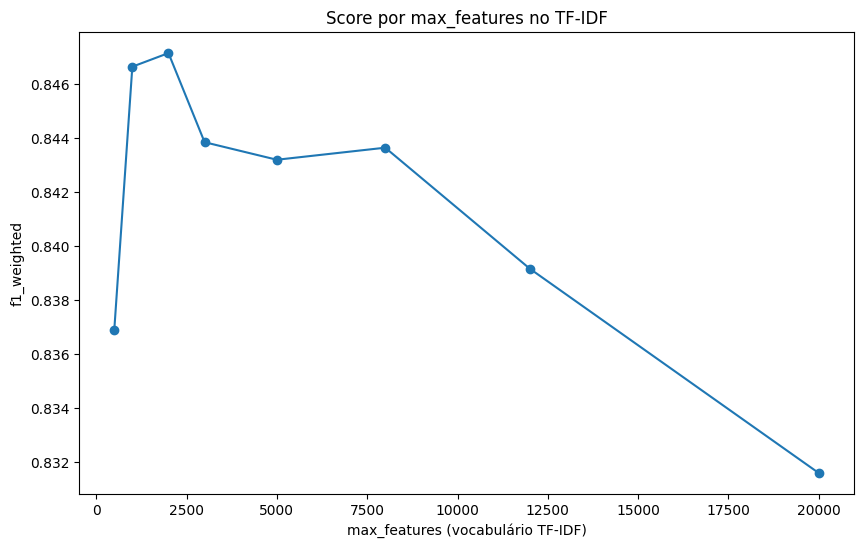

CPU times: user 22min 32s, sys: 2.39 s, total: 22min 35s
Wall time: 22min 37s


In [11]:
%%time

# Vetorização TF-IDF
# Função para encontrar o valor ideal max_features
def encontrar_melhor_max_features(X_text,
                                  y,
                                  modelo,
                                  features_list=None,
                                  scoring='f1_weighted',
                                  cv=5,
                                  ngram_range=(1,2),
                                  plotar=True):
    """
    Encontra o melhor valor de max_features para o TfidfVectorizer.
    Mostra o valor testado na tela.
    """
    if features_list is None:
        features_list = [500,
                         1000,
                         2000,
                         3000,
                         5000,
                         8000,
                         12000,
                         20000]

    resultados = {}
    print("Testando valores de max_features para TF-IDF:\n")
    print("max_features |  F1 Score")
    print("-" * 28)

    for mf in features_list:
        vectorizer = TfidfVectorizer(max_features=mf, ngram_range=ngram_range, strip_accents='unicode')
        X_vec = vectorizer.fit_transform(X_text)
        scores = cross_val_score(modelo, X_vec, y, cv=cv, scoring=scoring)
        media = np.mean(scores)
        resultados[mf] = media
        print(f"{mf:>10} | {media:.4f}")

    melhor_max_features = max(resultados, key=resultados.get)
    print("\n" + "-" * 28)
    print(f"Melhor max_features: {melhor_max_features} (F1 Score = {resultados[melhor_max_features]:.4f})")

    if plotar:
        plt.figure(figsize=(10, 6))
        plt.plot(list(resultados.keys()), list(resultados.values()), marker='o')
        plt.xlabel("max_features (vocabulário TF-IDF)")
        plt.ylabel(scoring)
        plt.title("Score por max_features no TF-IDF")
        plt.grid(False)
        plt.show()

    return melhor_max_features, resultados

# Aplicando função para encontrar o valor ideal max_features
melhor_maxf, resultados = encontrar_melhor_max_features(X_train_text, y_train, RandomForestClassifier())

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Vetorização base
vectorizer = TfidfVectorizer(ngram_range=(1,2), # unigramas e bigramas, max_features=5000,
                             max_features=melhor_maxf, # limite de features
                             strip_accents='unicode'
                             )
# Aplicando
X_train_vec = vectorizer.fit_transform(X_train_text)
X_test_vec = vectorizer.transform(X_test_text)

# Visualizando
vectorizer

TfidfVectorizer(max_features=2000, ngram_range=(1, 2), strip_accents='unicode')

In [27]:
X_train_vec.shape

(15804, 2000)

In [28]:
X_test_vec.shape

(5268, 2000)

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, f1_score
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import label_binarize
from sklearn.metrics import (confusion_matrix, classification_report, roc_curve, auc, f1_score, accuracy_score)

# Modelo regressão logistica
modelo_reg_log = LogisticRegression(random_state=50,
                                    max_iter=1000,
                                    penalty='l2')

# Treinamento modelo
modelo_reg_log_fit = modelo_reg_log.fit(X_train_vec, y_train)

# Visualizando modelo
modelo_reg_log

LogisticRegression(max_iter=1000, random_state=50)

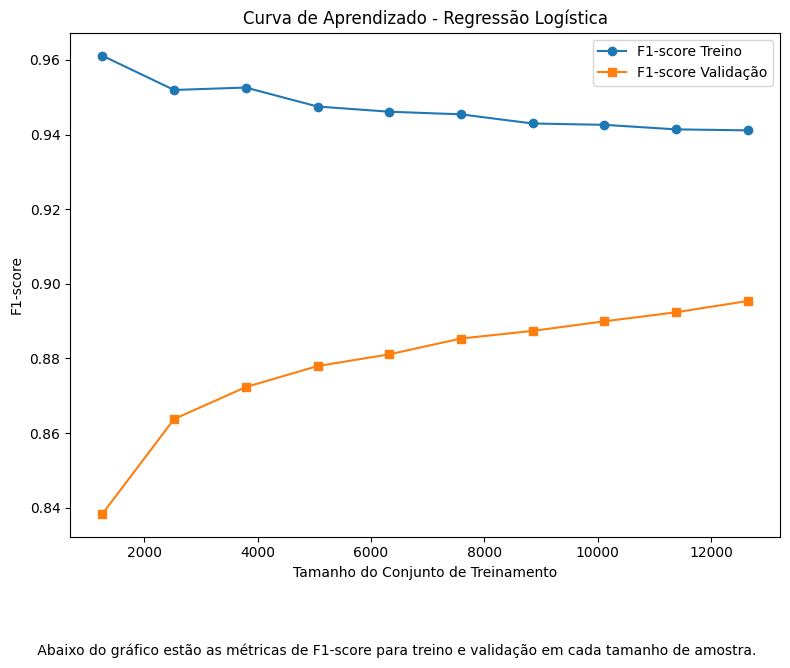

Tamanho Treinamento  F1-score Treino  F1-score Validação
0                 1264         0.961138            0.838372
1                 2528         0.951964            0.863775
2                 3792         0.952612            0.872337
3                 5057         0.947529            0.877969
4                 6321         0.946140            0.881109
5                 7585         0.945434            0.885348
6                 8850         0.942978            0.887397
7                10114         0.942621            0.889962
8                11378         0.941406            0.892388
9                12643         0.941138            0.895413

In [21]:
# Curva de Aprendizado com F1-score
train_sizes, train_scores, test_scores = learning_curve(estimator=modelo_reg_log,
                                                        X=X_train_vec,
                                                        y=y_train,
                                                        cv=5,
                                                        scoring='f1_weighted',
                                                        n_jobs=-1,
                                                        train_sizes=np.linspace(0.1, 1.0, 10),
                                                        random_state=42)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

# Gráfico
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, label='F1-score Treino', marker='o')
plt.plot(train_sizes, test_mean, label='F1-score Validação', marker='s')
plt.xlabel('Tamanho do Conjunto de Treinamento')
plt.ylabel('F1-score')
plt.title('Curva de Aprendizado - Regressão Logística')
plt.legend(loc='best')
plt.grid(False)
plt.tight_layout()

# Adiciona texto abaixo do gráfico
plt.figtext(0.5, -0.1,
            ' Abaixo do gráfico estão as métricas de F1-score para treino e validação em cada tamanho de amostra.',
            wrap=True, horizontalalignment='center', fontsize=10)
plt.show()

#
df_f1_learning = pd.DataFrame({'Tamanho Treinamento': train_sizes,
                               'F1-score Treino': train_mean,
                               'F1-score Validação': test_mean})

df_f1_learning

In [22]:
# Previsão
modelo_reg_log_pred = modelo_reg_log.predict(X_test_vec)

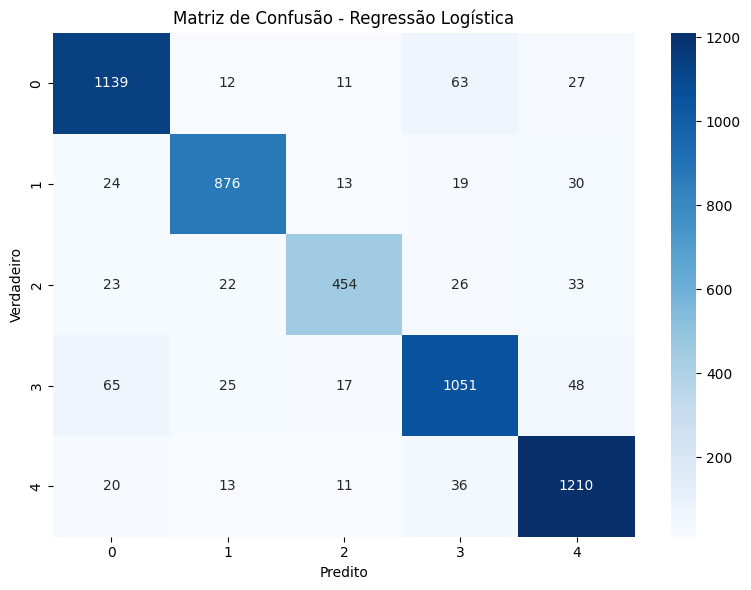

In [23]:
# Matriz de Confusão
cm = confusion_matrix(y_test, modelo_reg_log_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Matriz de Confusão - Regressão Logística')
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.tight_layout()
plt.show()

In [24]:
# Classification Report
print("Classification Report:")
print(classification_report(y_test, modelo_reg_log_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.91      0.90      1252
           1       0.92      0.91      0.92       962
           2       0.90      0.81      0.85       558
           3       0.88      0.87      0.88      1206
           4       0.90      0.94      0.92      1290

    accuracy                           0.90      5268
   macro avg       0.90      0.89      0.89      5268
weighted avg       0.90      0.90      0.90      5268



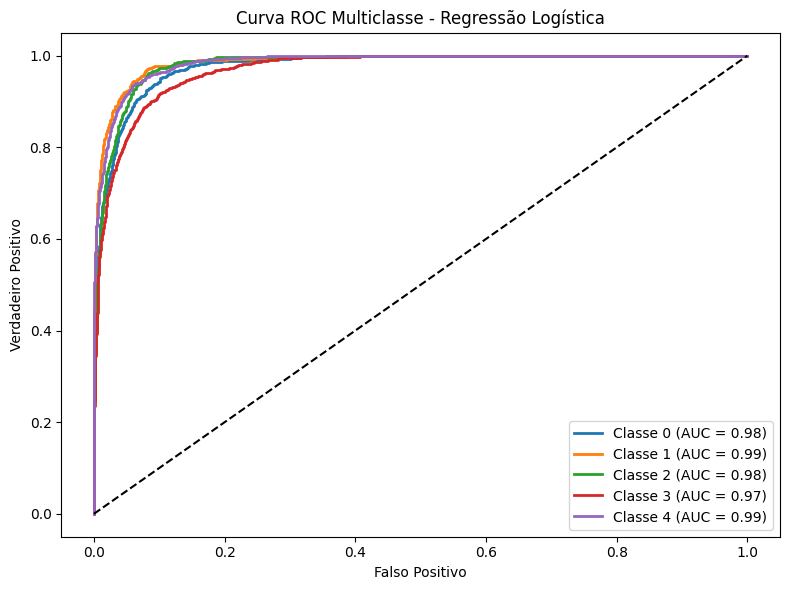

In [25]:
# Curva ROC
# Para problemas binários ou multiclasses
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_bin.shape[1]

if n_classes == 1:
    # Binário
    y_score = modelo_reg_log.decision_function(X_test_vec)
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('Falso Positivo')
    plt.ylabel('Verdadeiro Positivo')
    plt.title('Curva ROC - Regressão Logística')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()
else:
    # Multiclasse (curva ROC uma por classe)
    y_score = modelo_reg_log.decision_function(X_test_vec)
    plt.figure(figsize=(8, 6))
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'Classe {i} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('Falso Positivo')
    plt.ylabel('Verdadeiro Positivo')
    plt.title('Curva ROC Multiclasse - Regressão Logística')
    plt.legend(loc="lower right")
    plt.grid(False)
    plt.tight_layout()
    plt.show()

In [26]:
# DataFrame com métricas
accuracy = accuracy_score(y_test, modelo_reg_log_pred)
f1 = f1_score(y_test, modelo_reg_log_pred, average='weighted')

df_metrics = pd.DataFrame({'Modelo': ['LogisticRegression (TF-IDF)'],
                           'Accuracy': [accuracy],
                           'F1-Score': [f1]})

df_metrics

Modelo  Accuracy  F1-Score
0  LogisticRegression (TF-IDF)  0.897874   0.89754

# **Parte 17 - Conclusão final**

Neste projeto, realizamos uma análise comparativa entre diferentes abordagens de classificação de texto, avaliando:

* Modelos clássicos de machine learning com vetorização **TF-IDF**
* Modelos com embeddings extraídos de **Transformers (BERTimbau)** combinados com classificadores supervisionados

As métricas avaliadas incluíram **Accuracy, Precision, Recall e F1-Score**, com base em um problema de classificação multiclasse.

**Principais Conclusões**

1. **Modelos clássicos com TF-IDF foram superiores em desempenho.**

   * A **Regressão Logística com TF-IDF** foi o modelo mais eficaz, com F1-Score de **0.891**, combinando alta precisão e generalização.
   * **LightGBM e Random Forest com TF-IDF** também apresentaram excelente desempenho.

2. **Embeddings de Transformers (BERTimbau) + ML tiveram desempenho inferior.**

   * Embora semanticamente ricos, os embeddings não superaram a simplicidade e efetividade do TF-IDF neste cenário.
   * O melhor modelo com embeddings, **Logistic Regression (Transformers)**, atingiu F1 de **0.738** — significativamente abaixo do TF-IDF.

3. **Modelos como Decision Tree e XGBoost apresentaram desempenho fraco.**

   * Especialmente o **XGBoost com TF-IDF**, que teve um F1 alarmante de **0.23**, sinalizando falhas graves de modelagem ou compatibilidade com a representação textual esparsa.

**Lições Aprendidas**

* Modelos simples continuam altamente eficazes quando combinados com boas representações vetoriais como TF-IDF.

* Transformers exigem mais do que apenas extração de embeddings

**fine-tuning supervisionado completo** ou **task-specific training** tende a oferecer melhores ganhos.

* A avaliação de modelos deve sempre considerar **tanto métricas quanto interpretação qualitativa** (ex: matriz de confusão, curvas ROC).

**Próximos Passos Sugeridos**

* Explorar fine-tuning completo de BERTimbau com `Trainer` ou `PEFT`.

* Aplicar validação estratificada com métricas por classe.

* Testar outras técnicas de embedding contextual (ex: `Sentence-BERT`, `CamemBERT` para multilínguas).

* Usar pipelines de explainability (ex: LIME, SHAP) para entender as decisões dos modelos.

